# 타입 상성, 포켓몬 class, 기술 및 배틀 로직


In [ ]:
# Part 1: Core Game Classes and Battle Mechanics
# This section includes type definitions, Pokémon classes, moves, and battle logic

import os
import numpy as np
import time
import random
import json
import threading
import tensorflow as tf
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from collections import deque, namedtuple
from tqdm import tqdm

# Create model path
MODEL_PATH = './pokemon_rl_models'
os.makedirs(MODEL_PATH, exist_ok=True)

# Pokémon Type Definitions
class PokemonType:
    """Pokémon type definition"""
    NORMAL = 0
    FIRE = 1
    WATER = 2
    ELECTRIC = 3
    GRASS = 4
    ICE = 5
    FIGHTING = 6
    POISON = 7
    GROUND = 8
    FLYING = 9
    PSYCHIC = 10
    BUG = 11
    ROCK = 12
    GHOST = 13
    DRAGON = 14
    DARK = 15
    STEEL = 16
    FAIRY = 17

# Type effectiveness table
TYPE_EFFECTIVENESS = [
    # Normal  Fire  Water  Elec  Grass   Ice  Fight  Pois  Ground  Fly  Psychic  Bug  Rock  Ghost  Drag  Dark  Steel  Fairy
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 0.5, 1.0],  # Normal
    [1.0, 0.5, 0.5, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 0.5, 1.0, 2.0, 1.0],  # Fire
    [1.0, 2.0, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.5, 1.0, 1.0, 1.0],  # Water
    [1.0, 1.0, 2.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0],  # Electric
    [1.0, 0.5, 2.0, 1.0, 0.5, 1.0, 1.0, 0.5, 2.0, 0.5, 1.0, 0.5, 2.0, 1.0, 0.5, 1.0, 0.5, 1.0],  # Grass
    [1.0, 0.5, 0.5, 1.0, 2.0, 0.5, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.5, 1.0],  # Ice
    [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 2.0, 0.0, 1.0, 2.0, 2.0, 0.5],  # Fighting
    [1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.0, 2.0],  # Poison
    [1.0, 2.0, 1.0, 2.0, 0.5, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 0.5, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0],  # Ground
    [1.0, 1.0, 1.0, 0.5, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0],  # Flying
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0],  # Psychic
    [1.0, 0.5, 1.0, 1.0, 2.0, 1.0, 0.5, 0.5, 1.0, 0.5, 2.0, 1.0, 1.0, 0.5, 1.0, 2.0, 0.5, 0.5],  # Bug
    [1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 0.5, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0],  # Rock
    [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.5, 1.0, 1.0],  # Ghost
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 0.5, 0.0],  # Dragon
    [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.5, 1.0, 0.5],  # Dark
    [1.0, 0.5, 0.5, 0.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 0.5, 2.0],  # Steel
    [1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 2.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 0.5, 1.0],  # Fairy
]

# Type name mapping for Korean names
TYPE_NAMES = {
    "노말": PokemonType.NORMAL,
    "불": PokemonType.FIRE,
    "물": PokemonType.WATER,
    "전기": PokemonType.ELECTRIC,
    "풀": PokemonType.GRASS,
    "얼음": PokemonType.ICE,
    "격투": PokemonType.FIGHTING,
    "독": PokemonType.POISON,
    "땅": PokemonType.GROUND,
    "비행": PokemonType.FLYING,
    "에스퍼": PokemonType.PSYCHIC,
    "벌레": PokemonType.BUG,
    "바위": PokemonType.ROCK,
    "고스트": PokemonType.GHOST,
    "드래곤": PokemonType.DRAGON,
    "악": PokemonType.DARK,
    "강철": PokemonType.STEEL,
    "페어리": PokemonType.FAIRY
}

# 지형 효과 클래스 정의
class Terrain:
    """지형 효과 클래스"""
    GRASSY = "Grassy Terrain"    # 풀지형
    ELECTRIC = "Electric Terrain" # 전기지형
    PSYCHIC = "Psychic Terrain"   # 에스퍼지형
    MISTY = "Misty Terrain"       # 페어리지형

# Core Game Classes
class Move:
    """Pokémon move class"""
    def __init__(self, name, type_id, category, power, accuracy, pp, effects=None):
        self.name = name
        self.type = type_id
        self.category = category  # 'Physical', 'Special', or 'Status'
        self.power = power
        self.accuracy = accuracy
        self.pp = pp
        self.max_pp = pp
        self.effects = effects if effects else {}
        self.battle_effects = {}  # 배틀 중 발생하는 효과 (치명타 등)

class Pokemon:
    """Pokémon class with level 50 stat adjustments"""
    def __init__(self, name, types, stats, moves, level=50):
        self.name = name
        self.types = types

        # Adjust stats for level 50
        self.stats = {
            'hp': stats['hp'] + 75,  # +75 HP for level 50
            'atk': stats['atk'] + 20,  # +25 for other stats at level 50
            'def': stats['def'] + 20,
            'spa': stats['spa'] + 20,
            'spd': stats['spd'] + 20,
            'spe': stats['spe'] + 20
        }

        self.moves = moves
        self.original_moves = moves.copy()  # 원본 기술 목록 저장
        self.level = level

        # Current state
        self.current_hp = self.stats['hp']
        self.status_condition = None  # None, 'Poison', 'Paralyze', 'Burn', 'Sleep', 'Freeze'
        self.status_counter = 0  # Counter for status conditions like sleep
        self.critical_hit_stage = 0  # 치명타 확률 단계 (0~3)
        self.stat_stages = {
            'atk': 0, 'def': 0, 'spa': 0, 'spd': 0, 'spe': 0,
            'accuracy': 0, 'evasion': 0
        }

        # 몸부림치기 기술 정의 (미리 생성)
        self.struggle_move = Move(
            "몸부림치기",
            TYPE_NAMES["노말"],  # Normal type
            "Physical",
            50,  # Fixed power
            100,  # 100% accuracy
            1,   # PP is set to 1
            {"recoil": 0.25}  # Has recoil damage
        )

        # 몸부림치기 추가 여부 플래그
        self.struggle_added = False

    def is_fainted(self):
        """Check if fainted"""
        return self.current_hp <= 0

    def calculate_stat(self, stat_name):
        """Calculate actual stat considering stat stages and status conditions"""
        if stat_name == 'hp':
            return self.stats['hp']

        base_stat = self.stats[stat_name]
        stage = self.stat_stages[stat_name]

        # Calculate multiplier based on stat stage (Pokémon formula)
        if stage >= 0:
            multiplier = (2 + stage) / 2
        else:
            multiplier = 2 / (2 - stage)

        # Apply status condition effects
        if self.status_condition == 'Paralyze' and stat_name == 'spe':
            # Paralysis reduces speed by 50%
            multiplier *= 0.5
        elif self.status_condition == 'Burn' and stat_name == 'atk':
            # Burn reduces attack by 50%
            multiplier *= 0.5

        return int(base_stat * multiplier)

    def can_move(self):
        """Check if the Pokemon can move based on status condition"""
        if self.status_condition == 'Paralyze':
            # 25% chance of not being able to move when paralyzed
            return random.random() > 0.25
        elif self.status_condition == 'Sleep':
            # Can't move while asleep
            return False
        elif self.status_condition == 'Freeze':
            # 20% chance to thaw each turn
            if random.random() < 0.2:
                self.status_condition = None
                return True
            return False
        return True

    def apply_status_turn_end(self):
        """Apply status condition effects at the end of a turn"""
        effects = []

        if self.status_condition == 'Poison':
            # Poison damage: 1/8 of max HP
            damage = max(1, self.stats['hp'] // 8)
            self.current_hp = max(0, self.current_hp - damage)
            effects.append(f"{self.name}은(는) 독 데미지를 입었다! (-{damage} HP)")

        elif self.status_condition == 'Burn':
            # Burn damage: 1/16 of max HP
            damage = max(1, self.stats['hp'] // 16)
            self.current_hp = max(0, self.current_hp - damage)
            effects.append(f"{self.name}은(는) 화상 데미지를 입었다! (-{damage} HP)")

        elif self.status_condition == 'Sleep':
            # Sleep counter
            self.status_counter += 1
            # Sleep lasts 1-3 turns
            if self.status_counter >= random.randint(1, 3):
                self.status_condition = None
                self.status_counter = 0
                effects.append(f"{self.name}은(는) 잠에서 깨어났다!")
            else:
                effects.append(f"{self.name}은(는) 계속 자고 있다...")

        return effects

    def get_valid_moves(self):
        """Return list of valid move indices with PP > 0"""
        valid_moves = [i for i, move in enumerate(self.moves) if i < len(self.moves) and move.pp > 0]

        # If all moves have 0 PP, return Struggle
        if not valid_moves:
            # 이미 몸부림치기가 추가되어 있는지 확인
            struggle_index = None
            for i, move in enumerate(self.moves):
                if move.name == "몸부림치기":
                    struggle_index = i
                    # 몸부림치기의 PP 리셋 (소진될 수 없음)
                    move.pp = 1
                    break

            # 몸부림치기가 없으면 추가
            if struggle_index is None:
                self.moves.append(self.struggle_move)
                self.struggle_added = True
                struggle_index = len(self.moves) - 1

            return [struggle_index]

        return valid_moves

    def reset(self):
        """Reset Pokémon to full health and clear status conditions"""
        self.current_hp = self.stats['hp']
        self.status_condition = None
        self.status_counter = 0
        self.critical_hit_stage = 0  # 치명타 단계 초기화
        self.stat_stages = {
            'atk': 0, 'def': 0, 'spa': 0, 'spd': 0, 'spe': 0,
            'accuracy': 0, 'evasion': 0
        }

        # 몸부림치기가 추가되었으면 원본 기술로 복원
        if self.struggle_added:
            self.moves = self.original_moves.copy()
            self.struggle_added = False

        # Reset move PP
        for move in self.moves:
            move.pp = move.max_pp
            # 배틀 효과 초기화
            if hasattr(move, 'battle_effects'):
                move.battle_effects = {}

# 치명타 확률 계산 함수
def get_critical_chance(stage):
    """치명타 단계에 따른 확률 계산"""
    if stage <= 0:
        return 1/24  # 약 4.17%
    elif stage == 1:
        return 1/8   # 12.5%
    elif stage == 2:
        return 1/2   # 50%
    else:
        return 1     # 100%

# 우선권 기술 확인 함수
def get_move_priority(move):
    """기술의 우선 순위 값 반환"""
    if not hasattr(move, 'effects') or not move.effects:
        return 0
    return move.effects.get('priority', 0)

def calculate_damage(move, attacker, defender, battle=None):
    """Damage calculation function"""
    # No damage for status moves
    if move.category == 'Status':
        return 0

    # Check accuracy
    if random.randint(1, 100) > move.accuracy:
        return 0  # Missed

    # Type effectiveness
    type_effectiveness = 1.0
    for def_type in defender.types:
        type_effectiveness *= TYPE_EFFECTIVENESS[move.type][def_type]

    # Same-Type Attack Bonus (STAB)
    stab = 1.5 if move.type in attacker.types else 1.0

    # Random factor (0.85-1.0)
    random_factor = random.uniform(0.85, 1.0)

    # 치명타 계산 (향상된 시스템)
    critical_stages = 0

    # 포켓몬의 치명타 단계
    critical_stages += attacker.critical_hit_stage

    # 기술의 치명타 속성
    if move.effects and 'critical_rate' in move.effects:
        critical_stages += move.effects['critical_rate']

    # 치명타 확률 계산
    critical_chance = get_critical_chance(critical_stages)

    # 치명타 여부
    is_critical = random.random() < critical_chance
    critical = 1.5 if is_critical else 1.0  # 치명타 데미지 수정자

    # 치명타 발생 시 battle_effects에 기록
    if is_critical:
        if not hasattr(move, 'battle_effects'):
            move.battle_effects = {}
        move.battle_effects['critical_hit'] = True

    # Determine attack/defense stats
    if move.category == 'Physical':
        attack_stat = attacker.calculate_stat('atk')
        defense_stat = defender.calculate_stat('def')
    else:  # Special
        attack_stat = attacker.calculate_stat('spa')
        defense_stat = defender.calculate_stat('spd')

    # Damage calculation formula
    damage = ((2 * attacker.level / 5 + 2) * move.power * attack_stat / defense_stat / 50 + 2)
    damage *= stab * type_effectiveness * critical * random_factor

    # 지형 효과 적용
    if battle and battle.terrain:
        terrain_type = battle.terrain['name']
        move_type_name = get_type_name(move.type)

        if terrain_type == Terrain.GRASSY and move_type_name == "풀":
            # 풀지형에서 풀타입 기술 위력 1.3배
            damage = int(damage * 1.3)
        elif terrain_type == Terrain.ELECTRIC and move_type_name == "전기":
            # 전기지형에서 전기타입 기술 위력 1.3배
            damage = int(damage * 1.3)
        elif terrain_type == Terrain.PSYCHIC and move_type_name == "에스퍼":
            # 에스퍼지형에서 에스퍼타입 기술 위력 1.3배
            damage = int(damage * 1.3)
        elif terrain_type == Terrain.MISTY and move_type_name == "드래곤":
            # 페어리지형에서 드래곤타입 기술 위력 0.5배
            damage = int(damage * 0.5)

    return max(1, int(damage))  # Minimum 1 damage

# 타입 이름 가져오기 함수
def get_type_name(type_id):
    """타입 ID에 해당하는 이름 반환"""
    for name, id in TYPE_NAMES.items():
        if id == type_id:
            return name
    return "Unknown"

class PokemonTeam:
    """Pokémon team class"""
    def __init__(self, pokemons):
        self.pokemons = pokemons
        self.active_pokemon_index = 0

    @property
    def active_pokemon(self):
        """Currently active Pokémon"""
        return self.pokemons[self.active_pokemon_index]

    def switch_pokemon(self, index):
        """Switch Pokémon"""
        if 0 <= index < len(self.pokemons) and not self.pokemons[index].is_fainted() and index != self.active_pokemon_index:
            self.active_pokemon_index = index
            return True
        return False

    def all_fainted(self):
        """Check if all Pokémon are fainted"""
        return all(pokemon.is_fainted() for pokemon in self.pokemons)

    def get_first_non_fainted(self):
        """Get index of first non-fainted Pokémon"""
        for i, pokemon in enumerate(self.pokemons):
            if not pokemon.is_fainted():
                return i
        return -1  # All fainted

    def get_valid_switches(self):
        """Get list of valid switch indices"""
        return [i for i, pokemon in enumerate(self.pokemons)
                if i != self.active_pokemon_index and not pokemon.is_fainted()]

    def reset(self):
        """Reset all Pokémon in the team"""
        for pokemon in self.pokemons:
            pokemon.reset()

        # Set active Pokémon to first one
        first_index = self.get_first_non_fainted()
        if first_index != -1:
            self.active_pokemon_index = first_index

class PokemonBattle:
    """Pokémon battle class - updated with speed-based turn order and proper switching"""
    def __init__(self, player_team, opponent_team):
        self.player_team = player_team
        self.opponent_team = opponent_team
        self.turn = 0
        self.last_move_result = None
        self.pending_switch = None  # To track forced switches after fainting
        self.terrain = None  # 현재 지형 효과 추가

    def set_terrain(self, terrain_type, duration=5):
        """지형 효과 설정"""
        self.terrain = {
            'name': terrain_type,
            'turns': duration
        }
        return f"{terrain_type} 효과가 발동되었다!"

    def is_battle_over(self):
        """Check if battle is over"""
        return self.player_team.all_fainted() or self.opponent_team.all_fainted()

    def get_winner(self):
        """Get winner"""
        if self.player_team.all_fainted():
            return "opponent"
        if self.opponent_team.all_fainted():
            return "player"
        return None

    def reset(self):
        """Reset battle to initial state"""
        # 두 팀의 포켓몬을 모두 리셋
        self.player_team.reset()
        self.opponent_team.reset()

        # 기타 배틀 상태 초기화
        self.turn = 0
        self.last_move_result = None
        self.pending_switch = None
        self.terrain = None  # 지형 효과 초기화

    def _perform_move(self, attacker, defender, move_index):
        """Move execution logic"""

        # 안전 체크 추가
        if move_index >= len(attacker.moves):
            print(f"오류: {attacker.name}의 기술 인덱스({move_index})가 범위를 벗어남 (기술 개수: {len(attacker.moves)})")
            # 유효한 첫 번째 기술 사용
            valid_moves = attacker.get_valid_moves()
            if valid_moves:
                move_index = valid_moves[0]
            else:
                # 이 부분은 실행될 가능성이 없지만 안전장치로 유지
                print(f"심각한 오류: {attacker.name}에게 유효한 기술이 없습니다.")
                return {
                    "success": False,
                    "message": f"{attacker.name}은(는) 움직일 수 없다!"
                }

        move = attacker.moves[move_index]

        # 배틀 효과 초기화
        if not hasattr(move, 'battle_effects'):
            move.battle_effects = {}
        else:
            move.battle_effects = {}

        # Check if attacker can move due to status conditions
        if not attacker.can_move():
            return {
                "success": False,
                "message": f"{attacker.name}은(는) {attacker.status_condition} 상태로 인해 움직일 수 없다!"
            }

        # Struggle인 경우 특별 처리
        is_struggle = move.name == "몸부림치기"

        # Struggle의 경우 PP 감소 제외
        if not is_struggle:
            # 기존 PP 감소 로직
            if move.pp <= 0:
                return {"success": False, "message": f"{move.name}의 PP가 없습니다!"}
            move.pp -= 1

        # 데미지 계산 (지형 효과 반영)
        damage = calculate_damage(move, attacker, defender, battle=self)
        before_hp = defender.current_hp
        defender.current_hp = max(0, defender.current_hp - damage)

        # Apply effects based on move properties
        effects_applied = []
        if move.effects and "status" in move.effects and random.random() < move.effects.get("chance", 1.0):
            defender.status_condition = move.effects["status"]
            if move.effects["status"] == "Sleep":
                defender.status_counter = 0  # Initialize sleep counter
            effects_applied.append(f"{defender.name}에게 {move.effects['status']} 상태가 되었다!")

        # 반동 데미지 처리
        if move.effects and "recoil" in move.effects and damage > 0:
            recoil_factor = move.effects["recoil"]  # 예: 0.33은 입힌 데미지의 1/3만큼 반동
            recoil_damage = max(1, int(damage * recoil_factor))
            attacker.current_hp = max(0, attacker.current_hp - recoil_damage)
            effects_applied.append(f"{attacker.name}은(는) 반동으로 {recoil_damage}의 데미지를 입었다!")

        if move.effects and "stat_change" in move.effects and random.random() < move.effects.get("chance", 1.0):
            # Simple stat change
            stat = move.effects["stat_change"]
            change = move.effects.get("change", -1)  # Default to -1 for opponents
            if move.effects.get("target", "opponent") == "self":
                attacker.stat_stages[stat] = min(6, attacker.stat_stages[stat] + change)
                effects_applied.append(f"{attacker.name}의 {stat}이(가) {'올라갔다!' if change > 0 else '내려갔다!'}")
            else:
                defender.stat_stages[stat] = max(-6, defender.stat_stages[stat] + change)
                effects_applied.append(f"{defender.name}의 {stat}이(가) {'올라갔다!' if change > 0 else '내려갔다!'}")

        if move.effects and "self_change" in move.effects:
            # Self stat change
            stat = move.effects["stat_change"]
            change = move.effects["self_change"]
            attacker.stat_stages[stat] = min(6, max(-6, attacker.stat_stages[stat] + change))
            effects_applied.append(f"{attacker.name}의 {stat}이(가) {'올라갔다!' if change > 0 else '내려갔다!'}")

        if move.effects and "heal" in move.effects:
            heal_amount = int(attacker.stats['hp'] * move.effects["heal"])
            attacker.current_hp = min(attacker.stats['hp'], attacker.current_hp + heal_amount)
            effects_applied.append(f"{attacker.name}의 체력이 회복되었다!")

        # 치명타 메시지 추가
        if hasattr(move, 'battle_effects') and move.battle_effects.get('critical_hit', False) and damage > 0:
            effects_applied.append("급소에 맞았다!")

        # Calculate effectiveness message
        effectiveness = ""
        if damage > 0:
            type_multiplier = 1.0
            for def_type in defender.types:
                type_multiplier *= TYPE_EFFECTIVENESS[move.type][def_type]

            if type_multiplier > 1.0:
                effectiveness = "효과가 뛰어났다!"
            elif type_multiplier < 1.0 and type_multiplier > 0:
                effectiveness = "효과가 별로인 듯하다..."
            elif type_multiplier == 0:
                effectiveness = "효과가 없는 것 같다..."

        return {
            "success": True,
            "damage": damage,
            "before_hp": before_hp,
            "after_hp": defender.current_hp,
            "effectiveness": effectiveness,
            "effects": effects_applied,
            "fainted": defender.is_fainted()
        }

    def _handle_fainted_pokemon(self, team, is_player_team=True):
        """Handle fainted Pokémon - returns effects messages and whether a switch happened"""
        effects = []
        switch_happened = False

        if team.active_pokemon.is_fainted():
            if is_player_team:
                effects.append(f"{team.active_pokemon.name}은(는) 쓰러졌다!")
            else:
                effects.append(f"상대 {team.active_pokemon.name}은(는) 쓰러졌다!")

            # Find next available Pokémon
            next_index = team.get_first_non_fainted()
            if next_index != -1:
                team.switch_pokemon(next_index)
                if is_player_team:
                    effects.append(f"플레이어가 {team.active_pokemon.name}을(를) 내보냈다!")
                else:
                    effects.append(f"상대가 {team.active_pokemon.name}을(를) 내보냈다!")
                switch_happened = True

        return effects, switch_happened

    def end_turn_effects(self):
        """Apply end-of-turn effects like status conditions"""
        effects = []

        # Player Pokémon status effects
        player_effects = self.player_team.active_pokemon.apply_status_turn_end()
        effects.extend(player_effects)

        # Opponent Pokémon status effects
        opponent_effects = self.opponent_team.active_pokemon.apply_status_turn_end()
        effects.extend(opponent_effects)

        # 지형 효과 적용
        if self.terrain:
            self.terrain['turns'] -= 1

            # 풀지형 체력 회복 효과
            if self.terrain['name'] == Terrain.GRASSY:
                for pokemon in self.player_team.pokemons + self.opponent_team.pokemons:
                    if not pokemon.is_fainted():
                        heal_amount = max(1, pokemon.stats['hp'] // 16)
                        old_hp = pokemon.current_hp
                        pokemon.current_hp = min(pokemon.stats['hp'], pokemon.current_hp + heal_amount)

                        if pokemon.current_hp > old_hp:
                            effects.append(f"{pokemon.name}은(는) 풀지형으로 체력을 회복했다! (+{heal_amount} HP)")

            # 지형 효과 종료 확인
            if self.terrain['turns'] <= 0:
                effects.append(f"{self.terrain['name']} 효과가 사라졌다!")
                self.terrain = None
            else:
                effects.append(f"{self.terrain['name']} 효과가 계속된다! ({self.terrain['turns']}턴 남음)")

        # Check if any Pokémon fainted due to status effects
        player_faint_effects, player_switched = self._handle_fainted_pokemon(self.player_team, True)
        effects.extend(player_faint_effects)

        opponent_faint_effects, opponent_switched = self._handle_fainted_pokemon(self.opponent_team, False)
        effects.extend(opponent_faint_effects)

        return effects, player_switched, opponent_switched

    def _process_turn(self, player_action_type, player_action_index, opponent_agent=None):
        """Process a complete turn with speed comparison and priority moves"""
        results = []

        # Get active Pokémon
        player_pokemon = self.player_team.active_pokemon
        opponent_pokemon = self.opponent_team.active_pokemon

        # Handle player switch action (switches happen before moves)
        player_switched = False
        if player_action_type == "switch":
            if self.player_team.switch_pokemon(player_action_index):
                result = {"success": True, "message": f"{self.player_team.active_pokemon.name}으로 교체했습니다!"}
                results.append({"actor": "player", "result": result})
                player_switched = True
            else:
                result = {"success": False, "message": "교체할 수 없는 포켓몬입니다."}
                results.append({"actor": "player", "result": result})
                return results  # Return early if switch fails

        # Determine opponent action
        opponent_action_type = "move"
        opponent_action_index = 0

        if opponent_agent is not None:
            # Use provided agent
            state = self.get_state(for_opponent=True)
            valid_actions = self.get_valid_actions(for_opponent=True)
            action = opponent_agent.choose_action(state, valid_actions)

            # Classify action
            if action < 4:  # Use move
                opponent_action_type = "move"
                opponent_action_index = action
            else:  # Switch Pokémon
                opponent_action_type = "switch"
                switch_index = action - 4
                valid_switches = self.opponent_team.get_valid_switches()
                if 0 <= switch_index < len(valid_switches):
                    opponent_action_index = valid_switches[switch_index]
                else:
                    # Invalid switch, default to first move
                    valid_moves = self.opponent_team.active_pokemon.get_valid_moves()
                    if valid_moves:
                        opponent_action_index = valid_moves[0]
        else:
            # Default AI logic for move selection
            active_pokemon = self.opponent_team.active_pokemon
            player_pokemon = self.player_team.active_pokemon

            # Get valid moves first
            valid_moves = active_pokemon.get_valid_moves()

            # Calculate estimated damage for all moves
            best_damage = -1
            best_move_index = -1

            for i, move in enumerate(active_pokemon.moves):
                if move.pp <= 0:
                    continue

                # Calculate potential damage
                potential_damage = 0
                if move.category != 'Status':
                    # Type effectiveness
                    type_effectiveness = 1.0
                    for def_type in player_pokemon.types:
                        type_effectiveness *= TYPE_EFFECTIVENESS[move.type][def_type]

                    # STAB
                    stab = 1.5 if move.type in active_pokemon.types else 1.0

                    # Attack/defense stats
                    if move.category == 'Physical':
                        attack_stat = active_pokemon.calculate_stat('atk')
                        defense_stat = player_pokemon.calculate_stat('def')
                    else:  # Special
                        attack_stat = active_pokemon.calculate_stat('spa')
                        defense_stat = player_pokemon.calculate_stat('spd')

                    # Damage calculation (excluding random factors)
                    potential_damage = ((2 * active_pokemon.level / 5 + 2) * move.power * attack_stat / defense_stat / 50 + 2)
                    potential_damage *= stab * type_effectiveness

                # Select best move
                if potential_damage > best_damage:
                    best_damage = potential_damage
                    best_move_index = i

            # Choose move with highest potential damage
            valid_moves = active_pokemon.get_valid_moves()

            if valid_moves:
                if best_move_index != -1 and best_move_index in valid_moves:
                    opponent_action_index = best_move_index
                else:
                    opponent_action_index = valid_moves[0]  # 첫 번째 유효한 기술 선택
            else:
                # 유효한 기술이 없다면 몸부림치기 사용
                # get_valid_moves()는 몸부림치기를 추가하고 인덱스를 반환함
                opponent_action_index = active_pokemon.get_valid_moves()[0]

        # Handle opponent switch action
        opponent_switched = False
        if opponent_action_type == "switch":
            if self.opponent_team.switch_pokemon(opponent_action_index):
                result = {"success": True, "message": f"상대가 {self.opponent_team.active_pokemon.name}으로 교체했습니다!"}
                results.append({"actor": "opponent", "result": result})
                opponent_switched = True
            else:
                # If switch fails, use first valid move
                opponent_action_type = "move"
                valid_moves = self.opponent_team.active_pokemon.get_valid_moves()
                if valid_moves:
                    opponent_action_index = valid_moves[0]
                else:
                    result = {"success": False, "message": "상대방이 행동할 수 없습니다."}
                    results.append({"actor": "opponent", "result": result})
                    return results

        # Both players have switched or chosen moves, now execute moves in speed/priority order
        if not player_switched and player_action_type == "move" and not opponent_switched and opponent_action_type == "move":
            # Both chose moves, determine order based on priority and speed
            player_move = player_pokemon.moves[player_action_index]
            opponent_move = opponent_pokemon.moves[opponent_action_index]

            # 우선권 확인
            player_priority = get_move_priority(player_move)
            opponent_priority = get_move_priority(opponent_move)

            # 우선권이 다르면 우선권이 높은 쪽이 먼저, 같으면 속도로 판단
            if player_priority > opponent_priority:
                player_first = True
            elif player_priority < opponent_priority:
                player_first = False
            else:  # 우선권이 같으면 속도로 결정
                player_first = player_pokemon.calculate_stat('spe') >= opponent_pokemon.calculate_stat('spe')

            if player_first:
                # Player goes first
                player_result = self._perform_move(
                    self.player_team.active_pokemon,
                    self.opponent_team.active_pokemon,
                    player_action_index
                )
                results.append({"actor": "player", "result": player_result})

                # Check if opponent's Pokémon fainted
                opp_faint_effects, opp_switched = self._handle_fainted_pokemon(self.opponent_team, False)
                if opp_faint_effects:
                    for effect in opp_faint_effects:
                        if "effects" not in player_result:
                            player_result["effects"] = []
                        player_result["effects"].append(effect)

                # If opponent's Pokémon didn't faint and player's move was successful, opponent gets to move
                if player_result.get("success", False) and not self.opponent_team.active_pokemon.is_fainted() and not self.is_battle_over():
                    opponent_result = self._perform_move(
                        self.opponent_team.active_pokemon,
                        self.player_team.active_pokemon,
                        opponent_action_index
                    )
                    results.append({"actor": "opponent", "result": opponent_result})

                    # Check if player's Pokémon fainted
                    player_faint_effects, player_switched = self._handle_fainted_pokemon(self.player_team, True)
                    if player_faint_effects:
                        for effect in player_faint_effects:
                            if "effects" not in opponent_result:
                                opponent_result["effects"] = []
                            opponent_result["effects"].append(effect)
            else:
                # Opponent goes first
                opponent_result = self._perform_move(
                    self.opponent_team.active_pokemon,
                    self.player_team.active_pokemon,
                    opponent_action_index
                )
                results.append({"actor": "opponent", "result": opponent_result})

                # Check if player's Pokémon fainted
                player_faint_effects, player_switched = self._handle_fainted_pokemon(self.player_team, True)
                if player_faint_effects:
                    for effect in player_faint_effects:
                        if "effects" not in opponent_result:
                            opponent_result["effects"] = []
                        opponent_result["effects"].append(effect)

                # If player's Pokémon didn't faint and opponent's move was successful, player gets to move
                if opponent_result.get("success", False) and not self.player_team.active_pokemon.is_fainted() and not self.is_battle_over():
                    player_result = self._perform_move(
                        self.player_team.active_pokemon,
                        self.opponent_team.active_pokemon,
                        player_action_index
                    )
                    results.append({"actor": "player", "result": player_result})

                    # Check if opponent's Pokémon fainted
                    opp_faint_effects, opp_switched = self._handle_fainted_pokemon(self.opponent_team, False)
                    if opp_faint_effects:
                        for effect in opp_faint_effects:
                            if "effects" not in player_result:
                                player_result["effects"] = []
                            player_result["effects"].append(effect)
        elif not player_switched and player_action_type == "move":
            # Only player uses move (opponent switched)
            player_result = self._perform_move(
                self.player_team.active_pokemon,
                self.opponent_team.active_pokemon,
                player_action_index
            )
            results.append({"actor": "player", "result": player_result})

            # Check if opponent's Pokémon fainted
            opp_faint_effects, opp_switched = self._handle_fainted_pokemon(self.opponent_team, False)
            if opp_faint_effects:
                for effect in opp_faint_effects:
                    if "effects" not in player_result:
                        player_result["effects"] = []
                    player_result["effects"].append(effect)
        elif not opponent_switched and opponent_action_type == "move":
            # Only opponent uses move (player switched)
            opponent_result = self._perform_move(
                self.opponent_team.active_pokemon,
                self.player_team.active_pokemon,
                opponent_action_index
            )
            results.append({"actor": "opponent", "result": opponent_result})

            # Check if player's Pokémon fainted
            player_faint_effects, player_switched = self._handle_fainted_pokemon(self.player_team, True)
            if player_faint_effects:
                for effect in player_faint_effects:
                    if "effects" not in opponent_result:
                        opponent_result["effects"] = []
                    opponent_result["effects"].append(effect)

        # Apply end-of-turn effects
        end_turn_effects, player_end_switched, opponent_end_switched = self.end_turn_effects()
        if end_turn_effects:
            results.append({"actor": "end_turn", "effects": end_turn_effects})

        # Increment turn counter
        self.turn += 1

        return results

    def player_action(self, action_type, action_index, opponent_agent=None):
        """Process player action and complete the turn"""
        if action_type not in ["move", "switch"]:
            return {"success": False, "message": "잘못된 행동 유형입니다."}

        # Validate action index
        if action_type == "move" and (action_index < 0 or action_index >= len(self.player_team.active_pokemon.moves)):
            return {"success": False, "message": "잘못된 기술 인덱스입니다."}
        elif action_type == "switch":
            valid_switches = self.player_team.get_valid_switches()
            if action_index not in valid_switches:
                return {"success": False, "message": "교체할 수 없는 포켓몬입니다."}

        # Process the complete turn
        results = self._process_turn(action_type, action_index, opponent_agent)

        # Store last move result
        if results:
            self.last_move_result = results[-1].get("result", {}) if isinstance(results[-1], dict) else {}

        return results

    def opponent_action(self, opponent_agent=None):
        """This method is kept for backward compatibility but redirects to player_action"""
        # Since opponent actions are now handled within player_action, this is just a wrapper
        # that returns the last opponent result from player_action
        if self.last_move_result:
            return self.last_move_result
        else:
            # If no previous action, create a default turn with player using first move
            results = self.player_action("move", 0, opponent_agent)

            # Extract opponent result if available
            for result_item in results:
                if isinstance(result_item, dict) and result_item.get("actor") == "opponent":
                    return result_item.get("result", {"success": False, "message": "상대방 행동 실패"})

            return {"success": False, "message": "상대방 행동 실패"}

    def get_state(self, for_opponent=False):
        """Return state vector for reinforcement learning - fixed size for neural network"""
        state = []

        if not for_opponent:
            # Player perspective
            player_team = self.player_team
            opponent_team = self.opponent_team
        else:
            # Opponent perspective (self and opponent are swapped)
            player_team = self.opponent_team
            opponent_team = self.player_team

        # Active Pokémon info
        player_pokemon = player_team.active_pokemon

        # HP ratio (1)
        state.append(player_pokemon.current_hp / player_pokemon.stats['hp'])

        # Type (one-hot encoding) (18)
        for type_id in range(18):
            state.append(1.0 if type_id in player_pokemon.types else 0.0)

        # Main stats (5)
        for stat_name in ['atk', 'def', 'spa', 'spd', 'spe']:
            state.append(player_pokemon.calculate_stat(stat_name) / 255.0)  # Normalize

        # Status conditions (one-hot encoding) (7)
        status_conditions = [None, 'Poison', 'Paralyze', 'Burn', 'Sleep', 'Freeze', 'Confusion']
        for status in status_conditions:
            state.append(1.0 if player_pokemon.status_condition == status else 0.0)

        # Stat changes (7)
        for stat_name in ['atk', 'def', 'spa', 'spd', 'spe', 'accuracy', 'evasion']:
            state.append((player_pokemon.stat_stages[stat_name] + 6) / 12.0)  # Normalize -6~+6 range to 0~1

        # Move info (PP ratio) - always 4 moves (4)
        for i in range(4):
            if i < len(player_pokemon.moves) and player_pokemon.moves[i]:
                state.append(player_pokemon.moves[i].pp / player_pokemon.moves[i].max_pp)
            else:
                state.append(0.0)  # Pad with zeros if less than 4 moves

        # Opponent active Pokémon info
        opponent_pokemon = opponent_team.active_pokemon

        # HP ratio (1)
        state.append(opponent_pokemon.current_hp / opponent_pokemon.stats['hp'])

        # Type (one-hot encoding) (18)
        for type_id in range(18):
            state.append(1.0 if type_id in opponent_pokemon.types else 0.0)

        # Main stats (5)
        for stat_name in ['atk', 'def', 'spa', 'spd', 'spe']:
            state.append(opponent_pokemon.calculate_stat(stat_name) / 255.0)

        # Status conditions (one-hot encoding) (7)
        for status in status_conditions:
            state.append(1.0 if opponent_pokemon.status_condition == status else 0.0)

        # Stat changes (7)
        for stat_name in ['atk', 'def', 'spa', 'spd', 'spe', 'accuracy', 'evasion']:
            state.append((opponent_pokemon.stat_stages[stat_name] + 6) / 12.0)  # Normalize -6~+6 range to 0~1

        # Team info - Always 3 Pokémon for consistency
        # For each Pokémon: HP ratio and status flag (2 features per Pokémon)
        for i in range(3):
            if i < len(player_team.pokemons):
                pokemon = player_team.pokemons[i]
                state.append(pokemon.current_hp / pokemon.stats['hp'])  # HP ratio
                state.append(1.0 if pokemon.status_condition is not None else 0.0)  # Status condition
            else:
                # Padding for teams with fewer than 3 Pokémon
                state.append(0.0)
                state.append(0.0)

        # Opponent team info - Always 3 Pokémon for consistency
        for i in range(3):
            if i < len(opponent_team.pokemons):
                pokemon = opponent_team.pokemons[i]
                state.append(pokemon.current_hp / pokemon.stats['hp'])  # HP ratio
                state.append(1.0 if pokemon.status_condition is not None else 0.0)  # Status condition
            else:
                # Padding for teams with fewer than 3 Pokémon
                state.append(0.0)
                state.append(0.0)

        # Add turn number (normalized by max turns, e.g., 30) - useful for time pressure strategies
        state.append(min(1.0, self.turn / 30.0))

        # 지형 효과 상태 추가 (4)
        terrain_types = [Terrain.GRASSY, Terrain.ELECTRIC, Terrain.PSYCHIC, Terrain.MISTY]
        for terrain_type in terrain_types:
            is_active = self.terrain and self.terrain['name'] == terrain_type
            state.append(1.0 if is_active else 0.0)

        # 지형 효과 남은 턴 (1)
        if self.terrain:
            state.append(self.terrain['turns'] / 5.0)  # 최대 5턴 기준으로 정규화
        else:
            state.append(0.0)

        # Total: 91 features (original) + 5 features (terrain) = 96 features
        return np.array(state, dtype=np.float32)

    def get_valid_actions(self, for_opponent=False):
        """Return list of valid actions"""
        if not for_opponent:
            team = self.player_team
        else:
            team = self.opponent_team

        valid_actions = []

        # Valid moves: 0-3
        if team.active_pokemon:
            for i, move in enumerate(team.active_pokemon.moves):
                if i < 4 and move and move.pp > 0:  # Move exists and has PP
                    valid_actions.append(i)

            # Valid switches: 4-9 (max 6 Pokémon)
            valid_switches = team.get_valid_switches()
            for i, switch_index in enumerate(valid_switches):
                valid_actions.append(4 + i)  # Index starting from 4

        # If no valid actions (should never happen in normal gameplay), return [0]
        if not valid_actions:
            valid_actions.append(0)

        return valid_actions

    def reset(self):
        """Reset battle to initial state"""
        self.player_team.reset()
        self.opponent_team.reset()
        self.turn = 0
        self.last_move_result = None
        self.pending_switch = None
        self.terrain = None  # 지형 효과 초기화

# 포켓몬 기본 정보 및 강화학습 환경 (기술, action, reward 등)

## 여기를 Gym 라이브러리로 옮겨보기


In [ ]:
# Part 2: Pokémon Templates and RL Environment
# This section includes the Pokémon data templates and the reinforcement learning environment

import random
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import tensorflow as tf
import tensorflow.keras.backend as K

# Pokémon Templates from JSON data
# The templates are based on the provided data
POKEMON_TEMPLATES = [
    {
        "id": 3,
        "name": "이상해꽃",  # Venusaur
        "types": [TYPE_NAMES["풀"], TYPE_NAMES["독"]],
        "stats": {"hp": 80, "atk": 82, "def": 83, "spa": 100, "spd": 100, "spe": 80},
        "moves": [
            Move("기가드레인", TYPE_NAMES["풀"], "Special", 75, 100, 15, {"heal": 0.5}),
            Move("오물폭탄", TYPE_NAMES["독"], "Special", 90, 100, 10, {"status": "Poison", "chance": 0.1}),
            Move("대지의힘", TYPE_NAMES["땅"], "Special", 90, 100, 10, {"stat_change": "spd", "chance": 0.1}),
            Move("수면가루", TYPE_NAMES["풀"], "Status", 0, 75, 15, {"status": "Sleep"})
        ]
    },
    {
        "id": 6,
        "name": "리자몽",  # Charizard
        "types": [TYPE_NAMES["불"], TYPE_NAMES["비행"]],
        "stats": {"hp": 78, "atk": 84, "def": 78, "spa": 109, "spd": 85, "spe": 100},
        "moves": [
            Move("에어슬래시", TYPE_NAMES["비행"], "Special", 75, 95, 15, {"status": "Flinch", "chance": 0.3}),
            Move("불대문자", TYPE_NAMES["불"], "Special", 110, 85, 5, {"status": "Burn", "chance": 0.1}),
            Move("지진", TYPE_NAMES["땅"], "Physical", 100, 100, 10, {}),
            Move("오버히트", TYPE_NAMES["불"], "Special", 130, 90, 5, {"stat_change": "spa", "self_change": -2})
        ]
    },
    {
        "id": 9,
        "name": "거북왕",  # Blastoise
        "types": [TYPE_NAMES["물"]],
        "stats": {"hp": 79, "atk": 83, "def": 100, "spa": 85, "spd": 105, "spe": 78},
        "moves": [
            Move("하이드로펌프", TYPE_NAMES["물"], "Special", 110, 80, 5, {}),
            Move("냉동빔", TYPE_NAMES["얼음"], "Special", 90, 100, 10, {"status": "Freeze", "chance": 0.1}),
            Move("껍질깨기", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"def": -1, "spd": -1, "atk": 2, "spa": 2, "spe": 2}}),
            Move("악의파동", TYPE_NAMES["악"], "Special", 80, 100, 15, {"status": "Flinch", "chance": 0.3})
        ]
    },
    {
        "id": 157,
        "name": "블레이범",  # Typhlosion
        "types": [TYPE_NAMES["불"]],
        "stats": {"hp": 76, "atk": 104, "def": 71, "spa": 104, "spd": 71, "spe": 108},
        "moves": [
            Move("니트로차지", TYPE_NAMES["불"], "Physical", 50, 100, 20, {"stat_change": "spe", "self_change": 1}),
            Move("불대문자", TYPE_NAMES["불"], "Special", 110, 85, 5, {"status": "Burn", "chance": 0.1}),
            Move("와일드볼트", TYPE_NAMES["전기"], "Physical", 90, 100, 15, {"recoil": 0.25}),
            Move("지진", TYPE_NAMES["땅"], "Physical", 100, 100, 10, {})
        ]
    },
    {
        "id": 154,
        "name": "메가니움",  # Meganium
        "types": [TYPE_NAMES["풀"]],
        "stats": {"hp": 80, "atk": 82, "def": 100, "spa": 83, "spd": 100, "spe": 80},
        "moves": [
            Move("기가드레인", TYPE_NAMES["풀"], "Special", 75, 100, 10, {"heal": 0.5}),
            Move("광합성", TYPE_NAMES["풀"], "Status", 0, 100, 5, {"heal": 0.5}),
            Move("씨뿌리기", TYPE_NAMES["풀"], "Status", 0, 90, 10, {"status": "Leech Seed"}),
            Move("맹독", TYPE_NAMES["독"], "Status", 0, 90, 20, {"status": "Toxic"})
        ]
    },
    {
        "id": 160,
        "name": "장크로다일",  # Feraligatr
        "types": [TYPE_NAMES["물"]],
        "stats": {"hp": 85, "atk": 105, "def": 100, "spa": 79, "spd": 83, "spe": 78},
        "moves": [
            Move("용의춤", TYPE_NAMES["드래곤"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 1, "spe": 1}}),
            Move("아쿠아브레이크", TYPE_NAMES["물"], "Physical", 85, 100, 10, {"stat_change": "def", "chance": 0.2}),
            Move("냉동펀치", TYPE_NAMES["얼음"], "Physical", 75, 100, 15, {"status": "Freeze", "chance": 0.1}),
            Move("엄청난힘", TYPE_NAMES["노말"], "Physical", 120, 100, 5, {"self_stat_changes": {"atk": -1, "def": -1}})
        ]
    },
    {
        "id": 257,
        "name": "번치코",  # Blaziken
        "types": [TYPE_NAMES["불"], TYPE_NAMES["격투"]],
        "stats": {"hp": 80, "atk": 120, "def": 70, "spa": 110, "spd": 70, "spe": 80},
        "moves": [
            Move("칼춤", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 2}}),
            Move("플레어드라이브", TYPE_NAMES["불"], "Physical", 120, 100, 15, {"recoil": 0.33, "status": "Burn", "chance": 0.1}),
            Move("인파이트", TYPE_NAMES["격투"], "Physical", 120, 100, 5, {"self_stat_changes": {"def": -1, "spd": -1}}),
            Move("스톤에지", TYPE_NAMES["바위"], "Physical", 100, 80, 5, {"critical_rate": 1})
        ]
    },
    {
        "id": 254,
        "name": "나무킹",  # Sceptile
        "types": [TYPE_NAMES["풀"]],
        "stats": {"hp": 70, "atk": 85, "def": 65, "spa": 105, "spd": 85, "spe": 120},
        "moves": [
            Move("용의파동", TYPE_NAMES["드래곤"], "Special", 85, 100, 15, {}),
            Move("기가드레인", TYPE_NAMES["풀"], "Special", 75, 100, 10, {"heal": 0.5}),
            Move("진공파", TYPE_NAMES["격투"], "Special", 40, 100, 30, {"priority": 1}),
            Move("광합성", TYPE_NAMES["풀"], "Status", 0, 100, 5, {"heal": 0.5})
        ]
    },
    {
        "id": 260,
        "name": "대짱이",  # Swampert
        "types": [TYPE_NAMES["물"], TYPE_NAMES["땅"]],
        "stats": {"hp": 100, "atk": 110, "def": 90, "spa": 85, "spd": 90, "spe": 60},
        "moves": [
            Move("퀵턴", TYPE_NAMES["물"], "Physical", 60, 100, 20, {"uturn": True}),
            Move("눈사태", TYPE_NAMES["얼음"], "Physical", 120, 100, 10, {"priority": -4}),
            Move("아쿠아브레이크", TYPE_NAMES["물"], "Physical", 85, 100, 10, {"stat_change": "def", "chance": 0.2}),
            Move("지진", TYPE_NAMES["땅"], "Physical", 100, 100, 10, {})
        ]
    },
    {
        "id": 392,
        "name": "초염몽",  # Infernape
        "types": [TYPE_NAMES["불"], TYPE_NAMES["격투"]],
        "stats": {"hp": 76, "atk": 104, "def": 71, "spa": 104, "spd": 71, "spe": 108},
        "moves": [
            Move("번개펀치", TYPE_NAMES["전기"], "Physical", 75, 100, 15, {"status": "Paralysis", "chance": 0.1}),
            Move("플레어드라이브", TYPE_NAMES["불"], "Physical", 120, 100, 15, {"status": "Burn", "chance": 0.1, "recoil": 0.33}),
            Move("드레인펀치", TYPE_NAMES["격투"], "Physical", 75, 100, 10, {"heal": 0.5}),
            Move("지진", TYPE_NAMES["땅"], "Physical", 100, 100, 10, {})
        ]
    },
    {
        "id": 389,
        "name": "토대부기",  # Torterra
        "types": [TYPE_NAMES["풀"], TYPE_NAMES["땅"]],
        "stats": {"hp": 95, "atk": 109, "def": 105, "spa": 75, "spd": 85, "spe": 56},
        "moves": [
            Move("껍질깨기", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 2, "spa": 2, "spe": 2, "def": -1, "spd": -1}}),
            Move("지진", TYPE_NAMES["땅"], "Physical", 100, 100, 10, {}),
            Move("아이언헤드", TYPE_NAMES["강철"], "Physical", 80, 100, 15, {"status": "Flinch", "chance": 0.3}),
            Move("우드해머", TYPE_NAMES["풀"], "Physical", 120, 100, 15, {"recoil": 0.33})
        ]
    },
    {
        "id": 395,
        "name": "엠페르트",  # Empoleon
        "types": [TYPE_NAMES["물"], TYPE_NAMES["강철"]],
        "stats": {"hp": 84, "atk": 86, "def": 88, "spa": 111, "spd": 101, "spe": 60},
        "moves": [
            Move("하이드로펌프", TYPE_NAMES["물"], "Special", 110, 80, 5, {}),
            Move("냉동빔", TYPE_NAMES["얼음"], "Special", 90, 100, 10, {"status": "Freeze", "chance": 0.1}),
            Move("풀묶기", TYPE_NAMES["풀"], "Special", 80, 100, 15, {}),
            Move("퀵턴", TYPE_NAMES["물"], "Physical", 60, 100, 20, {"uturn": True})
        ]
    },
    {
        "id": 500,
        "name": "염무왕",  # Emboar
        "types": [TYPE_NAMES["불"], TYPE_NAMES["격투"]],
        "stats": {"hp": 110, "atk": 123, "def": 65, "spa": 100, "spd": 65, "spe": 65},
        "moves": [
            Move("양날박치기", TYPE_NAMES["바위"], "Physical", 120, 80, 15, {"recoil": 0.33}),
            Move("와일드볼트", TYPE_NAMES["전기"], "Physical", 90, 100, 15, {"recoil": 0.25}),
            Move("플레어드라이브", TYPE_NAMES["불"], "Physical", 120, 100, 15, {"recoil": 0.33, "status": "Burn", "chance": 0.1}),
            Move("니트로차지", TYPE_NAMES["불"], "Physical", 50, 100, 20, {"stat_change": "spe", "self_change": 1})
        ]
    },
    {
        "id": 497,
        "name": "샤로다",  # Serperior
        "types": [TYPE_NAMES["풀"]],
        "stats": {"hp": 75, "atk": 75, "def": 95, "spa": 75, "spd": 95, "spe": 113},
        "moves": [
            Move("리프스톰", TYPE_NAMES["풀"], "Special", 130, 90, 5, {"self_stat_changes": {"spa": -2}}),
            Move("기가드레인", TYPE_NAMES["풀"], "Special", 75, 100, 10, {"heal": 0.5}),
            Move("뱀눈초리", TYPE_NAMES["노말"], "Status", 0, 100, 30, {"status": "Paralysis"}),
            Move("용의파동", TYPE_NAMES["드래곤"], "Special", 85, 100, 10, {})
        ]
    },
    {
        "id": 503,
        "name": "대검귀",  # Samurott
        "types": [TYPE_NAMES["물"]],
        "stats": {"hp": 95, "atk": 100, "def": 85, "spa": 108, "spd": 70, "spe": 70},
        "moves": [
            Move("눈사태", TYPE_NAMES["얼음"], "Physical", 120, 100, 10, {"priority": -4}),
            Move("아쿠아브레이크", TYPE_NAMES["물"], "Physical", 85, 100, 10, {"stat_change": "def", "chance": 0.2}),
            Move("풀묶기", TYPE_NAMES["풀"], "Special", 80, 100, 15, {}),
            Move("아쿠아제트", TYPE_NAMES["물"], "Physical", 40, 100, 20, {"priority": 1})
        ]
    },
    {
        "id": 655,
        "name": "마폭시",  # Delphox
        "types": [TYPE_NAMES["불"], TYPE_NAMES["에스퍼"]],
        "stats": {"hp": 75, "atk": 69, "def": 72, "spa": 114, "spd": 100, "spe": 104},
        "moves": [
            Move("매지컬플레임", TYPE_NAMES["불"], "Special", 75, 100, 10, {"stat_change": "spa", "chance": 1.0}),
            Move("사이코키네시스", TYPE_NAMES["에스퍼"], "Special", 90, 100, 10, {"stat_change": "spd", "chance": 0.1}),
            Move("에너지볼", TYPE_NAMES["풀"], "Special", 90, 100, 10, {"stat_change": "spd", "chance": 0.1}),
            Move("명상", TYPE_NAMES["에스퍼"], "Status", 0, 100, 20, {"self_stat_changes": {"spa": 1, "spd": 1}})
        ]
    },
    {
        "id": 652,
        "name": "브리가론",  # Chesnaught
        "types": [TYPE_NAMES["풀"], TYPE_NAMES["격투"]],
        "stats": {"hp": 88, "atk": 107, "def": 122, "spa": 74, "spd": 75, "spe": 64},
        "moves": [
            Move("씨기관총", TYPE_NAMES["풀"], "Physical", 25, 100, 30, {"multi_hit": True}),
            Move("광합성", TYPE_NAMES["풀"], "Status", 0, 100, 5, {"heal": 0.5}),
            Move("바디프레스", TYPE_NAMES["격투"], "Physical", 80, 100, 10, {}),
            Move("철벽", TYPE_NAMES["강철"], "Status", 0, 100, 15, {"self_stat_changes": {"def": 2}})
        ]
    },
    {
        "id": 658,
        "name": "개굴닌자",  # Greninja
        "types": [TYPE_NAMES["물"], TYPE_NAMES["악"]],
        "stats": {"hp": 72, "atk": 95, "def": 67, "spa": 103, "spd": 71, "spe": 122},
        "moves": [
            Move("물수리검", TYPE_NAMES["물"], "Special", 15, 100, 20, {"priority": 1, "multi_hit": True, "critical_rate": 1}),
            Move("악의파동", TYPE_NAMES["악"], "Special", 80, 100, 15, {"status": "Flinch", "chance": 0.2}),
            Move("독압정", TYPE_NAMES["독"], "Status", 0, 100, 20, {"trap": "Spikes"}),
            Move("냉동빔", TYPE_NAMES["얼음"], "Special", 90, 100, 10, {"status": "Freeze", "chance": 0.1})
        ]
    },
    {
        "id": 727,
        "name": "어흥염",  # Incineroar
        "types": [TYPE_NAMES["불"], TYPE_NAMES["악"]],
        "stats": {"hp": 95, "atk": 115, "def": 90, "spa": 80, "spd": 90, "spe": 60},
        "moves": [
            Move("플레어드라이브", TYPE_NAMES["불"], "Physical", 120, 100, 15, {"recoil": 0.33, "status": "Burn", "chance": 0.1}),
            Move("도깨비불", TYPE_NAMES["불"], "Status", 0, 85, 15, {"status": "Burn"}),
            Move("DD래리어트", TYPE_NAMES["악"], "Physical", 85, 100, 10, {"rank_nullification": True}),
            Move("막말내뱉기", TYPE_NAMES["악"], "Status", 0, 100, 10, {"uturn": True, "stat_changes": {"spa": -1, "atk": -1}})
        ]
    },
    {
        "id": 724,
        "name": "모크나이퍼",  # Decidueye
        "types": [TYPE_NAMES["풀"], TYPE_NAMES["고스트"]],
        "stats": {"hp": 78, "atk": 107, "def": 75, "spa": 100, "spd": 100, "spe": 70},
        "moves": [
            Move("리프블레이드", TYPE_NAMES["풀"], "Physical", 90, 100, 15, {"critical_rate": 1}),
            Move("폴터가이스트", TYPE_NAMES["고스트"], "Physical", 110, 90, 5, {}),
            Move("칼춤", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 2}}),
            Move("더블윙", TYPE_NAMES["비행"], "Physical", 40, 90, 10, {"double_hit": True})
        ]
    },
    {
        "id": 730,
        "name": "누리레느",  # Primarina
        "types": [TYPE_NAMES["물"], TYPE_NAMES["페어리"]],
        "stats": {"hp": 80, "atk": 74, "def": 74, "spa": 126, "spd": 116, "spe": 60},
        "moves": [
            Move("물거품아리아", TYPE_NAMES["물"], "Special", 90, 100, 10, {}),
            Move("문포스", TYPE_NAMES["페어리"], "Special", 95, 100, 15, {"stat_change": "spa", "chance": 0.3}),
            Move("아쿠아제트", TYPE_NAMES["물"], "Physical", 40, 100, 20, {"priority": 1}),
            Move("에너지볼", TYPE_NAMES["풀"], "Special", 90, 100, 10, {"stat_change": "spd", "chance": 0.1})
        ]
    },
    {
        "id": 815,
        "name": "에이스번",  # Cinderace
        "types": [TYPE_NAMES["불"]],
        "stats": {"hp": 80, "atk": 116, "def": 75, "spa": 65, "spd": 75, "spe": 119},
        "moves": [
            Move("화염볼", TYPE_NAMES["불"], "Physical", 120, 90, 5, {"status": "Burn", "chance": 0.1}),
            Move("무릎차기", TYPE_NAMES["격투"], "Physical", 130, 90, 10, {"fail_damage": 0.5}),
            Move("유턴", TYPE_NAMES["벌레"], "Physical", 70, 100, 20, {"uturn": True}),
            Move("칼춤", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 2}})
        ]
    },
    {
        "id": 812,
        "name": "고릴타",  # Rillaboom
        "types": [TYPE_NAMES["풀"]],
        "stats": {"hp": 100, "atk": 125, "def": 90, "spa": 60, "spd": 70, "spe": 85},
        "moves": [
            Move("그래스슬라이더", TYPE_NAMES["풀"], "Physical", 55, 100, 20, {"priority": 1}),
            Move("10만마력", TYPE_NAMES["땅"], "Physical", 95, 95, 10, {}),
            Move("우드해머", TYPE_NAMES["풀"], "Physical", 120, 100, 5, {"recoil": 0.33}),
            Move("칼춤", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"atk": 2}})
        ]
    },
    {
        "id": 818,
        "name": "인텔리레온",  # Inteleon
        "types": [TYPE_NAMES["물"]],
        "stats": {"hp": 70, "atk": 85, "def": 65, "spa": 125, "spd": 65, "spe": 120},
        "moves": [
            Move("기충전", TYPE_NAMES["노말"], "Status", 0, 100, 20, {"self_stat_changes": {"critical": 2}}),
            Move("노려맞히기", TYPE_NAMES["물"], "Physical", 80, 100, 15, {"critical_rate": 1}),
            Move("냉동빔", TYPE_NAMES["얼음"], "Special", 90, 100, 10, {"status": "Freeze", "chance": 0.1}),
            Move("섀도볼", TYPE_NAMES["고스트"], "Special", 80, 100, 15, {"stat_change": "spd", "chance": 0.2})
        ]
    },
    {
        "id": 911,
        "name": "라우드본",  # Skeledirge
        "types": [TYPE_NAMES["불"], TYPE_NAMES["고스트"]],
        "stats": {"hp": 104, "atk": 75, "def": 100, "spa": 110, "spd": 75, "spe": 66},
        "moves": [
            Move("게으름피우기", TYPE_NAMES["노말"], "Status", 0, 100, 5, {"heal": 0.5}),
            Move("플레어송", TYPE_NAMES["불"], "Special", 100, 100, 10, {"self_stat_changes": {"spa": 1}}),
            Move("섀도볼", TYPE_NAMES["고스트"], "Special", 80, 100, 15, {"stat_change": "spd", "chance": 0.2}),
            Move("도깨비불", TYPE_NAMES["불"], "Status", 0, 85, 15, {"status": "Burn"})
        ]
    },
    {
        "id": 907,
        "name": "마스카나",  # Meowscarada
        "types": [TYPE_NAMES["풀"], TYPE_NAMES["악"]],
        "stats": {"hp": 76, "atk": 110, "def": 70, "spa": 81, "spd": 70, "spe": 123},
        "moves": [
            Move("트릭플라워", TYPE_NAMES["풀"], "Physical", 70, 100, 10, {"critical_rate": 3}),
            Move("유턴", TYPE_NAMES["벌레"], "Physical", 70, 100, 20, {"uturn": True}),
            Move("깜짝베기", TYPE_NAMES["악"], "Physical", 70, 100, 15, {"critical_rate": 1}),
            Move("치근거리기", TYPE_NAMES["페어리"], "Physical", 90, 90, 10, {"stat_change": "spa", "chance": 0.1})
        ]
    },
    {
        "id": 914,
        "name": "웨이니발",  # Quaquaval
        "types": [TYPE_NAMES["물"], TYPE_NAMES["격투"]],
        "stats": {"hp": 85, "atk": 120, "def": 80, "spa": 85, "spd": 75, "spe": 105},
        "moves": [
            Move("아쿠아스텝", TYPE_NAMES["물"], "Physical", 80, 100, 10, {"stat_change": "spe", "self_change": 1}),
            Move("웨이브태클", TYPE_NAMES["물"], "Physical", 120, 100, 5, {"recoil": 0.33}),
            Move("인파이트", TYPE_NAMES["격투"], "Physical", 120, 100, 5, {"self_stat_changes": {"def": -1, "spd": -1}}),
            Move("브레이브버드", TYPE_NAMES["비행"], "Physical", 120, 100, 5, {"recoil": 0.33})
        ]
    }
]

# Categorize Pokémon by type
FIRE_POKEMON = [p for p in POKEMON_TEMPLATES if PokemonType.FIRE in p["types"]]
WATER_POKEMON = [p for p in POKEMON_TEMPLATES if PokemonType.WATER in p["types"]]
GRASS_POKEMON = [p for p in POKEMON_TEMPLATES if PokemonType.GRASS in p["types"]]
OTHER_POKEMON = [p for p in POKEMON_TEMPLATES if PokemonType.FIRE not in p["types"] and
                                               PokemonType.WATER not in p["types"] and
                                               PokemonType.GRASS not in p["types"]]

def create_pokemon_from_template(template):
    """Create a Pokémon from a template"""
    # 기술 목록을 깊은 복사하여 참조 문제 방지
    moves_copy = []
    for move in template["moves"]:
        # Move 객체 속성 복사
        move_copy = Move(
            move.name,
            move.type,
            move.category,
            move.power,
            move.accuracy,
            move.pp,  # 원본 PP 값 사용
            move.effects.copy() if move.effects else {}
        )
        move_copy.max_pp = move.max_pp
        if hasattr(move, 'battle_effects'):
            move_copy.battle_effects = move.battle_effects.copy()
        moves_copy.append(move_copy)

    return Pokemon(
        name=template["name"],
        types=template["types"],
        stats=template["stats"],
        moves=moves_copy,  # 복사된 기술 목록 사용
        level=50
    )

def create_balanced_team():
    """Create a balanced team with fire, water, and grass type Pokémon"""
    # Select one Pokémon of each primary type
    fire_pokemon = create_pokemon_from_template(random.choice(FIRE_POKEMON))
    water_pokemon = create_pokemon_from_template(random.choice(WATER_POKEMON))
    grass_pokemon = create_pokemon_from_template(random.choice(GRASS_POKEMON))

    # Create team with these three Pokémon
    team = [fire_pokemon, water_pokemon, grass_pokemon]

    # Randomize order
    random.shuffle(team)

    return PokemonTeam(team)


def create_pokemon_teams():
    """Create Pokémon teams ensuring each has fire, water, and grass types"""
    # Create balanced teams
    player_team = create_fixed_team()
    opponent_team = create_balanced_team()

    return player_team, opponent_team

class PokemonEnv:
    """Environment class for reinforcement learning with fixes for turn order and fainting"""
    def __init__(self, create_pokemon_teams_fn, opponent_agent=None):
        """
        Initialize environment
        Args:
            create_pokemon_teams_fn: Function to create Pokémon teams
            opponent_agent: Opponent agent (use default AI if None)
        """
        self.create_pokemon_teams_fn = create_pokemon_teams_fn
        self.opponent_agent = opponent_agent
        self.battle = None

        # Initialize
        self.reset()

    def reset(self):
        """Reset environment"""
        # Create teams
        player_team, opponent_team = self.create_pokemon_teams_fn()

        # Initialize battle or reset existing battle
        if self.battle is None:
            self.battle = PokemonBattle(player_team, opponent_team)
        else:
            # 기존 배틀 객체가 있는 경우 팀을 교체하고 리셋
            self.battle.player_team = player_team
            self.battle.opponent_team = opponent_team
            self.battle.reset()

        self.done = False
        self.reward = 0
        self.total_player_hp_sum = sum(p.stats['hp'] for p in self.battle.player_team.pokemons)  # Max possible HP
        self.total_opponent_hp_sum = sum(p.stats['hp'] for p in self.battle.opponent_team.pokemons)  # Max possible HP
        self.prev_player_hp_sum = sum(p.current_hp for p in self.battle.player_team.pokemons)
        self.prev_opponent_hp_sum = sum(p.current_hp for p in self.battle.opponent_team.pokemons)

        return self.get_state()

    def step(self, action):


        """Perform action and advance environment"""
        if self.done:
            return self.get_state(), 0, True, {"battle_over": True}

        # Save previous state for reward calculation
        prev_player_hp_sum = self.prev_player_hp_sum
        prev_opponent_hp_sum = self.prev_opponent_hp_sum

        # Classify action
        if action < 4:  # Use move
            action_type = "move"
            action_index = action

            # 안전 검사: 유효한 기술인지 확인
            valid_moves = self.battle.player_team.active_pokemon.get_valid_moves()
            if action not in valid_moves:
                # 유효하지 않은 기술 인덱스인 경우 첫 번째 유효한 기술 사용
                if valid_moves:
                    action_index = valid_moves[0]
                else:
                    # 이 경우는 발생하지 않아야 함 (모든 PP가 0인 경우 몸부림치기 인덱스가 반환됨)
                    return self.get_state(), -1, False, {"error": "No valid moves available"}
        else:  # Switch Pokémon
            action_type = "switch"
            valid_switches = self.battle.player_team.get_valid_switches()
            switch_index = action - 4

            if switch_index < len(valid_switches):
                action_index = valid_switches[switch_index]
            else:
                # Invalid switch action
                return self.get_state(), -1, False, {"error": "Invalid switch index"}

        # Perform player action (now handles the whole turn including opponent's action)
        results = self.battle.player_action(action_type, action_index, self.opponent_agent)

# Extract result information
        player_result = None
        opponent_result = None

        for item in results:
            if isinstance(item, dict):
                if item.get("actor") == "player":
                    player_result = item.get("result", {})
                elif item.get("actor") == "opponent":
                    opponent_result = item.get("result", {})

        # Get current state for reward calculation
        current_player_hp_sum = sum(p.current_hp for p in self.battle.player_team.pokemons)
        current_opponent_hp_sum = sum(p.current_hp for p in self.battle.opponent_team.pokemons)

        # Calculate HP percentages
        player_hp_percent = current_player_hp_sum / self.total_player_hp_sum
        opponent_hp_percent = current_opponent_hp_sum / self.total_opponent_hp_sum
        prev_player_hp_percent = prev_player_hp_sum / self.total_player_hp_sum
        prev_opponent_hp_percent = prev_opponent_hp_sum / self.total_opponent_hp_sum

        # Calculate HP difference percentages
        player_hp_diff = player_hp_percent - prev_player_hp_percent
        opponent_hp_diff = opponent_hp_percent - prev_opponent_hp_percent

        # Update stored HP values
        self.prev_player_hp_sum = current_player_hp_sum
        self.prev_opponent_hp_sum = current_opponent_hp_sum

        # Check if battle is over
        if self.battle.is_battle_over():
            self.done = True
            winner = self.battle.get_winner()

            # Calculate final reward
            if winner == "player":
                # Big reward for winning
                win_reward = 10.0
                # Bonus based on remaining HP percentage
                health_bonus = player_hp_percent * 5.0
                # Penalty for losing health
                health_penalty = (1.0 - player_hp_percent) * 2.0
                # Bonus for causing damage to opponent
                damage_bonus = (1.0 - opponent_hp_percent) * 5.0

                reward = win_reward + health_bonus - health_penalty + damage_bonus
            else:
                # Penalty for losing
                loss_penalty = -10.0
                # Small bonus for how much damage was done to opponent
                damage_bonus = (1.0 - opponent_hp_percent) * 3.0

                reward = loss_penalty + damage_bonus

            # Encourage faster wins/losses
            #turn_modifier = max(0, 1.0 - (self.battle.turn / 30.0))
            #reward *= (1.0 + turn_modifier * 0.5)  # Up to 50% bonus for quick matches

            return self.get_state(), reward, True, {"battle_over": True, "winner": winner}

        # Calculate intermediate reward
        # Reward for damaging opponent, penalty for taking damage
        damage_reward = -opponent_hp_diff * 3.0  # Positive when opponent loses HP
        damage_penalty = player_hp_diff * 3.0   # Positive when player loses HP

        # Small reward for using super effective moves
        effectiveness_bonus = 0.0
        if player_result and player_result.get("effectiveness") == "효과가 뛰어났다!":
            effectiveness_bonus = 2

        # Small penalty for using not very effective moves
        effectiveness_penalty = 0.0
        if player_result and player_result.get("effectiveness") == "효과가 별로인 듯하다...":
            effectiveness_penalty = -2

        # Penalty for missing moves
        miss_penalty = 0.0
        if player_result and player_result.get("success") and player_result.get("damage", 0) == 0:
            miss_penalty = -0.2

        # Reward for successful status moves
        status_bonus = 0.0
        if player_result and player_result.get("success") and "effects" in player_result:
            status_bonus = 0.2

        # 치명타 보너스
        critical_bonus = 0.0
        if player_result and player_result.get("success") and "effects" in player_result:
            for effect in player_result["effects"]:
                if "급소에 맞았다!" in effect:
                    critical_bonus = 0.3
                    break

        # 지형 효과 보너스 (플레이어가 지형을 활용하여 공격한 경우)
        terrain_bonus = 0.0
        if (self.battle.terrain and player_result and player_result.get("success") and
            player_result.get("damage", 0) > 0):
            terrain_type = self.battle.terrain['name']
            player_move = self.battle.player_team.active_pokemon.moves[action_index]
            move_type_name = get_type_name(player_move.type)

            # 지형과 타입이 일치하는 경우 보너스
            if ((terrain_type == Terrain.GRASSY and move_type_name == "풀") or
                (terrain_type == Terrain.ELECTRIC and move_type_name == "전기") or
                (terrain_type == Terrain.PSYCHIC and move_type_name == "에스퍼")):
                terrain_bonus = 0.4

        # Calculate total reward
        reward = (damage_reward + damage_penalty +
                 effectiveness_bonus + effectiveness_penalty +
                 #miss_penalty + status_bonus +
                 critical_bonus + terrain_bonus)

        # Clip reward to reasonable range
        reward = max(-10.0, min(10.0, reward))

        return self.get_state(), reward, False, {
            "player_result": player_result,
            "opponent_result": opponent_result,
            "player_hp_diff": player_hp_diff,
            "opponent_hp_diff": opponent_hp_diff
        }

    def get_state(self):
        """Return state vector for reinforcement learning"""
        return self.battle.get_state()

    def get_valid_actions(self):
        """Return list of valid actions"""
        return self.battle.get_valid_actions()

class ParallelPokemonEnv:
    """Parallel environment for efficient training with multiple Pokémon battles"""

    def __init__(self, num_envs=16, opponent_agent=None):
        """
        Initialize multiple Pokemon environments

        Args:
            num_envs: Number of parallel environments
            opponent_agent: Optional opponent agent (for self-play)
        """
        self.num_envs = num_envs
        self.envs = []

        # Create environments
        for _ in range(num_envs):
            env = PokemonEnv(create_fixed_teams)
            if opponent_agent:
                env.opponent_agent = opponent_agent
            self.envs.append(env)

    def reset(self):
        """Reset all environments and return initial states"""
        states = []
        for env in self.envs:
            state = env.reset()
            states.append(state)
        return states

    def reset_single(self, env_idx):
        """Reset a single environment and return its initial state"""
        if 0 <= env_idx < self.num_envs:
            return self.envs[env_idx].reset()
        else:
            raise ValueError(f"Invalid environment index: {env_idx}")

    def step(self, actions):
        """
        Take a step in all environments with given actions

        Args:
            actions: List of actions for each environment

        Returns:
            states, rewards, dones, infos: Lists for each environment
        """
        next_states = []
        rewards = []
        dones = []
        infos = []

        for i, (env, action) in enumerate(zip(self.envs, actions)):
            try:
                next_state, reward, done, info = env.step(action)
                next_states.append(next_state)
                rewards.append(reward)
                dones.append(done)
                infos.append(info)
            except Exception as e:
                print(f"Error in environment {i}: {str(e)}")
                # Return default values on error
                next_states.append(env.get_state())
                rewards.append(0)
                dones.append(True)
                infos.append({"error": str(e)})

        return next_states, rewards, dones, infos

    def get_valid_actions(self):
        """Get valid actions for each environment"""
        valid_actions_list = []
        for env in self.envs:
            valid_actions = env.get_valid_actions()
            valid_actions_list.append(valid_actions)
        return valid_actions_list

    def update_opponent(self, opponent_agent):
        """Update opponent agent in all environments (for self-play)"""
        for env in self.envs:
            env.opponent_agent = opponent_agent
        print(f"Updated opponent agent (version {opponent_agent.version}) in all {self.num_envs} environments")

# 배틀 시뮬레이터 함수


In [ ]:
import random
import time
from copy import deepcopy

# 시뮬레이션을 위한 함수들

def create_fixed_team():
    """리자몽, 이상해꽃, 거북왕으로 구성된 고정 팀 생성"""
    # 해당 포켓몬 템플릿 찾기
    venusaur_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "이상해꽃")
    charizard_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "리자몽")
    blastoise_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "거북왕")

    # 포켓몬 생성
    venusaur = create_pokemon_from_template(venusaur_template)
    charizard = create_pokemon_from_template(charizard_template)
    blastoise = create_pokemon_from_template(blastoise_template)

    # 팀 생성
    team = [venusaur, charizard, blastoise]

    return PokemonTeam(team)

def print_pokemon_info(pokemon):
    """포켓몬 정보 출력"""
    print(f"{pokemon.name} (HP: {pokemon.current_hp}/{pokemon.stats['hp']})")

    # 타입 정보
    types_str = ', '.join([type_name for type_name, type_id in TYPE_NAMES.items() if type_id in pokemon.types])
    print(f"Types: {types_str}")

    # 기술 목록
    print("Moves:")
    for i, move in enumerate(pokemon.moves):
        priority = get_move_priority(move)
        priority_str = ""
        if priority != 0:
            priority_str = f" (우선도: {priority})"

        critical_str = ""
        if move.effects and 'critical_rate' in move.effects:
            critical_str = f" (치명타율↑: {move.effects['critical_rate']})"

        print(f"  {i+1}. {move.name} (PP: {move.pp}/{move.max_pp}){priority_str}{critical_str}")

    # 상태이상
    if pokemon.status_condition:
        print(f"Status: {pokemon.status_condition}")

    # 치명타 단계 표시
    if pokemon.critical_hit_stage > 0:
        print(f"Critical Hit Stage: {pokemon.critical_hit_stage}")

    # 능력치 변화
    stat_changes = []
    for stat, value in pokemon.stat_stages.items():
        if value != 0:
            direction = "↑" if value > 0 else "↓"
            stat_changes.append(f"{stat}{direction}{abs(value)}")

    if stat_changes:
        print(f"Stat Changes: {', '.join(stat_changes)}")

    print()

def print_battle_state(battle):
    """배틀 상태 출력"""
    print("\n" + "="*50)
    print(f"Turn {battle.turn}")
    print("="*50)

    # 지형 효과 표시
    if battle.terrain:
        print(f"Active Terrain: {battle.terrain['name']} ({battle.terrain['turns']} turns left)")

    print("Player's Pokemon:")
    print_pokemon_info(battle.player_team.active_pokemon)

    print("Opponent's Pokemon:")
    print_pokemon_info(battle.opponent_team.active_pokemon)
    print("-"*50)

def format_result(result, actor_pokemon, target_pokemon):
    """결과 메시지 포맷팅"""
    if not result.get("success", False):
        return result.get("message", "행동 실패!")

    message = f"{actor_pokemon.name}의 "

    # 기술명 추가 (결과에 없을 경우 대비)
    move_name = result.get("move_name", "기술")
    message += f"{move_name}! "

    # 데미지가 있는 경우
    if "damage" in result and result["damage"] > 0:
        message += f"\n{target_pokemon.name}에게 {result['damage']}의 데미지! "
        message += f"({result['before_hp']} -> {result['after_hp']})"

        # 타입 상성 메시지
        if "effectiveness" in result and result["effectiveness"]:
            message += f"\n{result['effectiveness']}"

    # 효과 메시지
    if "effects" in result and result["effects"]:
        for effect in result["effects"]:
            message += f"\n{effect}"

    # 기절 메시지
    if result.get("fainted", False):
        message += f"\n{target_pokemon.name}은(는) 쓰러졌다!"

    return message

def ai_battle_simulation(num_battles=3):
    """향상된 AI 간 배틀 시뮬레이션 수행"""

    for battle_num in range(num_battles):
        print("\n\n" + "*"*70)
        print(f"Battle Simulation #{battle_num+1}")
        print("*"*70)

        # 팀 생성
        player_team, opponent_team = create_pokemon_teams()
        battle = PokemonBattle(player_team, opponent_team)

        # 초기 상태 출력
        print("Battle Start!")
        print_battle_state(battle)

        # 배틀 시작
        max_turns = 50  # 무한 루프 방지

        for turn in range(max_turns):
            # 배틀 종료 확인
            if battle.is_battle_over():
                break

            # 랜덤으로 지형 효과 설정 (5% 확률)
            if random.random() < 0.05 and not battle.terrain:
                terrain_types = [Terrain.GRASSY, Terrain.ELECTRIC, Terrain.PSYCHIC, Terrain.MISTY]
                selected_terrain = random.choice(terrain_types)
                duration = random.randint(3, 5)
                message = battle.set_terrain(selected_terrain, duration)
                print(f"\nTerrain Effect: {message}")

            # 랜덤으로 치명타 단계 상승 (10% 확률)
            if random.random() < 0.1:
                pokemon = battle.player_team.active_pokemon
                if pokemon.critical_hit_stage < 3:  # 최대 3단계까지
                    pokemon.critical_hit_stage += 1
                    print(f"\n{pokemon.name}의 치명타 확률이 상승했다! (단계: {pokemon.critical_hit_stage})")

            # 플레이어 행동 (랜덤 AI)
            valid_moves = battle.player_team.active_pokemon.get_valid_moves()
            valid_switches = battle.player_team.get_valid_switches()

            # 80% 확률로 기술 사용, 20% 확률로 교체 (교체 가능하면)
            if valid_switches and random.random() < 0.2:
                action_type = "switch"
                action_index = random.choice(valid_switches)
                print(f"Player chooses to switch to {battle.player_team.pokemons[action_index].name}")
            else:
                action_type = "move"
                action_index = random.choice(valid_moves)
                move = battle.player_team.active_pokemon.moves[action_index]

                # 우선권 표시
                priority = get_move_priority(move)
                if priority != 0:
                    priority_text = "높은" if priority > 0 else "낮은"
                    print(f"Player chooses move: {move.name} ({priority_text} 우선도: {priority})")
                else:
                    print(f"Player chooses move: {move.name}")

            # 행동 실행
            results = battle.player_action(action_type, action_index)

            # 결과 출력
            for item in results:
                if isinstance(item, dict):
                    actor = item.get("actor")
                    result = item.get("result", {})

                    if actor == "player":
                        # 플레이어 행동 결과
                        if action_type == "move":
                            move = battle.player_team.active_pokemon.moves[action_index]
                            result["move_name"] = move.name

                        message = format_result(
                            result,
                            battle.player_team.active_pokemon,
                            battle.opponent_team.active_pokemon
                        )
                        print(f"\nPlayer Action: {message}")

                    elif actor == "opponent":
                        # 상대 행동 결과
                        message = format_result(
                            result,
                            battle.opponent_team.active_pokemon,
                            battle.player_team.active_pokemon
                        )
                        print(f"\nOpponent Action: {message}")

                    elif actor == "end_turn":
                        # 턴 종료 효과
                        if "effects" in item:
                            print("\nEnd of Turn Effects:")
                            for effect in item["effects"]:
                                print(f"  {effect}")

                    elif actor == "terrain":
                        # 지형 효과 메시지
                        if "message" in item:
                            print(f"\nTerrain Effect: {item['message']}")

            # 턴 종료 후 상태 출력
            print_battle_state(battle)

            # 잠시 지연 (출력을 읽기 쉽게)
            time.sleep(0.5)

        # 승자 출력
        winner = battle.get_winner()
        if winner:
            print(f"\nBattle #{battle_num+1} Winner: {winner.upper()}")
        else:
            print(f"\nBattle #{battle_num+1} ended in a draw or reached max turns")

        print("\n건너뛰려면 Enter 키를 누르세요...")
        input()

def battle_statistics(num_battles=100):
    """다수의 배틀에 대한 통계 분석 수행"""
    print(f"{num_battles}회의 배틀 시뮬레이션 통계 분석 중...")

    # 통계 변수
    player_wins = 0
    opponent_wins = 0
    total_turns = 0
    total_critical_hits = 0
    terrain_activations = 0
    priority_move_counts = 0
    type_effectiveness_counts = {
        "효과가 뛰어났다!": 0,  # 효과적
        "효과가 별로인 듯하다...": 0,  # 효과가 별로인
        "효과가 없는 것 같다...": 0   # 효과 없음
    }

    # 디버깅 정보
    errors = []
    struggle_usage = 0

    # 기술별 사용 횟수
    move_usage = {}

    # 포켓몬별 승률
    pokemon_wins = {}
    pokemon_appearances = {}

    for battle_num in tqdm(range(num_battles)):
        try:
            # 팀 생성
            player_team, opponent_team = create_pokemon_teams()
            battle = PokemonBattle(player_team, opponent_team)

            # 등장한 포켓몬 기록
            for pokemon in player_team.pokemons + opponent_team.pokemons:
                if pokemon.name not in pokemon_appearances:
                    pokemon_appearances[pokemon.name] = 0
                pokemon_appearances[pokemon.name] += 1

            # 배틀 시작
            max_turns = 100  # 무한 루프 방지

            for turn in range(max_turns):
                # 배틀 종료 확인
                if battle.is_battle_over():
                    break

                # 지형 효과 설정 (5% 확률)
                if random.random() < 0.05 and not battle.terrain:
                    terrain_types = [Terrain.GRASSY, Terrain.ELECTRIC, Terrain.PSYCHIC, Terrain.MISTY]
                    selected_terrain = random.choice(terrain_types)
                    duration = random.randint(3, 5)
                    battle.set_terrain(selected_terrain, duration)
                    terrain_activations += 1

                # 플레이어 행동 (랜덤 AI)
                valid_moves = battle.player_team.active_pokemon.get_valid_moves()
                valid_switches = battle.player_team.get_valid_switches()

                # 몸부림치기 체크
                for idx in valid_moves:
                    if idx < len(battle.player_team.active_pokemon.moves):
                        move = battle.player_team.active_pokemon.moves[idx]
                        if move.name == "몸부림치기":
                            struggle_usage += 1

                # 80% 확률로 기술 사용, 20% 확률로 교체 (교체 가능하면)
                if valid_switches and random.random() < 0.2:
                    action_type = "switch"
                    action_index = random.choice(valid_switches)
                else:
                    action_type = "move"
                    if not valid_moves:
                        # 유효한 기술이 없으면 로그 기록
                        error_info = f"배틀 #{battle_num}, 턴 {turn}: 유효한 기술이 없음"
                        errors.append(error_info)
                        # 포켓몬의 현재 기술 정보
                        pokemon = battle.player_team.active_pokemon
                        error_info += f"\n포켓몬: {pokemon.name}, 기술 수: {len(pokemon.moves)}"
                        for i, move in enumerate(pokemon.moves):
                            error_info += f"\n기술 {i}: {move.name} (PP: {move.pp}/{move.max_pp})"
                        errors.append(error_info)

                        # 몸부림치기 사용
                        valid_moves = battle.player_team.active_pokemon.get_valid_moves()

                    action_index = random.choice(valid_moves)

                    # 기술 사용 전 안전 확인
                    if action_index >= len(battle.player_team.active_pokemon.moves):
                        error_info = f"배틀 #{battle_num}, 턴 {turn}: 잘못된 기술 인덱스 {action_index} (기술 수: {len(battle.player_team.active_pokemon.moves)})"
                        errors.append(error_info)

                        # 유효한 기술 다시 가져오기
                        valid_moves = battle.player_team.active_pokemon.get_valid_moves()
                        action_index = valid_moves[0]

                    # 기술 사용 횟수 증가
                    move_name = battle.player_team.active_pokemon.moves[action_index].name
                    if move_name not in move_usage:
                        move_usage[move_name] = 0
                    move_usage[move_name] += 1

                    # 우선권 기술 체크
                    move = battle.player_team.active_pokemon.moves[action_index]
                    if get_move_priority(move) != 0:
                        priority_move_counts += 1

                # 행동 실행
                try:
                    results = battle.player_action(action_type, action_index)
                except Exception as e:
                    error_info = f"배틀 #{battle_num}, 턴 {turn}: 행동 실행 예외 발생: {str(e)}"
                    error_info += f"\n행동 유형: {action_type}, 인덱스: {action_index}"
                    error_info += f"\n포켓몬: {battle.player_team.active_pokemon.name}, 기술 수: {len(battle.player_team.active_pokemon.moves)}"
                    errors.append(error_info)
                    # 배틀 중단
                    break

                # 결과 분석
                for item in results:
                    if isinstance(item, dict):
                        result = item.get("result", {})

                        # 치명타 확인
                        if "effects" in result:
                            for effect in result["effects"]:
                                if "급소에 맞았다!" in effect:
                                    total_critical_hits += 1

                        # 타입 상성 확인
                        if "effectiveness" in result and result["effectiveness"]:
                            effectiveness = result["effectiveness"]
                            if effectiveness in type_effectiveness_counts:
                                type_effectiveness_counts[effectiveness] += 1

            # 승자 확인
            winner = battle.get_winner()
            if winner == "player":
                player_wins += 1

                # 이긴 포켓몬 통계
                for pokemon in player_team.pokemons:
                    if pokemon.name not in pokemon_wins:
                        pokemon_wins[pokemon.name] = 0
                    pokemon_wins[pokemon.name] += 1
            elif winner == "opponent":
                opponent_wins += 1

                # 이긴 포켓몬 통계
                for pokemon in opponent_team.pokemons:
                    if pokemon.name not in pokemon_wins:
                        pokemon_wins[pokemon.name] = 0
                    pokemon_wins[pokemon.name] += 1

            # 전체 턴 수 누적
            total_turns += battle.turn

        except Exception as e:
            # 예외 발생 시 오류 정보 기록
            error_info = f"배틀 #{battle_num}: 예외 발생: {str(e)}"
            errors.append(error_info)

    # 통계 결과 출력
    print("\n" + "="*50)
    print(f"배틀 시뮬레이션 통계 결과 (총 {num_battles}회)")
    print("="*50)

    # 승률
    completed_battles = player_wins + opponent_wins
    if completed_battles > 0:
        print(f"완료된 배틀: {completed_battles}회")
        print(f"플레이어 승리: {player_wins}회 ({player_wins/completed_battles*100:.1f}%)")
        print(f"상대방 승리: {opponent_wins}회 ({opponent_wins/completed_battles*100:.1f}%)")
    else:
        print("완료된 배틀이 없습니다.")

    # 평균 턴 수
    if completed_battles > 0:
        avg_turns = total_turns / completed_battles
        print(f"평균 턴 수: {avg_turns:.1f}")

    # 특수 효과 통계
    print(f"총 치명타 발생: {total_critical_hits}회")
    print(f"지형 효과 발생: {terrain_activations}회")
    print(f"우선권 기술 사용: {priority_move_counts}회")
    print(f"몸부림치기 사용: {struggle_usage}회")

    # 타입 상성 통계
    print("\n타입 상성 통계:")
    for effectiveness, count in type_effectiveness_counts.items():
        print(f"  {effectiveness}: {count}회")

    # 가장 많이 사용된 기술 Top 5
    if move_usage:
        print("\n가장 많이 사용된 기술 Top 5:")
        sorted_moves = sorted(move_usage.items(), key=lambda x: x[1], reverse=True)
        for i, (move_name, count) in enumerate(sorted_moves[:5]):
            print(f"  {i+1}. {move_name}: {count}회")

    # 포켓몬별 승률 Top 5
    if pokemon_wins:
        print("\n승률이 높은 포켓몬 Top 5:")
        pokemon_win_rates = {}
        for pokemon_name, wins in pokemon_wins.items():
            if pokemon_name in pokemon_appearances and pokemon_appearances[pokemon_name] > 0:
                appearances = pokemon_appearances[pokemon_name]
                win_rate = wins / appearances * 100
                pokemon_win_rates[pokemon_name] = (win_rate, wins, appearances)

        if pokemon_win_rates:
            sorted_win_rates = sorted(pokemon_win_rates.items(), key=lambda x: x[1][0], reverse=True)
            for i, (pokemon_name, (win_rate, wins, appearances)) in enumerate(sorted_win_rates[:5]):
                print(f"  {i+1}. {pokemon_name}: {win_rate:.1f}% ({wins}/{appearances})")

    # 오류 정보 출력
    if errors:
        print("\n" + "="*50)
        print(f"발생한 오류 ({len(errors)}건):")
        print("="*50)
        for i, error in enumerate(errors[:10]):  # 처음 10개만 표시
            print(f"{i+1}. {error}")

        if len(errors) > 10:
            print(f"... 외 {len(errors) - 10}건의 오류")

# 메인 함수
if __name__ == "__main__":
    print("포켓몬 배틀 시뮬레이터")
    print("1. 시뮬레이션 (3회)")
    print("2. 통계 분석 (100회)")
    print("3. 종료")

    choice = input("선택하세요 (1-3): ")

    if choice == "1":
        ai_battle_simulation(3)
    elif choice == "2":
        battle_statistics(100)
    else:
        print("프로그램을 종료합니다.")

포켓몬 배틀 시뮬레이터
1. 시뮬레이션 (3회)
2. 통계 분석 (100회)
3. 종료
선택하세요 (1-3): 2
100회의 배틀 시뮬레이션 통계 분석 중...


100%|██████████| 100/100 [00:00<00:00, 2778.38it/s]


배틀 시뮬레이션 통계 결과 (총 100회)
완료된 배틀: 100회
플레이어 승리: 12회 (12.0%)
상대방 승리: 88회 (88.0%)
평균 턴 수: 9.0
총 치명타 발생: 65회
지형 효과 발생: 39회
우선권 기술 사용: 0회
몸부림치기 사용: 0회

타입 상성 통계:
  효과가 뛰어났다!: 510회
  효과가 별로인 듯하다...: 341회
  효과가 없는 것 같다...: 12회

가장 많이 사용된 기술 Top 5:
  1. 대지의힘: 84회
  2. 오물폭탄: 81회
  3. 기가드레인: 79회
  4. 수면가루: 79회
  5. 에어슬래시: 68회

승률이 높은 포켓몬 Top 5:
  1. 블레이범: 100.0% (12/12)
  2. 엠페르트: 100.0% (5/5)
  3. 모크나이퍼: 100.0% (9/9)
  4. 어흥염: 100.0% (8/8)
  5. 대검귀: 100.0% (6/6)


# 모델 성능 평가 및 개선, 저장 로직 (매우 복잡)


일반 모델 저장 완료: ./pokemon_dqn_models/test_model
온라인 모델 로드 시도: ./test_model_online.keras
모델 로드 실패: test_model, 오류: File not found: filepath=./test_model_online.keras. Please ensure the file is an accessible `.keras` zip file.

디렉토리 파일 목록:
모델 로딩 실패
온라인 모델 로드 시도: /content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras
타겟 모델 없음, 온라인 모델 복사
모델 로드 성공: best_pokemon_agent_ep_001100_winrate_91.0
모델 로드 성공! 이어서 학습을 시작합니다.

초기 성능 평가:
초기 승률: 55.0%

리플레이 버퍼 사전 채우기 (1000 샘플)...
리플레이 버퍼 샘플 수: 1000
학습 시작...


학습 진행 (에피소드):   0%|          | 0/2000 [00:00<?, ?it/s]


에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 8) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 8):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


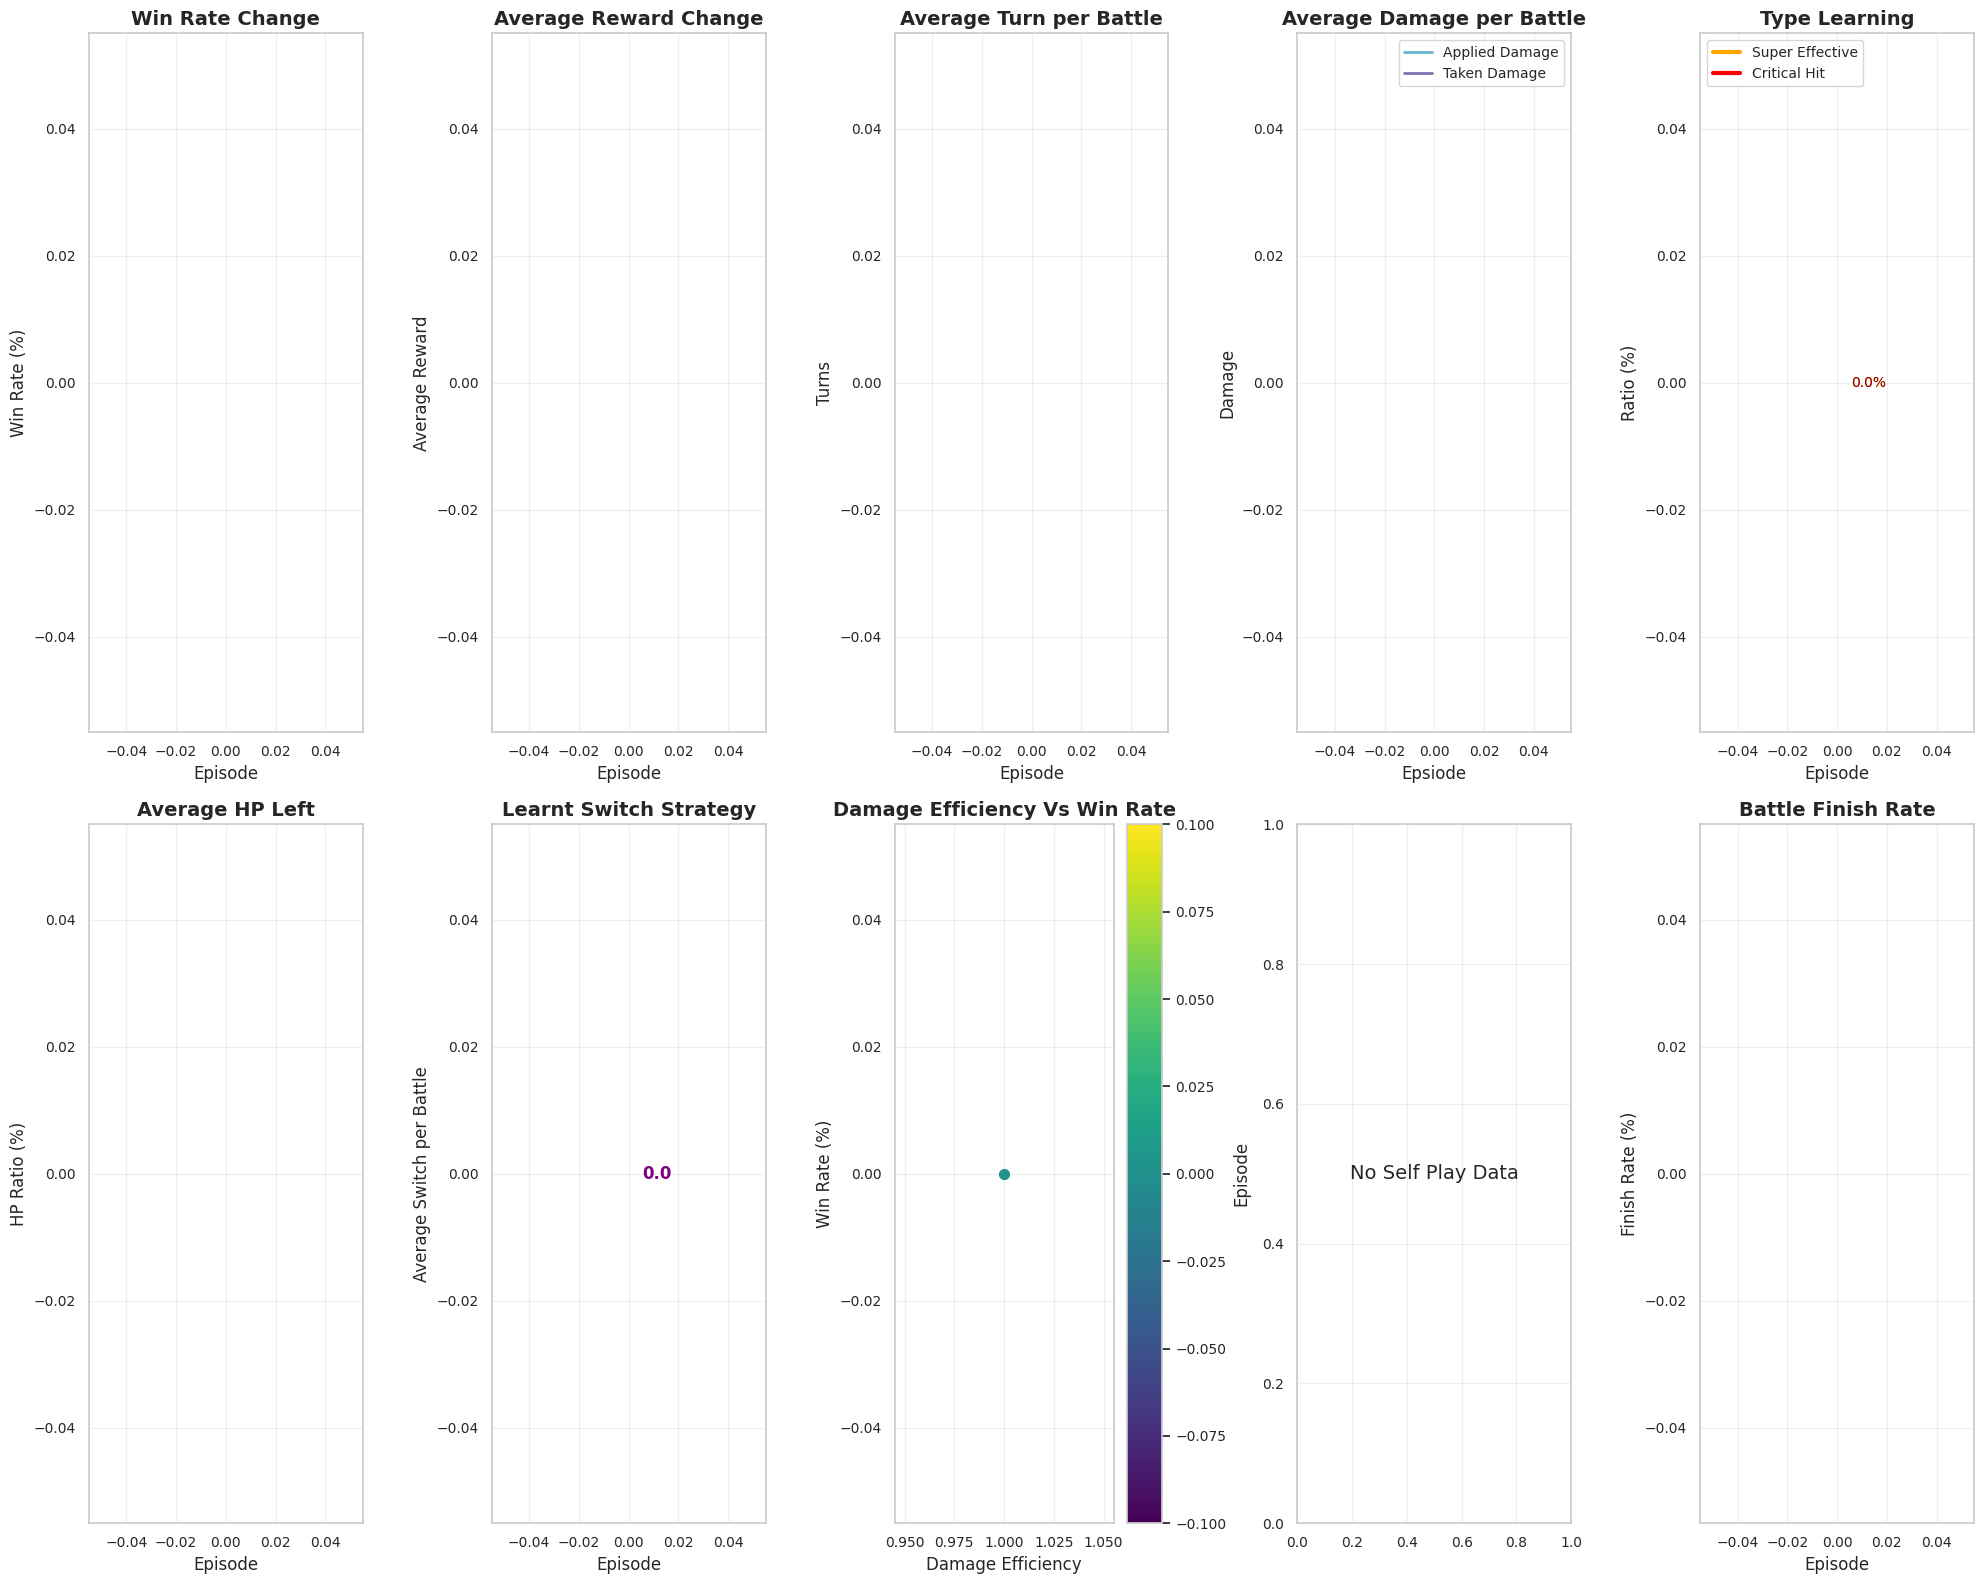


에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 24) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 24):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


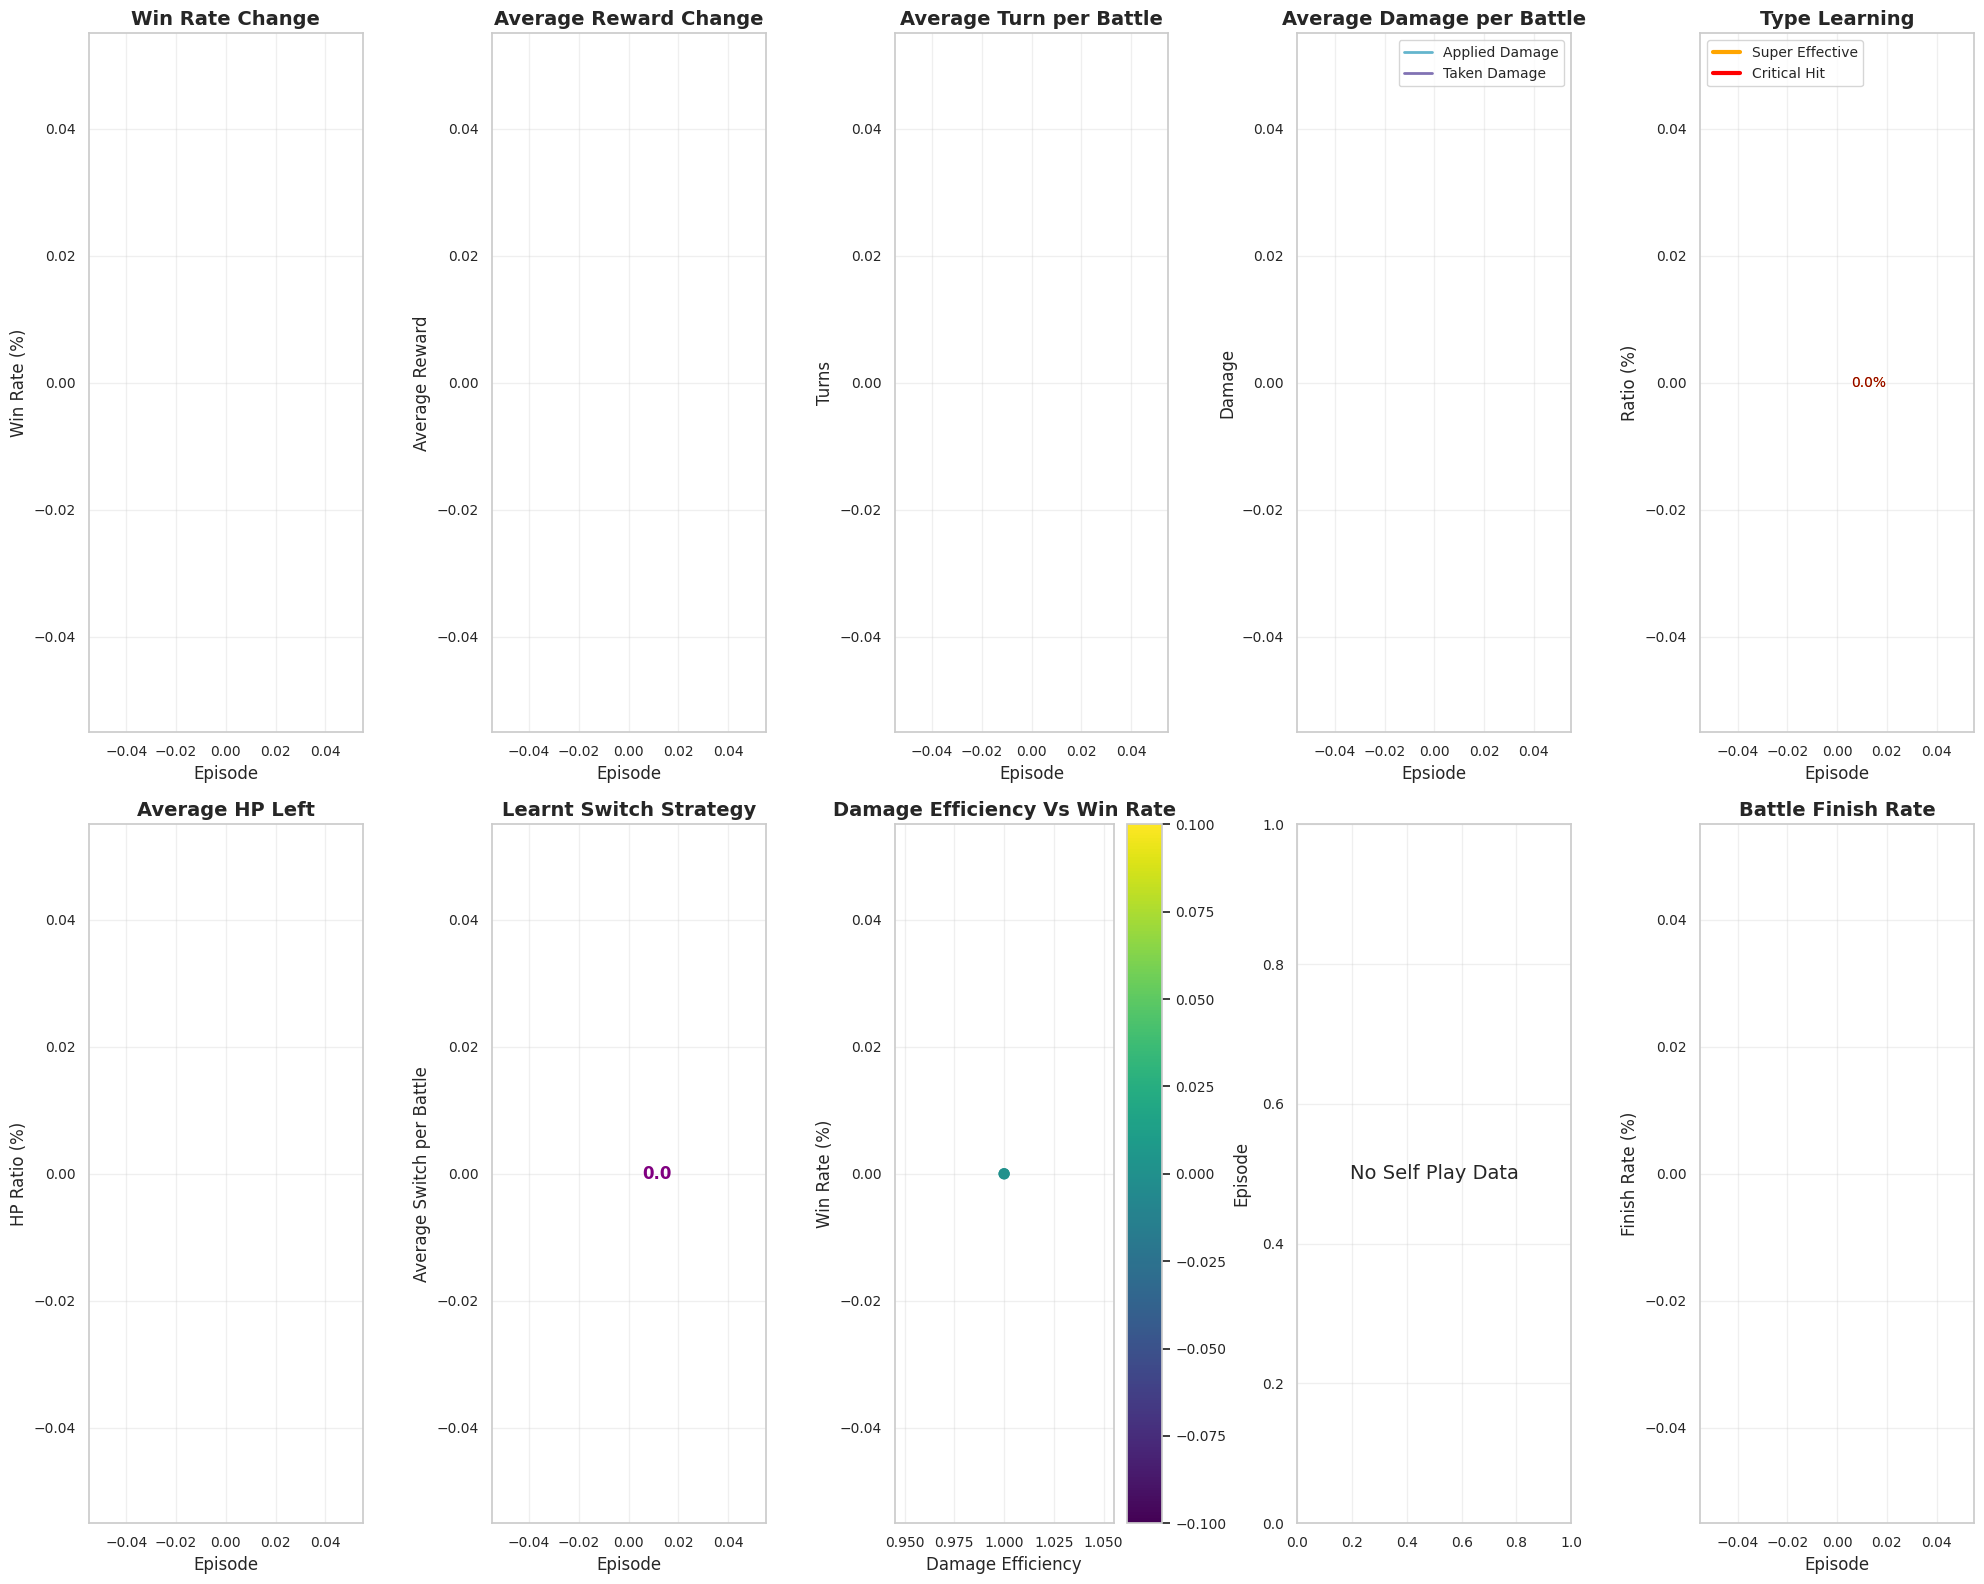


에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 40) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 40):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


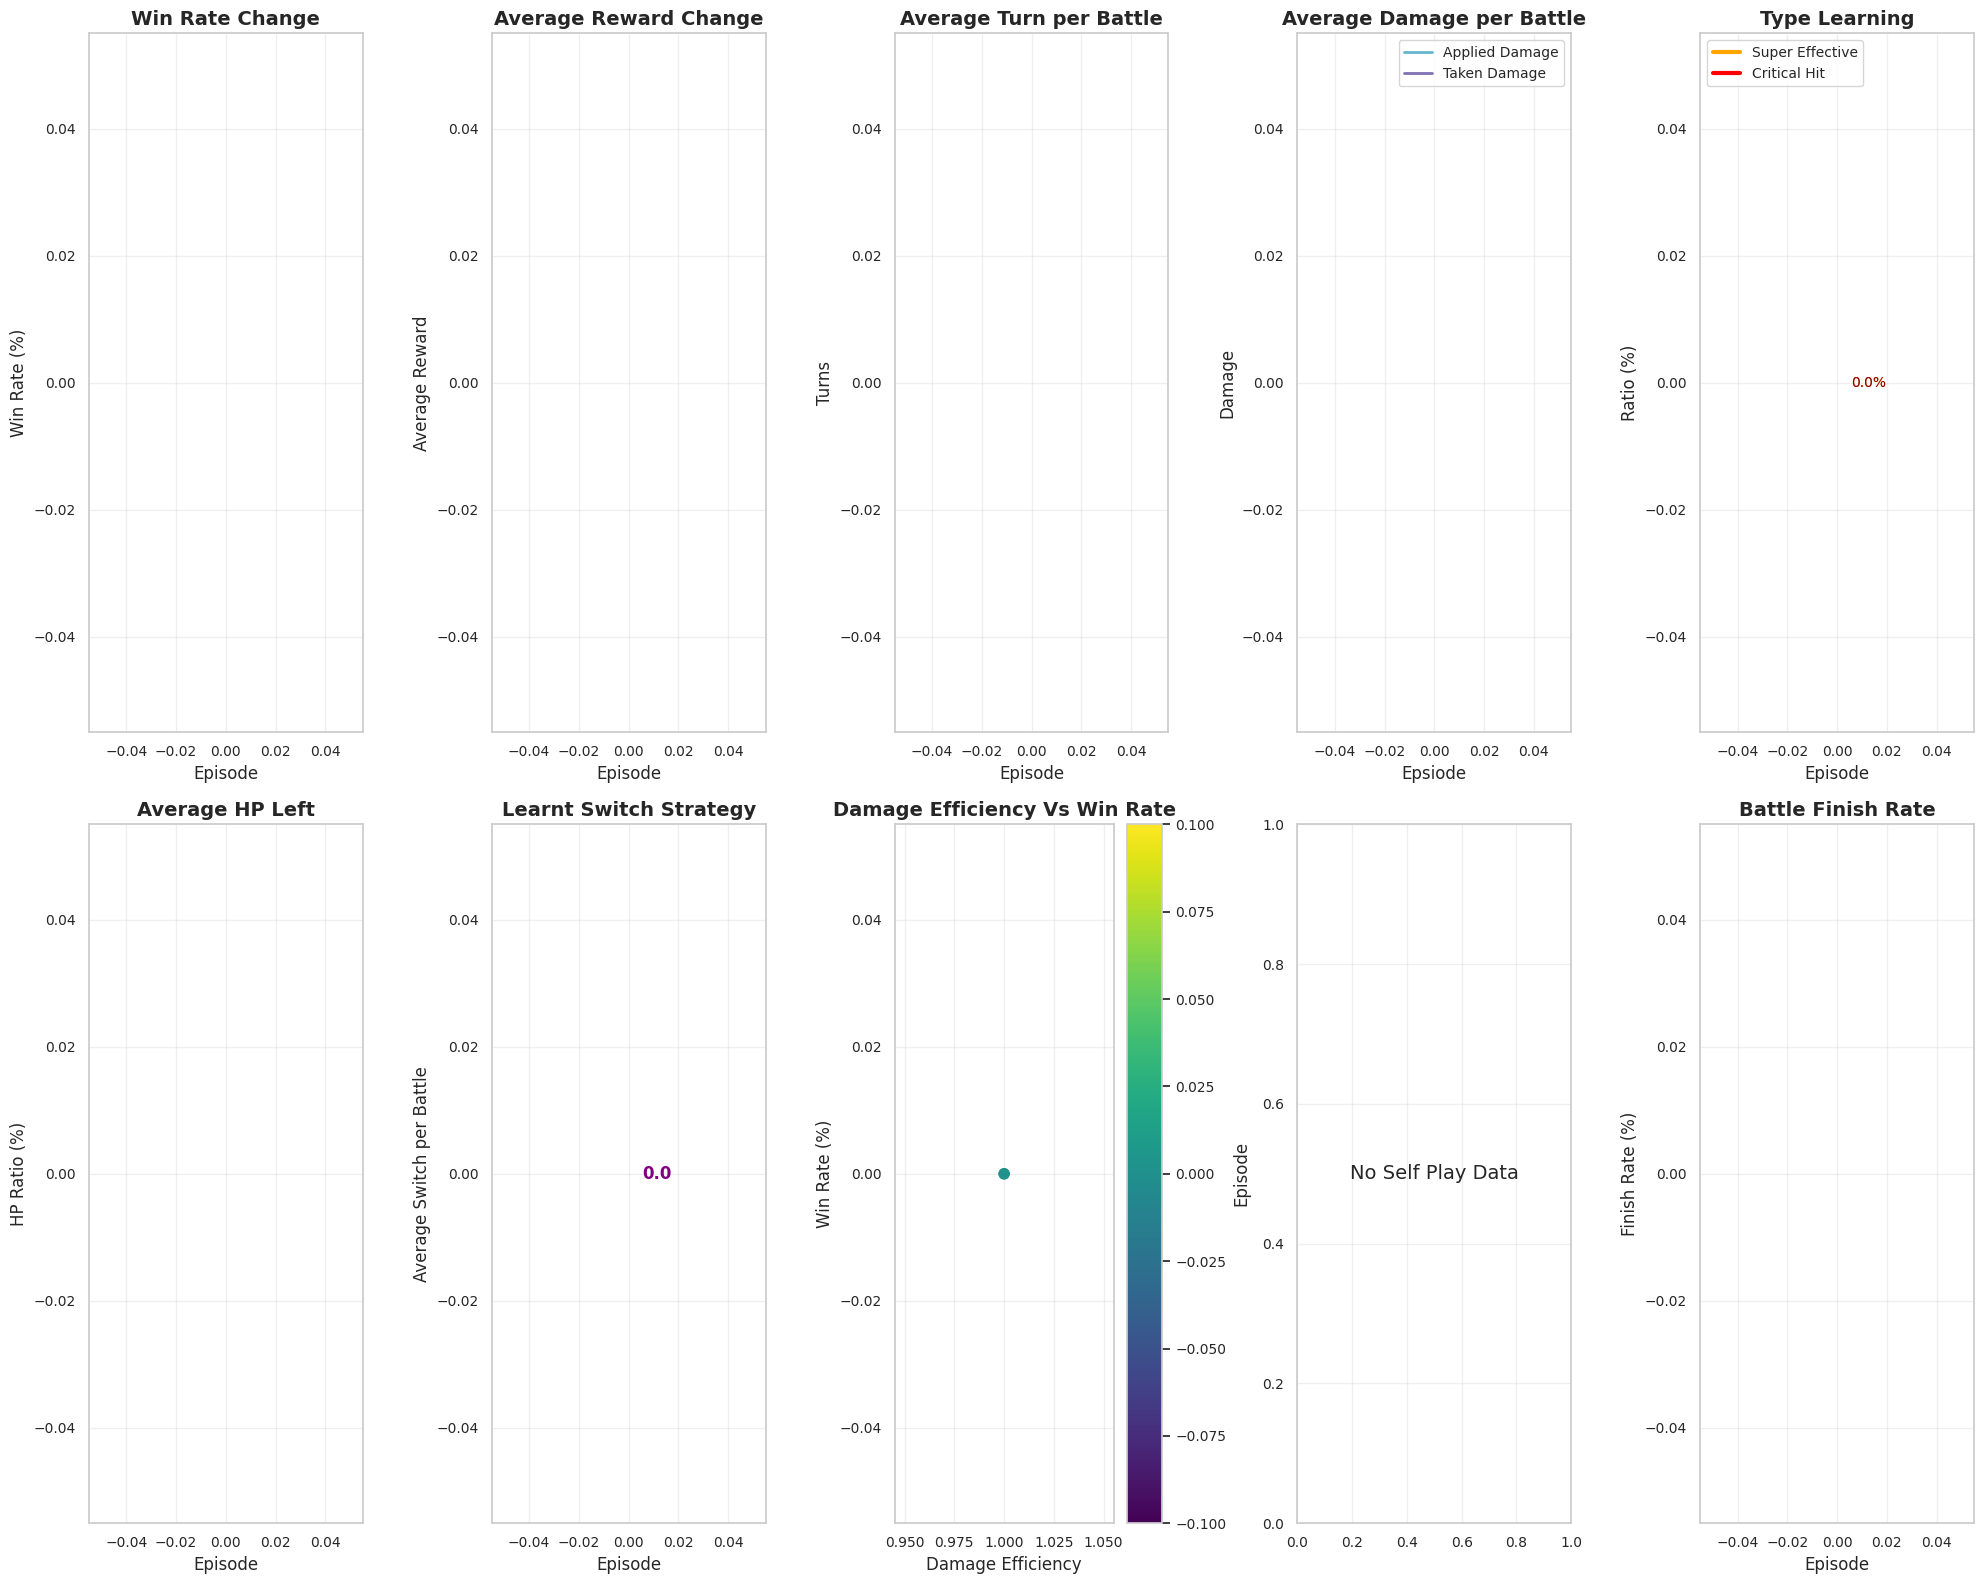


에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 56) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 56):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


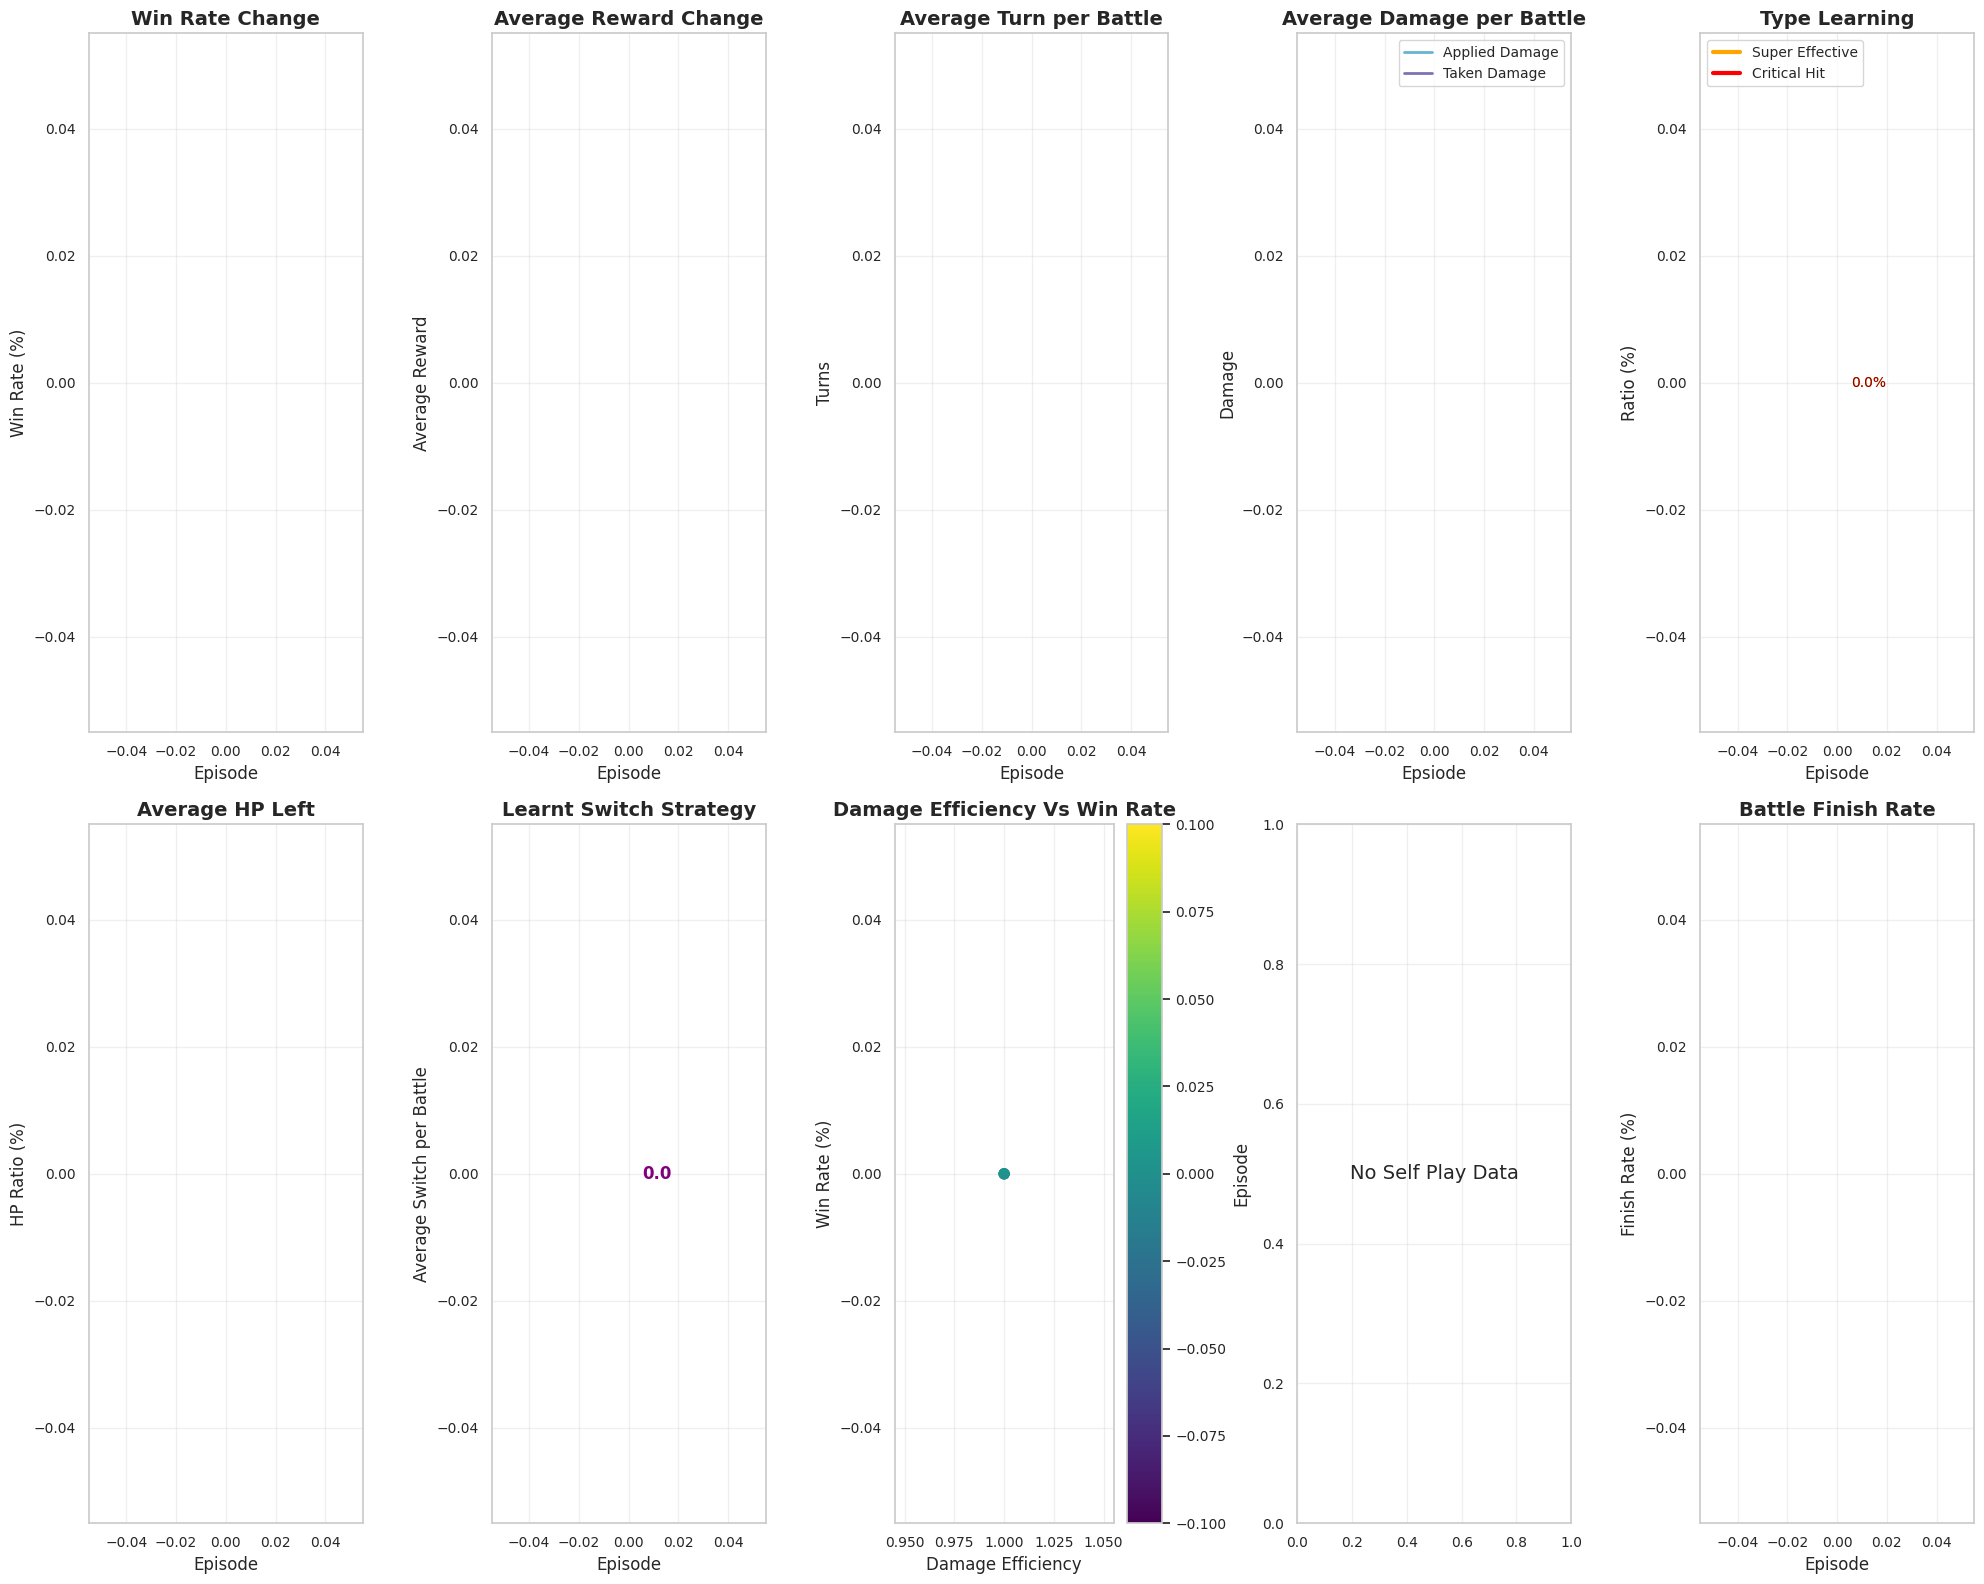

[07:40:09] 스텝: 56 | 에피소드: 0 | 최근 승률: 0.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0968 | 버퍼 크기: 1,032
에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 72) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 72):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


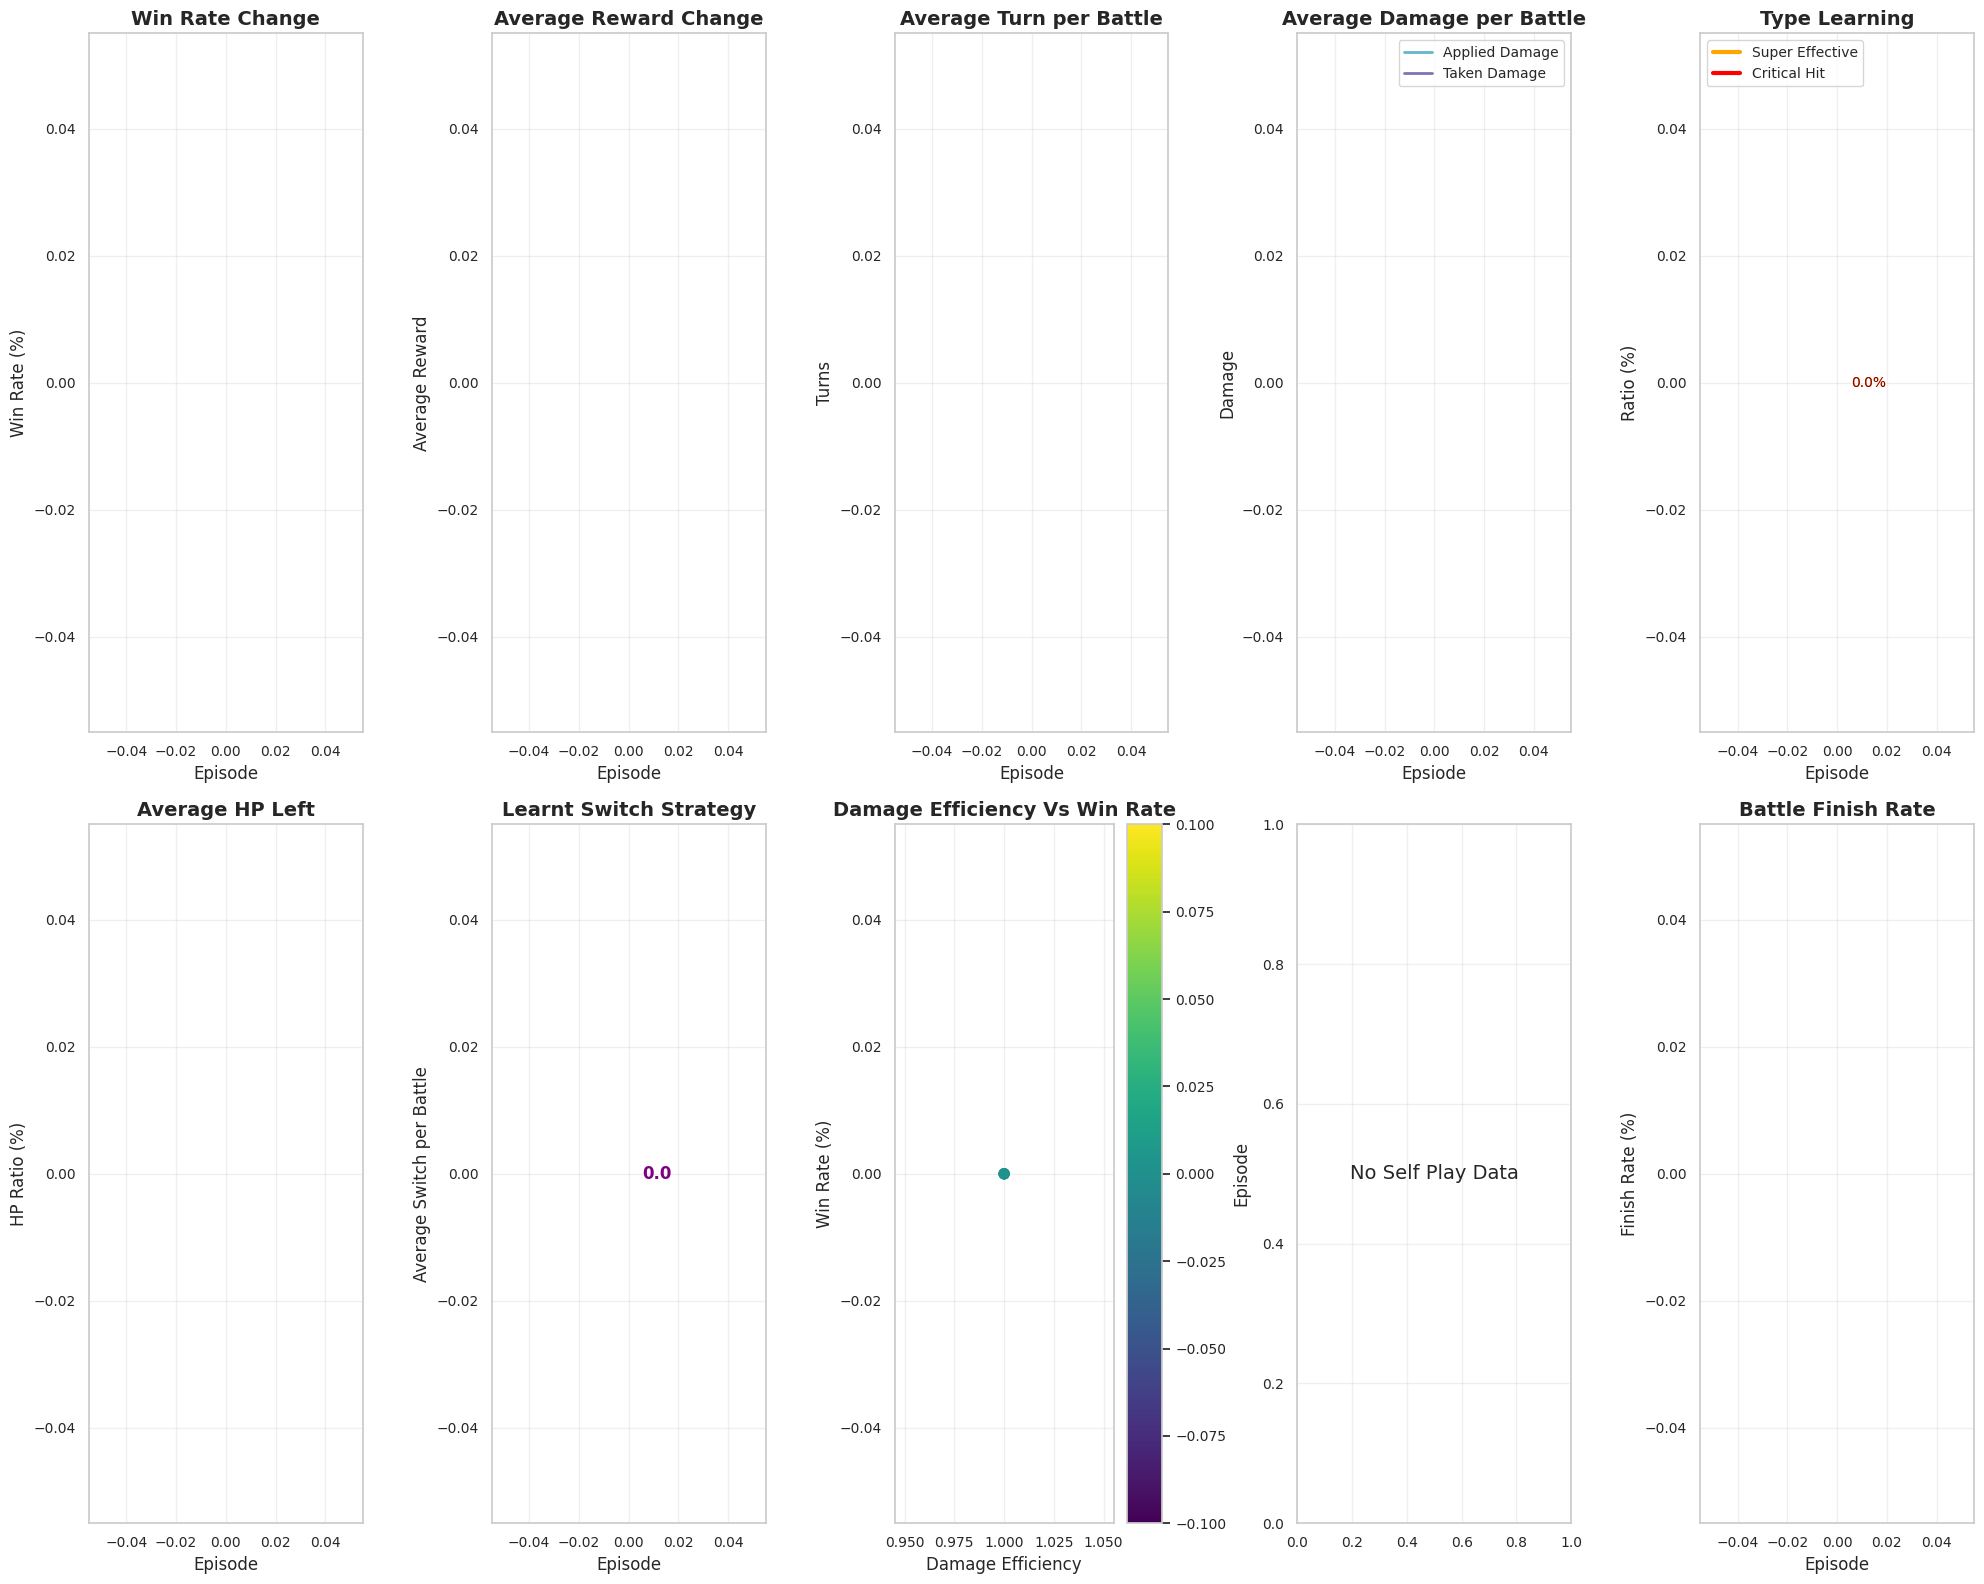


에피소드 0 평가 시작...

[평가 시작] 에피소드 0 (스텝 88) - 0 테스트 배틀

[평가 결과] 에피소드 0 (스텝 88):
  승률: 0.0% (0/0)
  평균 보상: 0.00
  평균 턴 수: 0.0
  공격 효율: 0.0 가한 데미지 vs 0.0 받은 데미지
  타입 상성 활용: 0.0% 효과적인 공격 비율
  급소 타격: 0.0% (총 0회)
  평균 교체 횟수: 0.0 (총 0회)
  평균 잔여 HP: 0.0%
  배틀 완료율: 0.0%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


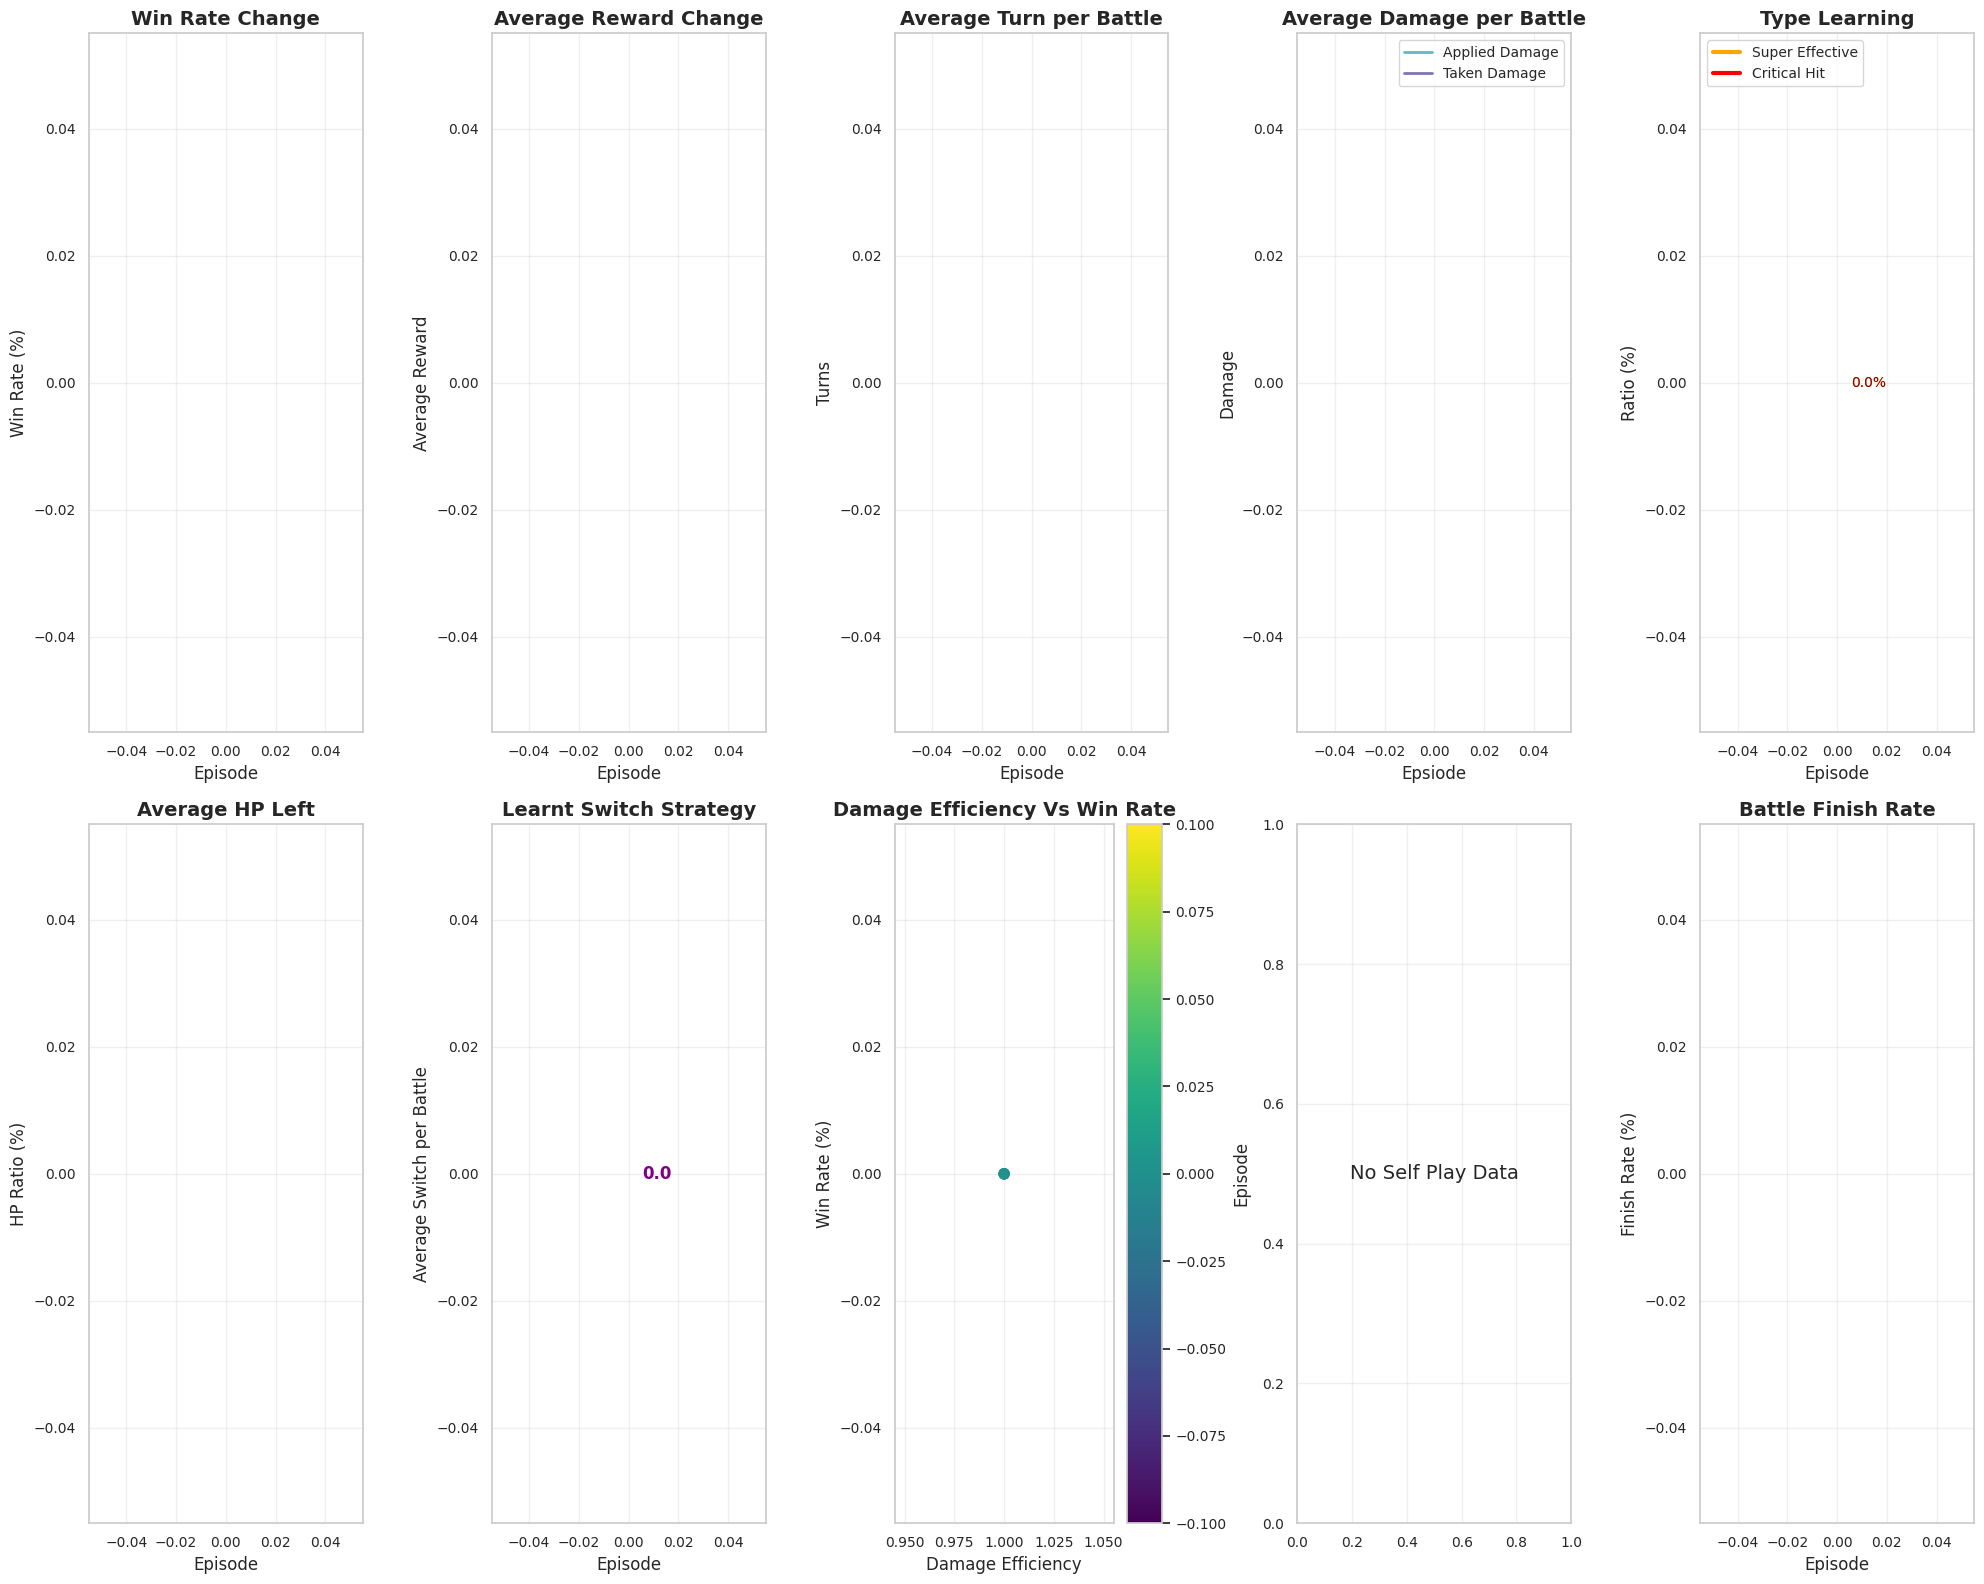

학습 진행 (에피소드):   0%|          | 9/2000 [01:02<1:32:52,  2.80s/it]

[07:40:40] 스텝: 264 | 에피소드: 9 | 최근 승률: 66.7% | 자가 대전: 비활성화 | 탐색률(ε): 0.0873 | 버퍼 크기: 1,136

학습 진행 (에피소드):   1%|          | 20/2000 [01:28<1:08:46,  2.08s/it]

[07:41:11] 스텝: 536 | 에피소드: 20 | 최근 승률: 50.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0762 | 버퍼 크기: 1,272

학습 진행 (에피소드):   2%|▏         | 33/2000 [02:03<1:18:35,  2.40s/it]

[07:41:42] 스텝: 808 | 에피소드: 33 | 최근 승률: 57.6% | 자가 대전: 비활성화 | 탐색률(ε): 0.0665 | 버퍼 크기: 1,408

학습 진행 (에피소드):   2%|▏         | 46/2000 [02:34<1:28:10,  2.71s/it]

[07:42:12] 스텝: 1,080 | 에피소드: 46 | 최근 승률: 52.2% | 자가 대전: 비활성화 | 탐색률(ε): 0.0580 | 버퍼 크기: 1,544

학습 진행 (에피소드):   3%|▎         | 54/2000 [02:57<1:25:32,  2.64s/it]

[07:42:43] 스텝: 1,352 | 에피소드: 54 | 최근 승률: 51.9% | 자가 대전: 비활성화 | 탐색률(ε): 0.0506 | 버퍼 크기: 1,680

학습 진행 (에피소드):   3%|▎         | 68/2000 [03:32<52:40,  1.64s/it]

[07:43:14] 스텝: 1,624 | 에피소드: 68 | 최근 승률: 48.5% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 1,816

학습 진행 (에피소드):   4%|▍         | 77/2000 [04:02<1:13:01,  2.28s/it]

[07:43:44] 스텝: 1,880 | 에피소드: 77 | 최근 승률: 49.4% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 1,944

학습 진행 (에피소드):   4%|▍         | 88/2000 [04:35<1:13:02,  2.29s/it]

[07:44:15] 스텝: 2,152 | 에피소드: 88 | 최근 승률: 50.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,080

학습 진행 (에피소드):   5%|▍         | 94/2000 [05:03<1:37:04,  3.06s/it]

[07:44:46] 스텝: 2,424 | 에피소드: 94 | 최근 승률: 53.2% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,216

학습 진행 (에피소드):   5%|▌         | 100/2000 [05:29<1:54:42,  3.62s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000100

에피소드 100 모델 저장 완료


학습 진행 (에피소드):   5%|▌         | 103/2000 [05:34<1:08:17,  2.16s/it]

[07:45:17] 스텝: 2,696 | 에피소드: 103 | 최근 승률: 51.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,352

학습 진행 (에피소드):   6%|▌         | 115/2000 [06:09<1:22:56,  2.64s/it]

[07:45:48] 스텝: 2,968 | 에피소드: 115 | 최근 승률: 53.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,488

학습 진행 (에피소드):   6%|▌         | 124/2000 [06:40<53:37,  1.72s/it]  

[07:46:19] 스텝: 3,224 | 에피소드: 124 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,616

학습 진행 (에피소드):   7%|▋         | 135/2000 [07:12<48:17,  1.55s/it]  

[07:46:50] 스텝: 3,496 | 에피소드: 135 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,752

학습 진행 (에피소드):   7%|▋         | 145/2000 [07:39<1:20:34,  2.61s/it]

[07:47:21] 스텝: 3,768 | 에피소드: 145 | 최근 승률: 56.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 2,888

학습 진행 (에피소드):   8%|▊         | 154/2000 [08:14<1:52:23,  3.65s/it]

[07:47:53] 스텝: 4,040 | 에피소드: 154 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,024

학습 진행 (에피소드):   8%|▊         | 169/2000 [08:45<1:36:08,  3.15s/it]

[07:48:24] 스텝: 4,312 | 에피소드: 169 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,160

학습 진행 (에피소드):   9%|▊         | 173/2000 [09:14<3:02:42,  6.00s/it]

[07:48:54] 스텝: 4,568 | 에피소드: 173 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,288

학습 진행 (에피소드):   9%|▉         | 183/2000 [09:45<1:46:12,  3.51s/it]

[07:49:25] 스텝: 4,824 | 에피소드: 183 | 최근 승률: 60.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,416

학습 진행 (에피소드):  10%|▉         | 194/2000 [10:16<55:15,  1.84s/it]  

[07:49:55] 스텝: 5,080 | 에피소드: 194 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,544

학습 진행 (에피소드):  10%|█         | 200/2000 [10:40<1:25:40,  2.86s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000200

에피소드 200 모델 저장 완료


학습 진행 (에피소드):  10%|█         | 201/2000 [10:44<1:34:39,  3.16s/it]

[07:50:26] 스텝: 5,352 | 에피소드: 201 | 최근 승률: 60.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,680

학습 진행 (에피소드):  11%|█         | 214/2000 [11:19<51:44,  1.74s/it]  

[07:50:58] 스텝: 5,624 | 에피소드: 214 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,816

학습 진행 (에피소드):  11%|█         | 222/2000 [11:47<1:19:06,  2.67s/it]

[07:51:28] 스텝: 5,880 | 에피소드: 222 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 3,944

학습 진행 (에피소드):  12%|█▏        | 231/2000 [12:21<1:54:34,  3.89s/it]

[07:51:59] 스텝: 6,136 | 에피소드: 231 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,072

학습 진행 (에피소드):  12%|█▏        | 242/2000 [12:49<1:17:14,  2.64s/it]

[07:52:29] 스텝: 6,392 | 에피소드: 242 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,200

학습 진행 (에피소드):  13%|█▎        | 251/2000 [13:21<1:21:07,  2.78s/it]

[07:53:01] 스텝: 6,664 | 에피소드: 251 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,336

학습 진행 (에피소드):  13%|█▎        | 259/2000 [13:47<1:11:19,  2.46s/it]

[07:53:31] 스텝: 6,936 | 에피소드: 259 | 최근 승률: 56.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,472

학습 진행 (에피소드):  13%|█▎        | 269/2000 [14:22<48:26,  1.68s/it]  

[07:54:01] 스텝: 7,192 | 에피소드: 269 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,600

학습 진행 (에피소드):  14%|█▍        | 282/2000 [14:55<1:13:53,  2.58s/it]

[07:54:33] 스텝: 7,448 | 에피소드: 282 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,728

학습 진행 (에피소드):  15%|█▍        | 294/2000 [15:26<56:51,  2.00s/it]  

[07:55:04] 스텝: 7,704 | 에피소드: 294 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,856

학습 진행 (에피소드):  15%|█▌        | 301/2000 [15:43<42:46,  1.51s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000300

에피소드 300 모델 저장 완료


학습 진행 (에피소드):  15%|█▌        | 307/2000 [15:56<46:59,  1.67s/it]  

[07:55:35] 스텝: 7,960 | 에피소드: 307 | 최근 승률: 57.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 4,984

학습 진행 (에피소드):  16%|█▌        | 317/2000 [16:27<1:37:59,  3.49s/it]

[07:56:06] 스텝: 8,216 | 에피소드: 317 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,112

학습 진행 (에피소드):  17%|█▋        | 331/2000 [16:58<1:37:50,  3.52s/it]

[07:56:38] 스텝: 8,488 | 에피소드: 331 | 최근 승률: 50.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,248

학습 진행 (에피소드):  17%|█▋        | 342/2000 [17:30<1:16:15,  2.76s/it]

[07:57:09] 스텝: 8,744 | 에피소드: 342 | 최근 승률: 50.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,376

학습 진행 (에피소드):  18%|█▊        | 355/2000 [18:00<58:50,  2.15s/it]

[07:57:39] 스텝: 8,984 | 에피소드: 355 | 최근 승률: 53.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,496

학습 진행 (에피소드):  18%|█▊        | 365/2000 [18:31<1:09:26,  2.55s/it]

[07:58:10] 스텝: 9,240 | 에피소드: 365 | 최근 승률: 53.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,624

학습 진행 (에피소드):  19%|█▊        | 373/2000 [18:59<1:10:58,  2.62s/it]

[07:58:40] 스텝: 9,496 | 에피소드: 373 | 최근 승률: 54.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,752

학습 진행 (에피소드):  19%|█▉        | 385/2000 [19:32<1:06:51,  2.48s/it]

[07:59:11] 스텝: 9,752 | 에피소드: 385 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 5,880

학습 진행 (에피소드):  20%|█▉        | 397/2000 [20:02<47:58,  1.80s/it]  

[07:59:42] 스텝: 10,024 | 에피소드: 397 | 최근 승률: 55.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,016

학습 진행 (에피소드):  20%|██        | 400/2000 [20:14<1:09:49,  2.62s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000400

에피소드 400 모델 저장 완료


학습 진행 (에피소드):  20%|██        | 406/2000 [20:35<1:16:34,  2.88s/it]

[08:00:13] 스텝: 10,264 | 에피소드: 406 | 최근 승률: 56.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,136

학습 진행 (에피소드):  21%|██        | 415/2000 [20:59<46:11,  1.75s/it]  

[08:00:45] 스텝: 10,520 | 에피소드: 415 | 최근 승률: 56.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,264

학습 진행 (에피소드):  21%|██        | 424/2000 [21:30<1:11:25,  2.72s/it]

[08:01:16] 스텝: 10,776 | 에피소드: 424 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,392

학습 진행 (에피소드):  22%|██▏       | 434/2000 [22:06<1:07:46,  2.60s/it]

[08:01:47] 스텝: 11,032 | 에피소드: 434 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,520

학습 진행 (에피소드):  22%|██▏       | 445/2000 [22:37<1:08:02,  2.63s/it]

[08:02:17] 스텝: 11,288 | 에피소드: 445 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,648

학습 진행 (에피소드):  23%|██▎       | 459/2000 [23:08<47:55,  1.87s/it]

[08:02:49] 스텝: 11,544 | 에피소드: 459 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,776

학습 진행 (에피소드):  24%|██▎       | 471/2000 [23:39<53:31,  2.10s/it]

[08:03:19] 스텝: 11,784 | 에피소드: 471 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 6,896

학습 진행 (에피소드):  24%|██▍       | 482/2000 [24:12<1:28:27,  3.50s/it]

[08:03:50] 스텝: 12,040 | 에피소드: 482 | 최근 승률: 56.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,024

학습 진행 (에피소드):  25%|██▍       | 493/2000 [24:43<1:15:23,  3.00s/it]

[08:04:22] 스텝: 12,296 | 에피소드: 493 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,152

학습 진행 (에피소드):  25%|██▌       | 501/2000 [25:08<39:29,  1.58s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000500

에피소드 500 모델 저장 완료


학습 진행 (에피소드):  25%|██▌       | 502/2000 [25:09<35:19,  1.42s/it]

[08:04:52] 스텝: 12,552 | 에피소드: 502 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,280

학습 진행 (에피소드):  26%|██▌       | 516/2000 [25:45<44:47,  1.81s/it]

[08:05:24] 스텝: 12,824 | 에피소드: 516 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,416

학습 진행 (에피소드):  26%|██▋       | 527/2000 [26:14<53:56,  2.20s/it]  

[08:05:55] 스텝: 13,064 | 에피소드: 527 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,536

학습 진행 (에피소드):  27%|██▋       | 537/2000 [26:46<1:15:52,  3.11s/it]

[08:06:25] 스텝: 13,304 | 에피소드: 537 | 최근 승률: 58.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,656

학습 진행 (에피소드):  28%|██▊       | 550/2000 [27:17<48:08,  1.99s/it]

[08:06:56] 스텝: 13,560 | 에피소드: 550 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,784

학습 진행 (에피소드):  28%|██▊       | 561/2000 [27:42<35:02,  1.46s/it]

[08:07:26] 스텝: 13,816 | 에피소드: 561 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 7,912

학습 진행 (에피소드):  29%|██▊       | 572/2000 [28:16<1:14:44,  3.14s/it]

[08:07:57] 스텝: 14,072 | 에피소드: 572 | 최근 승률: 69.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,040

학습 진행 (에피소드):  29%|██▉       | 585/2000 [28:49<55:08,  2.34s/it]  

[08:08:28] 스텝: 14,328 | 에피소드: 585 | 최근 승률: 65.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,168

학습 진행 (에피소드):  30%|██▉       | 596/2000 [29:21<1:09:05,  2.95s/it]

[08:08:59] 스텝: 14,568 | 에피소드: 596 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,288

학습 진행 (에피소드):  30%|███       | 600/2000 [29:40<1:41:47,  4.36s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000600

에피소드 600 모델 저장 완료


학습 진행 (에피소드):  30%|███       | 603/2000 [29:52<1:48:53,  4.68s/it]

[08:09:31] 스텝: 14,824 | 에피소드: 603 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,416

학습 진행 (에피소드):  31%|███       | 615/2000 [30:24<1:12:44,  3.15s/it]

[08:10:02] 스텝: 15,096 | 에피소드: 615 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,552

학습 진행 (에피소드):  31%|███▏      | 625/2000 [30:54<1:24:49,  3.70s/it]

[08:10:32] 스텝: 15,352 | 에피소드: 625 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,680

학습 진행 (에피소드):  32%|███▏      | 635/2000 [31:22<55:29,  2.44s/it]  

[08:11:04] 스텝: 15,624 | 에피소드: 635 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,816

학습 진행 (에피소드):  32%|███▏      | 647/2000 [31:57<1:00:55,  2.70s/it]

[08:11:35] 스텝: 15,864 | 에피소드: 647 | 최근 승률: 60.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 8,936

학습 진행 (에피소드):  33%|███▎      | 659/2000 [32:28<39:06,  1.75s/it]

[08:12:07] 스텝: 16,120 | 에피소드: 659 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,064

학습 진행 (에피소드):  33%|███▎      | 669/2000 [32:59<1:38:15,  4.43s/it]

[08:12:38] 스텝: 16,376 | 에피소드: 669 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,192

학습 진행 (에피소드):  34%|███▍      | 683/2000 [33:30<46:44,  2.13s/it]

[08:13:08] 스텝: 16,632 | 에피소드: 683 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,320

학습 진행 (에피소드):  35%|███▍      | 691/2000 [33:59<1:02:30,  2.87s/it]

[08:13:40] 스텝: 16,904 | 에피소드: 691 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,456

학습 진행 (에피소드):  35%|███▌      | 700/2000 [34:18<41:51,  1.93s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000700

에피소드 700 모델 저장 완료


학습 진행 (에피소드):  35%|███▌      | 703/2000 [34:34<1:37:51,  4.53s/it]

[08:14:12] 스텝: 17,160 | 에피소드: 703 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,584

학습 진행 (에피소드):  36%|███▌      | 712/2000 [35:05<1:13:38,  3.43s/it]

[08:14:43] 스텝: 17,400 | 에피소드: 712 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,704

학습 진행 (에피소드):  36%|███▋      | 725/2000 [35:35<50:16,  2.37s/it]

[08:15:14] 스텝: 17,656 | 에피소드: 725 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,832

학습 진행 (에피소드):  37%|███▋      | 737/2000 [36:06<48:26,  2.30s/it]

[08:15:45] 스텝: 17,912 | 에피소드: 737 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 9,960

학습 진행 (에피소드):  37%|███▋      | 745/2000 [36:34<1:33:50,  4.49s/it]

[08:16:15] 스텝: 18,168 | 에피소드: 745 | 최근 승률: 60.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  38%|███▊      | 757/2000 [37:09<58:43,  2.83s/it]  

[08:16:48] 스텝: 18,440 | 에피소드: 757 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  38%|███▊      | 766/2000 [37:38<52:05,  2.53s/it]

[08:17:19] 스텝: 18,680 | 에피소드: 766 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  39%|███▊      | 773/2000 [38:08<1:01:00,  2.98s/it]

[08:17:49] 스텝: 18,920 | 에피소드: 773 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  39%|███▉      | 782/2000 [38:42<1:19:18,  3.91s/it]

[08:18:20] 스텝: 19,176 | 에피소드: 782 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  40%|███▉      | 791/2000 [39:12<1:21:39,  4.05s/it]

[08:18:51] 스텝: 19,432 | 에피소드: 791 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  40%|████      | 800/2000 [39:37<1:08:40,  3.43s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000800

에피소드 800 모델 저장 완료


학습 진행 (에피소드):  40%|████      | 801/2000 [39:40<1:06:51,  3.35s/it]

[08:19:21] 스텝: 19,688 | 에피소드: 801 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  41%|████      | 814/2000 [40:15<44:47,  2.27s/it]  

[08:19:53] 스텝: 19,944 | 에피소드: 814 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  41%|████      | 822/2000 [40:43<1:11:02,  3.62s/it]

[08:20:24] 스텝: 20,184 | 에피소드: 822 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  42%|████▏     | 833/2000 [41:15<45:05,  2.32s/it]  

[08:20:55] 스텝: 20,440 | 에피소드: 833 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  42%|████▏     | 848/2000 [41:48<46:12,  2.41s/it]  

[08:21:26] 스텝: 20,696 | 에피소드: 848 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  43%|████▎     | 857/2000 [42:16<1:17:02,  4.04s/it]

[08:21:56] 스텝: 20,952 | 에피소드: 857 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  44%|████▎     | 870/2000 [42:49<42:54,  2.28s/it]

[08:22:27] 스텝: 21,208 | 에피소드: 870 | 최근 승률: 62.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  44%|████▍     | 883/2000 [43:17<45:36,  2.45s/it]

[08:22:58] 스텝: 21,448 | 에피소드: 883 | 최근 승률: 66.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  45%|████▍     | 897/2000 [43:50<35:51,  1.95s/it]

[08:23:28] 스텝: 21,688 | 에피소드: 897 | 최근 승률: 66.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  45%|████▌     | 900/2000 [44:03<59:33,  3.25s/it]  

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_000900

에피소드 900 모델 저장 완료


학습 진행 (에피소드):  45%|████▌     | 908/2000 [44:22<44:41,  2.46s/it]

[08:24:00] 스텝: 21,944 | 에피소드: 908 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  46%|████▌     | 918/2000 [44:49<43:46,  2.43s/it]

[08:24:31] 스텝: 22,200 | 에피소드: 918 | 최근 승률: 65.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  46%|████▋     | 930/2000 [45:18<29:03,  1.63s/it]

[08:25:01] 스텝: 22,456 | 에피소드: 930 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  47%|████▋     | 942/2000 [45:54<50:20,  2.86s/it]

[08:25:32] 스텝: 22,712 | 에피소드: 942 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  48%|████▊     | 954/2000 [46:23<21:30,  1.23s/it]

[08:26:04] 스텝: 22,952 | 에피소드: 954 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  48%|████▊     | 963/2000 [46:55<1:07:34,  3.91s/it]

[08:26:34] 스텝: 23,192 | 에피소드: 963 | 최근 승률: 60.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  49%|████▉     | 978/2000 [47:26<30:48,  1.81s/it]

[08:27:05] 스텝: 23,448 | 에피소드: 978 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  49%|████▉     | 988/2000 [47:56<37:44,  2.24s/it]

[08:27:35] 스텝: 23,704 | 에피소드: 988 | 최근 승률: 59.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  50%|█████     | 1000/2000 [48:27<40:12,  2.41s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_001000

에피소드 1000 모델 저장 완료

에피소드 1000 평가 시작...

[평가 시작] 에피소드 1,000 (스텝 23,976) - 10 테스트 배틀

새로운 최고 승률 모델! 승률: 63.6%, 에피소드: 1000

[평가 결과] 에피소드 1,000 (스텝 23,976):
  승률: 63.6% (7/10)
  평균 보상: 14.04
  평균 턴 수: 9.9
  공격 효율: 420.1 가한 데미지 vs 292.2 받은 데미지
  타입 상성 활용: 38.9% 효과적인 공격 비율
  급소 타격: 1.1% (총 1회)
  평균 교체 횟수: 1.7 (총 19회)
  평균 잔여 HP: 26.4%
  배틀 완료율: 90.9%
최고 성능 모델 플롯 저장: ./pokemon_rl_evaluation/best_model_plot_20250409_073937.png


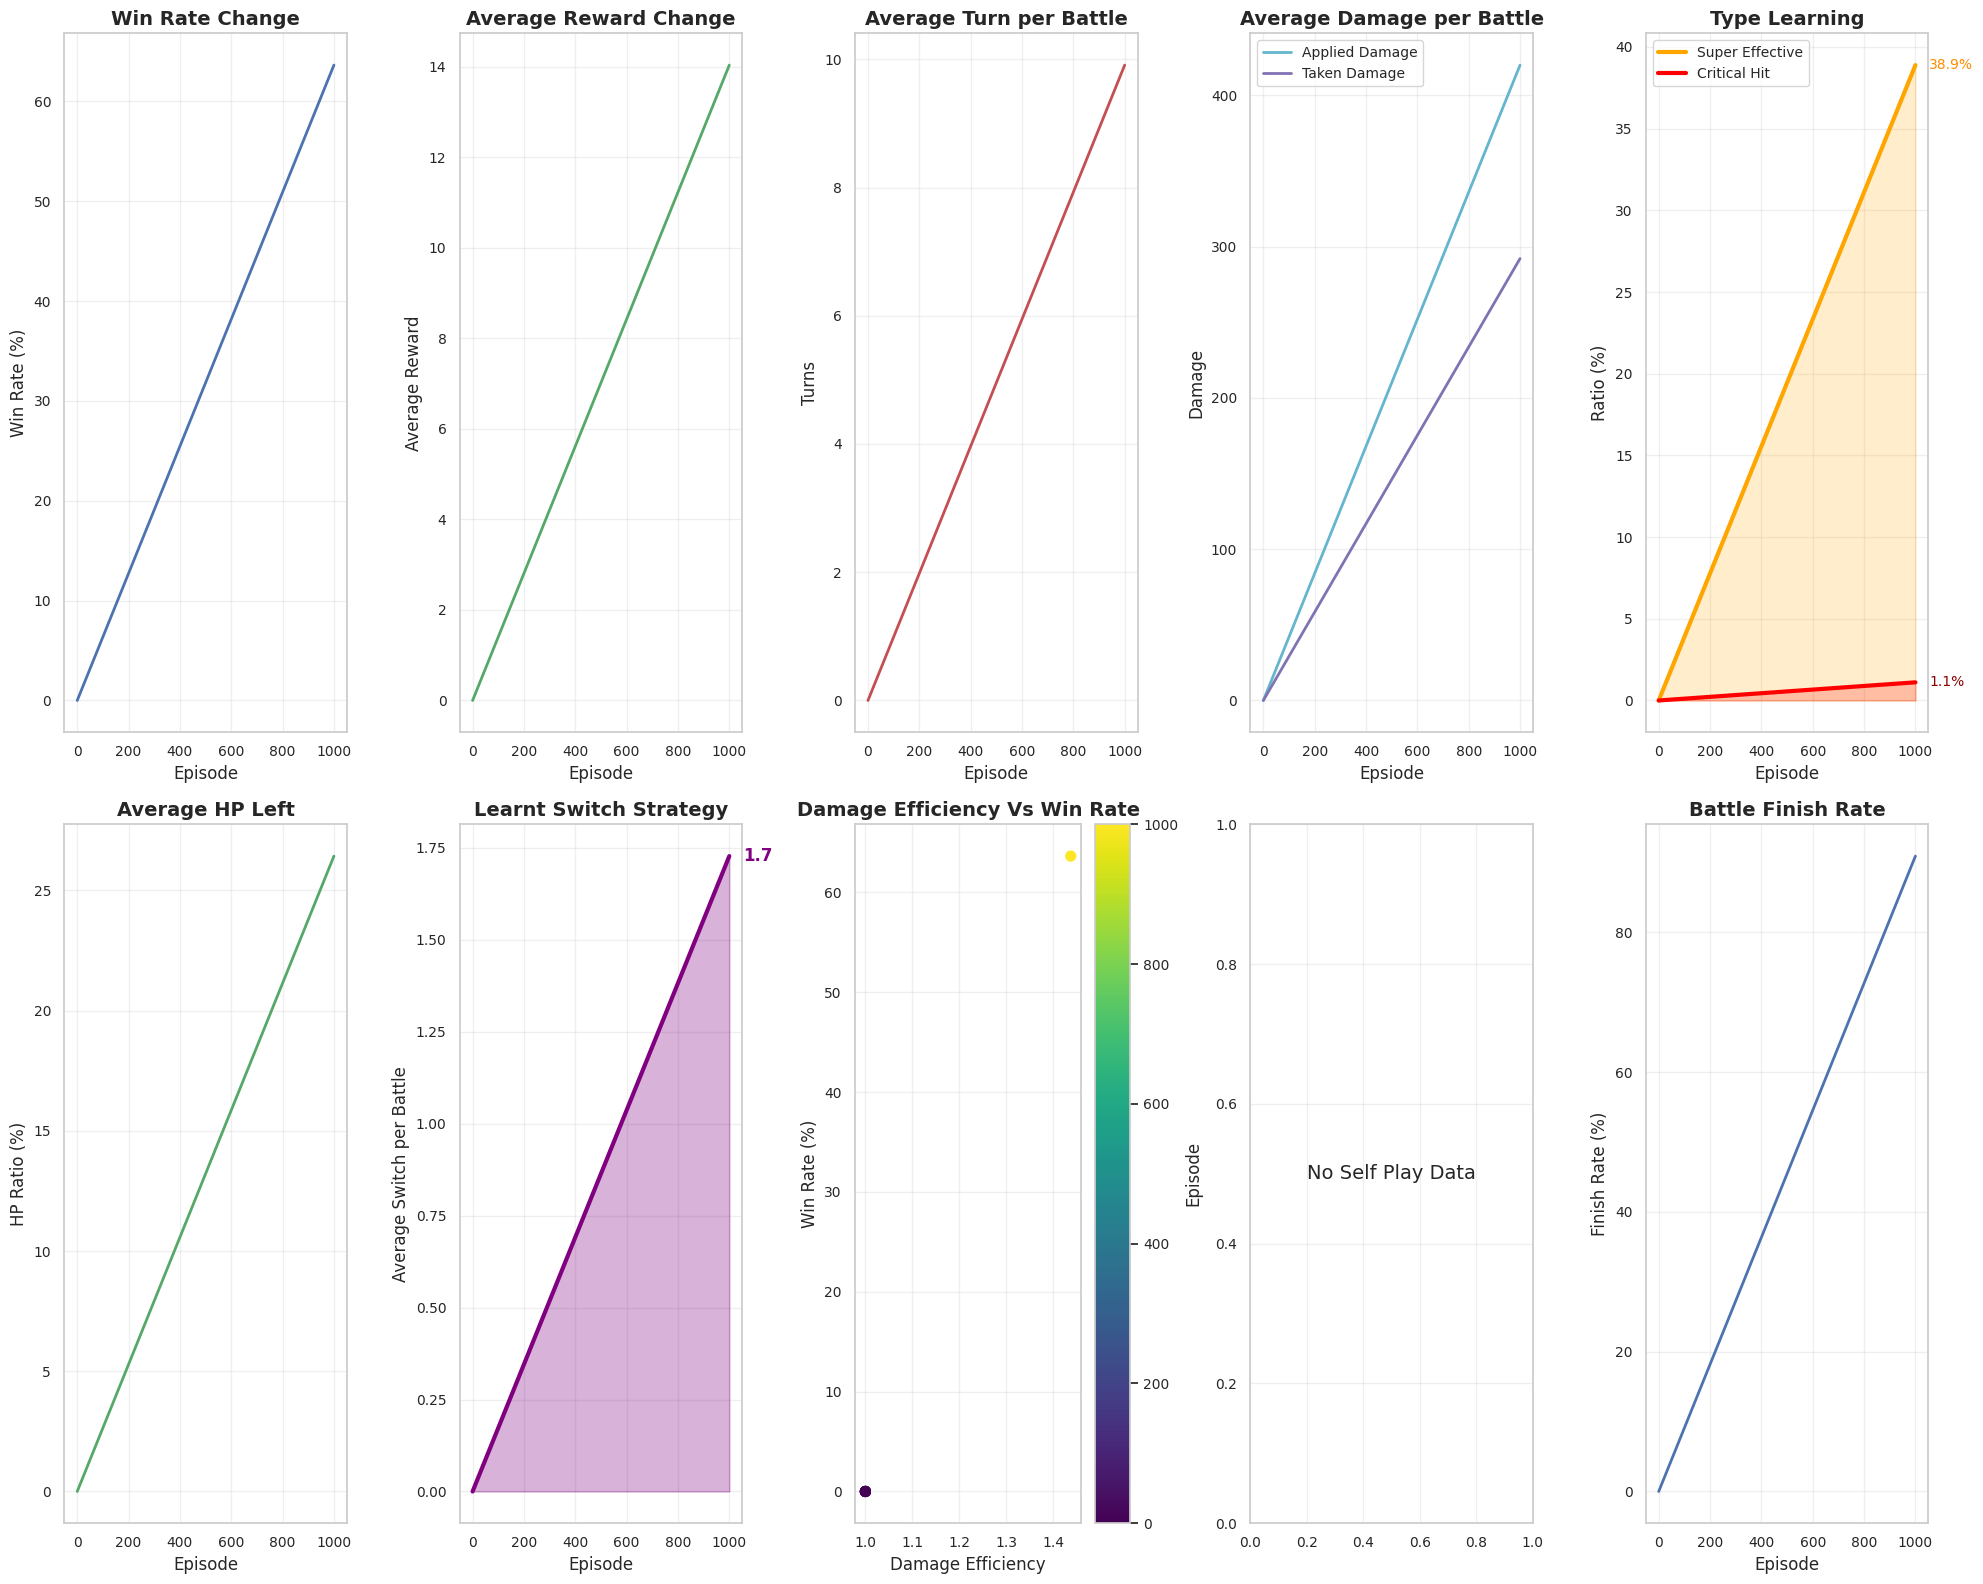

최고 성능 모델 저장 완료: ./pokemon_best_models/best_pokemon_agent_ep_001000_winrate_63.6
최고 승률 63.6% 모델 저장 완료!
[08:28:26] 스텝: 23,976 | 에피소드: 1,000 | 최근 승률: 57.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  50%|█████     | 1010/2000 [49:12<50:53,  3.08s/it]  

[08:28:57] 스텝: 24,216 | 에피소드: 1,010 | 최근 승률: 61.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  51%|█████     | 1023/2000 [49:50<44:23,  2.73s/it]

[08:29:28] 스텝: 24,472 | 에피소드: 1,023 | 최근 승률: 63.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  52%|█████▏    | 1036/2000 [50:20<36:53,  2.30s/it]

[08:30:00] 스텝: 24,728 | 에피소드: 1,036 | 최근 승률: 64.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  52%|█████▏    | 1047/2000 [50:50<1:05:58,  4.15s/it]

[08:30:31] 스텝: 24,968 | 에피소드: 1,047 | 최근 승률: 70.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  53%|█████▎    | 1059/2000 [51:20<31:44,  2.02s/it]

[08:31:02] 스텝: 25,224 | 에피소드: 1,059 | 최근 승률: 69.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  54%|█████▎    | 1072/2000 [51:54<32:49,  2.12s/it]

[08:31:33] 스텝: 25,480 | 에피소드: 1,072 | 최근 승률: 69.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  54%|█████▍    | 1082/2000 [52:25<43:48,  2.86s/it]

[08:32:04] 스텝: 25,736 | 에피소드: 1,082 | 최근 승률: 66.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  55%|█████▍    | 1096/2000 [52:56<34:59,  2.32s/it]

[08:32:35] 스텝: 26,008 | 에피소드: 1,096 | 최근 승률: 68.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  55%|█████▌    | 1101/2000 [53:06<26:47,  1.79s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_001100

에피소드 1100 모델 저장 완료


학습 진행 (에피소드):  55%|█████▌    | 1108/2000 [53:22<26:11,  1.76s/it]

[08:33:06] 스텝: 26,248 | 에피소드: 1,108 | 최근 승률: 70.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  56%|█████▌    | 1120/2000 [53:56<40:13,  2.74s/it]

[08:33:36] 스텝: 26,488 | 에피소드: 1,120 | 최근 승률: 68.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  57%|█████▋    | 1134/2000 [54:29<27:50,  1.93s/it]

[08:34:07] 스텝: 26,744 | 에피소드: 1,134 | 최근 승률: 67.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  57%|█████▋    | 1142/2000 [54:47<29:19,  2.05s/it]

[08:34:38] 스텝: 27,000 | 에피소드: 1,142 | 최근 승률: 65.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  58%|█████▊    | 1157/2000 [55:30<26:29,  1.89s/it]

[08:35:08] 스텝: 27,256 | 에피소드: 1,157 | 최근 승률: 65.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  58%|█████▊    | 1164/2000 [55:55<41:36,  2.99s/it]

[08:35:40] 스텝: 27,528 | 에피소드: 1,164 | 최근 승률: 69.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  59%|█████▉    | 1178/2000 [56:32<35:06,  2.56s/it]

[08:36:10] 스텝: 27,752 | 에피소드: 1,178 | 최근 승률: 69.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  59%|█████▉    | 1187/2000 [56:55<27:57,  2.06s/it]

[08:36:40] 스텝: 27,992 | 에피소드: 1,187 | 최근 승률: 70.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  60%|██████    | 1200/2000 [57:27<21:55,  1.64s/it]

일반 모델 저장 완료: ./pokemon_dqn_models/pokemon_battle_agent_ep_001200

에피소드 1200 모델 저장 완료


학습 진행 (에피소드):  60%|██████    | 1204/2000 [57:33<17:16,  1.30s/it]

[08:37:12] 스텝: 28,248 | 에피소드: 1,204 | 최근 승률: 65.0% | 자가 대전: 비활성화 | 탐색률(ε): 0.0500 | 버퍼 크기: 10,000

학습 진행 (에피소드):  60%|██████    | 1209/2000 [57:45<21:42,  1.65s/it]

In [ ]:
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque
import time
from tqdm import tqdm
from datetime import datetime
import json
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

# 모델 및 평가 결과를 위한 디렉토리 생성
EVAL_DIR = './pokemon_rl_evaluation'
os.makedirs(EVAL_DIR, exist_ok=True)

MODEL_PATH = './pokemon_dqn_models'
os.makedirs(MODEL_PATH, exist_ok=True)

# 최고 성능 모델 저장을 위한 디렉토리
BEST_MODEL_PATH = './pokemon_best_models'
os.makedirs(BEST_MODEL_PATH, exist_ok=True)

def subtract_mean(x):
    """명시적으로 정의된 평균 차감 함수"""
    return x - K.mean(x, axis=1, keepdims=True)

# 커스텀 객체 등록
get_custom_objects().update({'subtract_mean': subtract_mean})

def create_selfplay_teams(fixed_team=None, randomize_order=True):
    """
    자가 대전을 위한 동일한 팀 생성
    fixed_team이 None이면 새 팀 생성, 그렇지 않으면 제공된 팀 복제
    randomize_order가 True면 포켓몬 순서를 무작위화
    """
    if fixed_team is None:
        # 첫 호출 시 고정 팀 생성
        fixed_team = create_fixed_team()

    # 포켓몬 템플릿 목록
    pokemon_list = [
        create_pokemon_from_template(next(p for p in POKEMON_TEMPLATES if p["name"] == pokemon.name))
        for pokemon in fixed_team.pokemons
    ]

    # 필요시 순서 무작위화
    if randomize_order:
        random.shuffle(pokemon_list)

    # 플레이어와 상대 팀 생성
    player_team = PokemonTeam(pokemon_list)

    # 상대 팀도 동일한 포켓몬으로 구성하되, 다시 순서 무작위화
    opponent_list = [
        create_pokemon_from_template(next(p for p in POKEMON_TEMPLATES if p["name"] == pokemon.name))
        for pokemon in fixed_team.pokemons
    ]

    if randomize_order:
        random.shuffle(opponent_list)

    opponent_team = PokemonTeam(opponent_list)

    return player_team, opponent_team

class ReplayBuffer:
    """우선순위 샘플링이 있는 경험 재생 버퍼"""

    def __init__(self, max_size=200000, alpha=0.6):
        self.buffer = deque(maxlen=max_size)
        self.priorities = deque(maxlen=max_size)
        self.alpha = alpha  # 우선순위 인자 (0: 무작위 샘플링, 1: 완전 우선순위)

    def add(self, state, action, reward, next_state, done):
        """경험을 버퍼에 추가"""
        # 새 경험에 최대 우선순위 할당
        max_priority = max(self.priorities) if self.priorities else 1.0

        self.buffer.append((state, action, reward, next_state, done))
        self.priorities.append(max_priority)

    def sample(self, batch_size):
        """우선순위 기반 배치 샘플링"""
        batch_size = min(batch_size, len(self.buffer))

        # 우선순위 계산
        if self.alpha == 0:
            # 표준 무작위 샘플링
            indices = np.random.choice(len(self.buffer), batch_size)
        else:
            # 우선순위 기반 샘플링
            priorities = np.array(self.priorities) ** self.alpha
            probabilities = priorities / sum(priorities)
            indices = np.random.choice(len(self.buffer), batch_size, p=probabilities)

        # 배치 데이터 추출
        states = []
        actions = []
        rewards = []
        next_states = []
        dones = []

        for i in indices:
            state, action, reward, next_state, done = self.buffer[i]
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            next_states.append(next_state)
            dones.append(done)

        return states, actions, rewards, next_states, dones, indices

    def update_priorities(self, indices, errors, eps=1e-5):
        """TD 오류에 기반한 우선순위 업데이트"""
        for i, error in zip(indices, errors):
            self.priorities[i] = abs(error) + eps  # 0 방지를 위한 작은 값 추가

    def __len__(self):
        """버퍼 크기 반환"""
        return len(self.buffer)

class DQNAgent:
    """향상된 DQN 에이전트 (Dueling DQN + Double DQN + Prioritized Experience Replay)"""

    def __init__(self, state_size, action_size, **kwargs):
        self.state_size = state_size
        self.action_size = action_size

        # 하이퍼파라미터
        self.gamma = kwargs.get('gamma', 0.99)  # 할인 계수
        self.epsilon = kwargs.get('epsilon', 1.0)  # 탐색률
        self.epsilon_min = kwargs.get('epsilon_min', 0.05)  # 최소 탐색률
        self.epsilon_decay = kwargs.get('epsilon_decay', 0.9999)  # 탐색률 감소율
        self.learning_rate = kwargs.get('learning_rate', 0.0003)  # 학습률
        self.batch_size = kwargs.get('batch_size', 128)  # 배치 크기
        self.update_target_freq = kwargs.get('update_target_freq', 1000)  # 타겟 네트워크 업데이트 주기
        self.use_dueling = kwargs.get('use_dueling', True)  # Dueling DQN 사용 여부
        self.grad_clip_norm = kwargs.get('grad_clip_norm', 10.0)  # 그래디언트 클리핑 값

        # 네트워크 생성
        self.online_network = self._build_network()
        self.target_network = self._build_network()

        # 타겟 네트워크 초기화
        self.update_target_network()

        # 경험 재생 버퍼
        buffer_size = kwargs.get('buffer_size', 200000)
        self.replay_buffer = ReplayBuffer(max_size=buffer_size)

        # 학습 변수
        self.train_step = 0
        self.loss_history = []
        self.reward_history = []
        self.episode_count = 0
        self.win_count = 0

        # 최근 에피소드 기록 (이동 평균용)
        self.recent_win_history = deque(maxlen=100)  # 100 에피소드로 증가

        # 자가 대전 버전 정보
        self.version = 0

        # 그래디언트 클리핑이 있는 커스텀 옵티마이저
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=self.grad_clip_norm)

    # DQNAgent 클래스에 메소드 추가
    def prune_replay_buffer(self, keep_ratio=0.3):
        """중요한 경험만 남기고 버퍼 정리"""
        if len(self.replay_buffer) < 1000:
            return  # 버퍼가 충분히 채워지지 않았으면 건너뜀

        # 우선순위 기준으로 정렬
        priorities = np.array(self.replay_buffer.priorities)
        indices = np.argsort(priorities)[::-1]  # 높은 우선순위 순으로

        # 상위 keep_ratio만큼만 유지
        keep_size = int(len(indices) * keep_ratio)
        keep_indices = indices[:keep_size]

        # 새 버퍼 생성
        new_buffer = ReplayBuffer(max_size=self.replay_buffer.buffer.maxlen, alpha=self.replay_buffer.alpha)
        new_priorities = []

        # 중요 경험만 새 버퍼로 복사
        for i in keep_indices:
            exp = self.replay_buffer.buffer[i]
            new_buffer.buffer.append(exp)
            new_priorities.append(self.replay_buffer.priorities[i])

        new_buffer.priorities = deque(new_priorities, maxlen=new_buffer.buffer.maxlen)

        # 버퍼 교체
        self.replay_buffer = new_buffer
        print(f"리플레이 버퍼 정리: {len(self.replay_buffer)} 샘플 유지")

    def _build_network(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size,))

        # 특징 추출 레이어
        features = tf.keras.layers.Dense(512, activation='relu')(inputs)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.Dropout(0.2)(features)

        features = tf.keras.layers.Dense(256, activation='relu')(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.Dropout(0.2)(features)

        features = tf.keras.layers.Dense(128, activation='relu')(features)
        features = tf.keras.layers.BatchNormalization()(features)

        if self.use_dueling:
            # Dueling DQN: 상태 가치 (V) + 행동 이점 (A)
            state_value = tf.keras.layers.Dense(64, activation='relu')(features)
            state_value = tf.keras.layers.Dense(1)(state_value)

            action_advantages = tf.keras.layers.Dense(64, activation='relu')(features)
            action_advantages = tf.keras.layers.Dense(self.action_size)(action_advantages)

            # 명시적 함수 참조
            action_advantages_mean = tf.keras.layers.Lambda(
                subtract_mean  # 직접 함수 참조
            )(action_advantages)

            # Q = V + A
            outputs = tf.keras.layers.Add()([state_value, action_advantages_mean])
        else:
            # 표준 DQN
            outputs = tf.keras.layers.Dense(64, activation='relu')(features)
            outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(outputs)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def update_target_network(self):
        """타겟 네트워크 업데이트"""
        self.target_network.set_weights(self.online_network.get_weights())

    def choose_action(self, state, valid_actions):
        """행동 선택 (epsilon-greedy)"""
        # 유효한 행동이 없으면 기본 행동 반환
        if not valid_actions:
            return 0

        # 유효한 행동 필터링 (인덱스 범위 확인)
        valid_actions = [a for a in valid_actions if a < self.action_size]

        if not valid_actions:
            return 0

        # epsilon 확률로 무작위 행동 선택 (탐색)
        if np.random.rand() < self.epsilon:
            return random.choice(valid_actions)

        # 아니면 최대 Q값을 가진 행동 선택 (활용)
        state_tensor = np.expand_dims(state, axis=0)
        q_values = self.online_network.predict(state_tensor, verbose=0)[0]

        # 유효하지 않은 행동은 큰 음수 값으로 마스킹
        masked_q_values = q_values.copy()
        for a in range(self.action_size):
            if a not in valid_actions:
                masked_q_values[a] = -float('inf')

        # 최대 Q값을 가진 행동 선택
        return np.argmax(masked_q_values)

    def remember(self, state, action, reward, next_state, done):
        """경험 저장"""
        self.replay_buffer.add(state, action, reward, next_state, done)

    @tf.function
    def _train_step(self, states, actions, targets):
        """TensorFlow 그래프로 최적화된 학습 단계"""
        actions_one_hot = tf.one_hot(actions, self.action_size)

        with tf.GradientTape() as tape:
            q_values = self.online_network(states, training=True)
            q_values_for_actions = tf.reduce_sum(q_values * actions_one_hot, axis=1)
            td_errors = targets - q_values_for_actions
            loss = tf.reduce_mean(tf.square(td_errors))

        gradients = tape.gradient(loss, self.online_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.online_network.trainable_variables))

        return loss, td_errors

    def train_batch(self):
        """배치 학습 - Double DQN + Prioritized Experience Replay"""
        if len(self.replay_buffer) < self.batch_size:
            return None

        # 배치 샘플링
        states, actions, rewards, next_states, dones, indices = self.replay_buffer.sample(self.batch_size)

        # numpy 배열로 변환
        states = np.array(states, dtype=np.float32)
        next_states = np.array(next_states, dtype=np.float32)
        rewards = np.array(rewards, dtype=np.float32)
        dones = np.array(dones, dtype=np.float32)
        actions = np.array(actions, dtype=np.int32)

        # Double DQN: 온라인 네트워크로 행동 선택, 타겟 네트워크로 평가
        next_q_values = self.online_network.predict(next_states, verbose=0)
        best_actions = np.argmax(next_q_values, axis=1)

        # 선택된 행동에 대한 타겟 네트워크의 Q값 획득
        target_q_values = self.target_network.predict(next_states, verbose=0)
        target_values = np.array([target_q_values[i, action] for i, action in enumerate(best_actions)])

        # Q 타겟 계산
        targets = rewards + self.gamma * target_values * (1 - dones)

        # 그래프 모드에서 학습
        loss_value, td_errors = self._train_step(states, actions, targets)

        # 우선순위 업데이트
        self.replay_buffer.update_priorities(indices, td_errors.numpy())

        # 손실 기록
        loss = float(loss_value)
        self.loss_history.append(loss)

        # 단계 카운터 증가 및 탐색률 감소
        self.train_step += 1
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        # 주기적으로 타겟 네트워크 업데이트
        if self.train_step % self.update_target_freq == 0:
            self.update_target_network()

        return loss

    def add_win(self):
        """승리 기록"""
        self.episode_count += 1
        self.win_count += 1
        self.recent_win_history.append(1)  # 1: 승

    def add_loss(self):
        """패배 기록"""
        self.episode_count += 1
        self.recent_win_history.append(0)  # 0: 패

    def get_win_rate(self):
        """현재 승률 계산"""
        if self.episode_count == 0:
            return 0.0
        return self.win_count / self.episode_count * 100.0

    def get_recent_win_rate(self):
        """최근 100 게임의 승률 계산 (50 -> 100으로 변경)"""
        if not self.recent_win_history:
            return 0.0
        return sum(self.recent_win_history) / len(self.recent_win_history) * 100.0

    def increment_version(self):
        """버전 증가"""
        self.version += 1
        return self.version

    def save_model(self, filename, is_best=False):
        """모델 저장"""
        # 저장 경로 결정 (최고 모델 여부에 따라)
        save_path = BEST_MODEL_PATH if is_best else MODEL_PATH

        self.online_network.save(os.path.join(save_path, f"{filename}_online.keras"))
        self.target_network.save(os.path.join(save_path, f"{filename}_target.keras"))

        # 메트릭 및 파라미터 저장
        np.save(os.path.join(save_path, f"{filename}_loss_history.npy"), np.array(self.loss_history))
        np.save(os.path.join(save_path, f"{filename}_reward_history.npy"), np.array(self.reward_history))

        params = {
            'epsilon': self.epsilon,
            'train_step': self.train_step,
            'episode_count': self.episode_count,
            'win_count': self.win_count,
            'version': self.version
        }
        np.save(os.path.join(save_path, f"{filename}_params.npy"), params)

        status = "최고 성능" if is_best else "일반"
        print(f"{status} 모델 저장 완료: {os.path.join(save_path, filename)}")

    def load_model(self, filename, model_dir='./'):
        """모델 로드 - 온라인 모델만 있는 경우도 처리"""
        try:
            # 온라인 모델 경로
            online_path = os.path.join(model_dir, f"{filename}_online.keras")

            # 온라인 모델 로드
            print(f"온라인 모델 로드 시도: {online_path}")
            self.online_network = tf.keras.models.load_model(online_path)

            # 타겟 모델 경로
            target_path = os.path.join(model_dir, f"{filename}_target.keras")

            # 타겟 모델이 있으면 로드, 없으면 온라인 모델 복사
            if os.path.exists(target_path):
                print(f"타겟 모델 로드: {target_path}")
                self.target_network = tf.keras.models.load_model(target_path)
            else:
                print(f"타겟 모델 없음, 온라인 모델 복사")
                # 온라인 모델의 가중치를 타겟 모델에 복사
                self.target_network = tf.keras.models.clone_model(self.online_network)
                self.target_network.set_weights(self.online_network.get_weights())

            print(f"모델 로드 성공: {filename}")
            return True
        except Exception as e:
            print(f"모델 로드 실패: {filename}, 오류: {e}")

            # 디렉토리 내용 확인
            try:
                print("\n디렉토리 파일 목록:")
                files = os.listdir(model_dir)
                for file in files:
                    if filename in file:
                        print(f"  - {file}")
            except Exception as dir_err:
                print(f"디렉토리 확인 실패: {dir_err}")

            return False

    def clone(self):
        """에이전트 복제 (가중치만 복사)"""
        clone_agent = DQNAgent(
            state_size=self.state_size,
            action_size=self.action_size,
            gamma=self.gamma,
            epsilon=0.1,  # 상대방의 epsilon을 0.1로 고정
            epsilon_min=self.epsilon_min,
            epsilon_decay=self.epsilon_decay,
            learning_rate=self.learning_rate,
            batch_size=self.batch_size
        )
        # 가중치 복사
        clone_agent.online_network.set_weights(self.online_network.get_weights())
        clone_agent.target_network.set_weights(self.target_network.get_weights())
        clone_agent.version = self.version  # 버전 정보 복사
        return clone_agent

class SelfPlayManager:
    """자가 대전 관리 클래스"""

    def __init__(self, win_rate_threshold=60.0, eval_episodes=100):
        """
        인자:
            win_rate_threshold: 상대방 업데이트를 위한 승률 임계값
            eval_episodes: 자가 대전 평가를 위한 에피소드 수
        """
        self.win_rate_threshold = win_rate_threshold
        self.eval_episodes = eval_episodes
        self.opponent_agent = None
        self.opponent_version = -1  # 초기 -1 (상대방 없음)
        self.selfplay_active = False
        self.selfplay_win_rate = 0.0
        self.selfplay_evaluations = []  # 자가 대전 평가 기록
        self.fixed_team = None

        # AI 상대 평가 결과 추가
        self.ai_opponent_win_rate = 0.0

    def start_selfplay(self, agent):
        """자가 대전 시작"""
        if self.fixed_team is None:
            self.fixed_team = create_fixed_team()  # 고정 팀 명시적 생성
        self.opponent_agent = agent.clone()
        self.opponent_version = agent.version
        self.selfplay_active = True
        print(f"\n자가 대전 시작! 상대방 버전: {self.opponent_version}")
        return self.opponent_agent

    def evaluate_selfplay(self, agent, env_creator):
        """자가 대전 성능 평가"""
        if not self.selfplay_active or self.opponent_agent is None:
            return 0.0

        print(f"\n[자가 대전 평가] 버전 {agent.version} vs 버전 {self.opponent_version}")

        def selfplay_team_creator():
            return create_selfplay_teams(self.fixed_team, randomize_order=True)

        # 평가 환경 설정
        env = PokemonEnv(selfplay_team_creator, opponent_agent=self.opponent_agent)

        # 통계
        wins = 0

        for episode in range(self.eval_episodes):
            state = env.reset()
            done = False

            # 탐색률 백업 (평가 중에는 탐색 없음)
            epsilon_backup = agent.epsilon
            agent.epsilon = 0

            while not done:
                # 행동 선택 및 실행
                valid_actions = env.get_valid_actions()
                action = agent.choose_action(state, valid_actions)
                next_state, reward, done, info = env.step(action)

                state = next_state

                # 너무 긴 에피소드 방지
                if env.battle.turn >= 50:
                    break

            # 탐색률 복원
            agent.epsilon = epsilon_backup

            # 승리 확인
            if info.get('battle_over', False) and info.get('winner', None) == 'player':
                wins += 1

        # 자가 대전 승률 계산
        self.selfplay_win_rate = (wins / self.eval_episodes) * 100

        # 평가 결과 기록
        self.selfplay_evaluations.append({
            'agent_version': agent.version,
            'opponent_version': self.opponent_version,
            'win_rate': self.selfplay_win_rate,
            'episodes': self.eval_episodes
        })

        print(f"[자가 대전 결과] 승률: {self.selfplay_win_rate:.1f}% ({wins}/{self.eval_episodes})")

        # 추가: 기존 AI에 대한 평가 수행
        self.evaluate_against_ai(agent, env_creator)

        return self.selfplay_win_rate

    def evaluate_against_ai(self, agent, env_creator, eval_episodes=50):
        """기존 AI에 대한 성능 평가"""
        print(f"\n[기존 AI 평가] 버전 {agent.version}")

        # 평가 환경 설정 (랜덤 타입 밸런스 팀 사용)
        env = PokemonEnv(create_balanced_teams)  # 기존 AI와 랜덤 밸런스 팀

        # 통계
        wins = 0

        for episode in range(eval_episodes):
            state = env.reset()
            done = False

            # 탐색률 백업 (평가 중에는 탐색 없음)
            epsilon_backup = agent.epsilon
            agent.epsilon = 0

            while not done:
                # 행동 선택 및 실행
                valid_actions = env.get_valid_actions()
                action = agent.choose_action(state, valid_actions)
                next_state, reward, done, info = env.step(action)

                state = next_state

                # 너무 긴 에피소드 방지
                if env.battle.turn >= 50:
                    break

            # 탐색률 복원
            agent.epsilon = epsilon_backup

            # 승리 확인
            if info.get('battle_over', False) and info.get('winner', None) == 'player':
                wins += 1

        # 기존 AI 대상 승률 계산
        self.ai_opponent_win_rate = (wins / eval_episodes) * 100

        print(f"[기존 AI 결과] 승률: {self.ai_opponent_win_rate:.1f}% ({wins}/{eval_episodes})")

        return self.ai_opponent_win_rate

    def should_update_opponent(self):
        """상대방 업데이트 여부 결정"""
        return self.selfplay_active and self.selfplay_win_rate >= self.win_rate_threshold

    def update_opponent(self, agent):
        """상대방 업데이트"""
        # 버전 증가
        new_version = agent.increment_version()

        # 새 상대방 생성
        self.opponent_agent = agent.clone()
        self.opponent_version = new_version

        print(f"\n자가 대전 상대방 업데이트! 새 버전: {self.opponent_version}")
        return self.opponent_agent

    def get_selfplay_info(self):
        """자가 대전 정보 반환"""
        if not self.selfplay_active:
            return None

        return {
            'active': self.selfplay_active,
            'opponent_version': self.opponent_version,
            'win_rate': self.selfplay_win_rate,
            'ai_win_rate': self.ai_opponent_win_rate,  # 기존 AI 승률 추가
            'evaluations': self.selfplay_evaluations
        }

class ModelEvaluator:
    """강화학습 모델 성능 평가 및 동적 주기의 시각화"""

    def __init__(self):
        """
        에피소드 수에 따른 동적 평가 주기 초기화:
        - 첫 100 에피소드: 10 에피소드마다
        - 101-1000 에피소드: 100 에피소드마다
        - 1001+ 에피소드: 1000 에피소드마다
        """
        # 교체 수를 포함한 평가 결과 저장
        self.results = {
            'episodes': [],
            'steps': [],
            'win_rate': [],
            'avg_reward': [],
            'avg_turns': [],
            'avg_damage_dealt': [],
            'avg_damage_taken': [],
            'super_effective_rate': [],
            'critical_hit_rate': [],
            'avg_hp_remaining': [],
            'battle_completion_rate': [],
            'selfplay_opponent_version': [],
            'selfplay_win_rate': [],
            'ai_opponent_win_rate': [],  # 기존 AI 승률 추가
            'switch_count': []  # 교체 횟수 추적
        }

        # 실험 ID 생성 (타임스탬프 기반)
        self.experiment_id = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.result_path = os.path.join(EVAL_DIR, f"eval_results_{self.experiment_id}.json")

        # 마지막 평가 에피소드 수
        self.last_eval_episode = 0

        # 각 평가마다 평가할 에피소드 수
        self.eval_episodes = 100  # 기본값 100으로 변경

        # 최고 승률 기록 및 시각화 주기 관리
        self.best_win_rate = 0.0
        self.best_model_episode = 0   # 최고 성능 모델의 에피소드
        self.visualization_count = 0  # 시각화 수 제한을 위한 카운터

    def should_evaluate(self, episode_count):
        """
        동적 주기에 따라 평가 여부 결정
        특정 주기마다 또는 100 에피소드마다 평가 실행
        """
        # 100 에피소드마다 무조건 평가 수행 (요구사항)
        if episode_count % 1000 == 0 and episode_count > 0:
            self.eval_episodes = 10  # 100 에피소드마다 100판 평가
            self.last_eval_episode = episode_count
            return True

        # 초기 단계에서는 더 자주 평가
        if episode_count <= 100 and episode_count % 1000 == 0:
            self.eval_episodes = 0
            self.last_eval_episode = episode_count
            return True

        return False

    def evaluate(self, agent, env_creator, step_count, episode_count, selfplay_info=None, save_best=True):
            """종합적인 지표 평가"""
            print(f"\n[평가 시작] 에피소드 {episode_count:,} (스텝 {step_count:,}) - {self.eval_episodes} 테스트 배틀")

            # 통계 초기화
            wins = 0
            total_reward = 0
            total_turns = 0
            total_damage_dealt = 0
            total_damage_taken = 0
            total_effective_moves = 0
            total_moves_used = 0
            total_critical_hits = 0
            total_hp_remaining_pct = 0
            completed_battles = 0
            total_switches = 0  # 교체 횟수

            for episode in range(self.eval_episodes):
                # 환경 생성 및 초기화
                env = env_creator()
                state = env.reset()
                done = False
                episode_reward = 0

                # 에피소드 통계
                episode_damage_dealt = 0
                episode_damage_taken = 0
                episode_effective_moves = 0
                episode_moves_used = 0
                episode_critical_hits = 0
                episode_switches = 0  # 에피소드별 교체 횟수

                # 탐색률 백업 (평가 중에는 탐색 없음)
                epsilon_backup = agent.epsilon
                agent.epsilon = 0

                while not done:
                    # 행동 선택 및 실행
                    valid_actions = env.get_valid_actions()
                    action = agent.choose_action(state, valid_actions)
                    next_state, reward, done, info = env.step(action)

                    # 턴 정보 수집
                    if action < 4:  # 기술 사용 행동
                        episode_moves_used += 1

                        # 플레이어 결과 분석
                        if 'player_result' in info:
                            player_result = info['player_result']
                            if player_result and player_result.get('success', False):
                                # 데미지 계산
                                damage = player_result.get('damage', 0)
                                if damage > 0:
                                    episode_damage_dealt += damage

                                # 효과 판정 - 다양한 문자열 패턴 지원
                                effectiveness = player_result.get('effectiveness', '')
                                if (effectiveness and
                                    ('super effective' in effectiveness.lower() or
                                    'very effective' in effectiveness.lower() or
                                    '효과가 뛰어났다' in effectiveness)):
                                    episode_effective_moves += 1

                                # 급소 확인
                                if 'effects' in player_result:
                                    for effect in player_result['effects']:
                                        if any(crit_text in effect.lower() for crit_text in
                                            ["critical hit", "critical", "급소에 맞았다"]):
                                            episode_critical_hits += 1
                                            break

                        # 상대방 결과 분석
                        if 'opponent_result' in info:
                            opponent_result = info['opponent_result']
                            if opponent_result and opponent_result.get('success', False):
                                damage = opponent_result.get('damage', 0)
                                if damage > 0:
                                    episode_damage_taken += damage

                    else:  # 교체 행동 (action >= 4)
                        episode_switches += 1  # 교체 횟수 증가

                    state = next_state
                    episode_reward += reward

                    # 너무 긴 에피소드 방지
                    if env.battle.turn >= 50:
                        break

                # 탐색률 복원
                agent.epsilon = epsilon_backup

                # 에피소드 결과 수집
                total_reward += episode_reward
                total_turns += env.battle.turn
                total_switches += episode_switches  # 교체 횟수 추가

                # 승리 확인
                if info.get('battle_over', False) and info.get('winner', None) == 'player':
                    wins += 1

                # 배틀 완료 확인 (기권이 아님)
                if info.get('battle_over', False):
                    completed_battles += 1

                # 데미지 관련 통계
                total_damage_dealt += episode_damage_dealt
                total_damage_taken += episode_damage_taken

                # 효과적인 공격 비율
                total_effective_moves += episode_effective_moves
                total_moves_used += max(1, episode_moves_used)  # 0으로 나누기 방지

                # 급소 공격 비율
                total_critical_hits += episode_critical_hits

                # 잔여 HP 비율 계산
                if hasattr(env.battle, 'player_team') and env.battle.player_team:
                    remaining_hp = sum(p.current_hp for p in env.battle.player_team.pokemons if hasattr(p, 'current_hp'))
                    max_hp = sum(p.stats.get('hp', 0) for p in env.battle.player_team.pokemons if hasattr(p, 'stats'))
                    hp_remaining_pct = remaining_hp / max_hp if max_hp > 0 else 0
                    total_hp_remaining_pct += hp_remaining_pct

            # 평균 지표 계산
            avg_reward = total_reward / (self.eval_episodes+1)
            win_rate = (wins / (self.eval_episodes+1)) * 100
            avg_turns = total_turns / (self.eval_episodes+1)
            avg_damage_dealt = total_damage_dealt / (self.eval_episodes+1)
            avg_damage_taken = total_damage_taken / (self.eval_episodes+1)
            super_effective_rate = (total_effective_moves / total_moves_used) * 100 if total_moves_used > 0 else 0
            critical_hit_rate = (total_critical_hits / total_moves_used) * 100 if total_moves_used > 0 else 0
            avg_hp_remaining = (total_hp_remaining_pct / (self.eval_episodes+1)) * 100
            battle_completion_rate = (completed_battles / (self.eval_episodes+1)) * 100
            avg_switches = total_switches / (self.eval_episodes+1)  # 평균 교체 횟수

            # 최고 승률 모델 확인 및 저장
            if save_best and win_rate > self.best_win_rate:
                self.best_win_rate = win_rate
                self.best_model_episode = episode_count
                # 최고 성능 모델 저장 요청 (외부에서 처리)
                print(f"\n새로운 최고 승률 모델! 승률: {win_rate:.1f}%, 에피소드: {episode_count}")
                is_best = True
            else:
                is_best = False

            # 결과 저장
            self.results['episodes'].append(episode_count)
            self.results['steps'].append(step_count)
            self.results['win_rate'].append(win_rate)
            self.results['avg_reward'].append(avg_reward)
            self.results['avg_turns'].append(avg_turns)
            self.results['avg_damage_dealt'].append(avg_damage_dealt)
            self.results['avg_damage_taken'].append(avg_damage_taken)
            self.results['super_effective_rate'].append(super_effective_rate)
            self.results['critical_hit_rate'].append(critical_hit_rate)
            self.results['avg_hp_remaining'].append(avg_hp_remaining)
            self.results['battle_completion_rate'].append(battle_completion_rate)
            self.results['switch_count'].append(avg_switches)  # 교체 횟수 저장

            # 자가 대전 정보 저장 (제공된 경우)
            if selfplay_info:
                self.results['selfplay_opponent_version'].append(selfplay_info.get('opponent_version', -1))
                self.results['selfplay_win_rate'].append(selfplay_info.get('win_rate', 0.0))
                self.results['ai_opponent_win_rate'].append(selfplay_info.get('ai_win_rate', 0.0))  # AI 상대 승률 추가
            else:
                # 자가 대전이 아닌 경우 -1 및 0으로 채움
                self.results['selfplay_opponent_version'].append(-1)
                self.results['selfplay_win_rate'].append(0.0)
                self.results['ai_opponent_win_rate'].append(0.0)

            # 결과 출력 (명확하고 상세하게)
            print(f"\n[평가 결과] 에피소드 {episode_count:,} (스텝 {step_count:,}):")
            print(f"  승률: {win_rate:.1f}% ({wins}/{self.eval_episodes})")
            print(f"  평균 보상: {avg_reward:.2f}")
            print(f"  평균 턴 수: {avg_turns:.1f}")
            print(f"  공격 효율: {avg_damage_dealt:.1f} 가한 데미지 vs {avg_damage_taken:.1f} 받은 데미지")
            print(f"  타입 상성 활용: {super_effective_rate:.1f}% 효과적인 공격 비율")
            print(f"  급소 타격: {critical_hit_rate:.1f}% (총 {total_critical_hits}회)")
            print(f"  평균 교체 횟수: {avg_switches:.1f} (총 {total_switches}회)")  # 교체 횟수 강조
            print(f"  평균 잔여 HP: {avg_hp_remaining:.1f}%")
            print(f"  배틀 완료율: {battle_completion_rate:.1f}%")

            # 자가 대전 정보 출력 (제공된 경우)
            if selfplay_info:
                print(f"\n  자가 대전 평가:")
                print(f"    상대방 버전: {selfplay_info.get('opponent_version', -1)}")
                print(f"    자가 대전 승률: {selfplay_info.get('win_rate', 0.0):.1f}%")
                print(f"    기존 AI 상대 승률: {selfplay_info.get('ai_win_rate', 0.0):.1f}%")  # AI 상대 승률 표시

            # 결과 파일 저장
            self._save_results()

            # 시각화 주기 관리 - 에피소드 초기와 100의 배수일 때만 저장
            should_visualize = (episode_count <= 200 or episode_count % 100 == 0)

            if should_visualize:
                self.visualization_count += 1
                # 평가할 때마다 시각화 저장
                self.visualize(episode_count, step_count, save=True)

                # 초기 학습 중이거나 중요 마일스톤에서는 화면에 시각화 표시
                if episode_count <= 200 or episode_count % 500 == 0:
                    self.visualize(episode_count, step_count, save=False)

            # 반환값: 최고 모델 여부, 승률, 평균 보상, 평균 턴 수
            return is_best, win_rate, avg_reward, avg_turns

    def _save_results(self):
            """결과를 JSON 파일로 저장"""
            with open(self.result_path, 'w') as f:
                json.dump(self.results, f, indent=2)

    def visualize(self, episode_count, step_count=None, save=False):
        """평가 결과 시각화 - 더 명확한 표현과 중요 지표 강조"""
        if not self.results['episodes']:
            print("시각화할 데이터가 없습니다.")
            return

        # Seaborn 스타일 설정 - 더 현대적인 스타일 적용
        sns.set(style="whitegrid")
        plt.rcParams['axes.titleweight'] = 'bold'
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10

        # 10개 그래프가 있는 그림 생성 (2x5 레이아웃)
        plt.figure(figsize=(20, 16))

        # 모든 플롯에 사용할 x축 값
        x_values = self.results['episodes']

        # 1. 시간 경과에 따른 승률
        plt.subplot(2, 5, 1)
        plt.plot(x_values, self.results['win_rate'], 'b-', linewidth=2)
        plt.title('Win Rate Change', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Win Rate (%)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 2. 시간 경과에 따른 평균 보상
        plt.subplot(2, 5, 2)
        plt.plot(x_values, self.results['avg_reward'], 'g-', linewidth=2)
        plt.title('Average Reward Change', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Average Reward', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 3. 배틀당 평균 턴 수
        plt.subplot(2, 5, 3)
        plt.plot(x_values, self.results['avg_turns'], 'r-', linewidth=2)
        plt.title('Average Turn per Battle', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Turns', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 4. 데미지 지표
        plt.subplot(2, 5, 4)
        plt.plot(x_values, self.results['avg_damage_dealt'], 'c-', label='Applied Damage', linewidth=2)
        plt.plot(x_values, self.results['avg_damage_taken'], 'm-', label='Taken Damage', linewidth=2)
        plt.title('Average Damage per Battle', fontsize=14, fontweight='bold')
        plt.xlabel('Epsiode', fontsize=12)
        plt.ylabel('Damage', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)

        # 5. 이동 효과 및 급소 타격 (강조 표시)
        plt.subplot(2, 5, 5)
        plt.plot(x_values, self.results['super_effective_rate'], 'orange', label='Super Effective', linewidth=3)
        plt.plot(x_values, self.results['critical_hit_rate'], 'red', label='Critical Hit', linewidth=3)

        # 채우기 추가하여 더 눈에 띄게 표시
        plt.fill_between(x_values, self.results['super_effective_rate'], alpha=0.2, color='orange')
        plt.fill_between(x_values, self.results['critical_hit_rate'], alpha=0.2, color='red')

        plt.title('Type Learning', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Ratio (%)', fontsize=12)
        plt.legend(fontsize=10, loc='upper left')
        plt.grid(True, alpha=0.3)

        # 최근 값 표시
        if len(self.results['super_effective_rate']) > 0:
            latest_se = self.results['super_effective_rate'][-1]
            latest_crit = self.results['critical_hit_rate'][-1]

            plt.annotate(f"{latest_se:.1f}%",
                        xy=(x_values[-1], latest_se),
                        xytext=(10, 0), textcoords='offset points',
                        ha='left', va='center', fontsize=10, color='darkorange')

            plt.annotate(f"{latest_crit:.1f}%",
                        xy=(x_values[-1], latest_crit),
                        xytext=(10, 0), textcoords='offset points',
                        ha='left', va='center', fontsize=10, color='darkred')

        # 6. 잔여 HP 비율
        plt.subplot(2, 5, 6)
        plt.plot(x_values, self.results['avg_hp_remaining'], 'g-', linewidth=2)
        plt.title('Average HP Left', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('HP Ratio (%)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 7. 배틀당 평균 교체 횟수 (강조 표시)
        plt.subplot(2, 5, 7)
        plt.plot(x_values, self.results['switch_count'], 'purple', linewidth=3)
        # 교체 횟수가 없는 경우와 있는 경우를 구분하여 배경색 지정
        plt.fill_between(x_values, self.results['switch_count'], alpha=0.3, color='purple')
        plt.title('Learnt Switch Strategy', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Average Switch per Battle', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 최근 값 표시
        if len(self.results['switch_count']) > 0:
            latest_val = self.results['switch_count'][-1]
            plt.annotate(f"{latest_val:.1f}",
                        xy=(x_values[-1], latest_val),
                        xytext=(10, 0), textcoords='offset points',
                        ha='left', va='center', fontsize=12, fontweight='bold',
                        color='purple')

        # 8. 데미지 효율 vs 승률
        plt.subplot(2, 5, 8)
        damage_efficiency = []
        for dealt, taken in zip(self.results['avg_damage_dealt'], self.results['avg_damage_taken']):
            if taken > 0:
                damage_efficiency.append(dealt / taken)
            else:
                damage_efficiency.append(dealt if dealt > 0 else 1.0)  # 받은 데미지가 0일 때

        scatter = plt.scatter(damage_efficiency, self.results['win_rate'],
                  c=x_values, cmap='viridis', s=50)
        plt.colorbar(scatter, label='Episode')
        plt.title('Damage Efficiency Vs Win Rate', fontsize=14, fontweight='bold')
        plt.xlabel('Damage Efficiency', fontsize=12)
        plt.ylabel('Win Rate (%)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 9. 자가 대전 및 AI 상대 승률 비교 (수정)
        plt.subplot(2, 5, 9)

        # 자가 대전이 시작된 데이터 필터링
        selfplay_indices = [i for i, v in enumerate(self.results['selfplay_opponent_version']) if v >= 0]

        if selfplay_indices:
            selfplay_episodes = [self.results['episodes'][i] for i in selfplay_indices]
            selfplay_win_rates = [self.results['selfplay_win_rate'][i] for i in selfplay_indices]
            ai_win_rates = [self.results['ai_opponent_win_rate'][i] for i in selfplay_indices]
            selfplay_versions = [self.results['selfplay_opponent_version'][i] for i in selfplay_indices]

            # 버전별 색상
            unique_versions = sorted(set(selfplay_versions))
            colors = plt.cm.tab10(np.linspace(0, 1, len(unique_versions)))

            # 버전별 자가 대전 승률 그래프
            for version, color in zip(unique_versions, colors):
                version_indices = [i for i, v in enumerate(selfplay_versions) if v == version]
                if version_indices:
                    version_episodes = [selfplay_episodes[i] for i in version_indices]
                    version_win_rates = [selfplay_win_rates[i] for i in version_indices]
                    plt.plot(version_episodes, version_win_rates,
                            marker='o', label=f'Self Play Opponent v{version}',
                            color=color, linewidth=2)

            # AI 상대 승률 추가 (점선으로 구분)
            plt.plot(selfplay_episodes, ai_win_rates,
                  marker='s', label='Baseline',
                  color='black', linestyle='--', linewidth=2)

            plt.axhline(y=60, color='r', linestyle='--', label='Update Threshold (60%)')
            plt.legend(fontsize=9, loc='upper left')
            plt.title('Self Play, Baseline Win Rate Comparison', fontsize=14, fontweight='bold')
            plt.xlabel('Episode', fontsize=12)
            plt.ylabel('Win Rate (%)', fontsize=12)
        else:
            plt.text(0.5, 0.5, 'No Self Play Data',
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes, fontsize=14)
        plt.grid(True, alpha=0.3)

        # 10. 배틀 완료율
        plt.subplot(2, 5, 10)
        plt.plot(x_values, self.results['battle_completion_rate'], 'b-', linewidth=2)
        plt.title('Battle Finish Rate', fontsize=14, fontweight='bold')
        plt.xlabel('Episode', fontsize=12)
        plt.ylabel('Finish Rate (%)', fontsize=12)
        plt.grid(True, alpha=0.3)

        # 레이아웃 조정
        plt.tight_layout()

        # 저장 또는 표시
        if save:
            save_path = os.path.join(EVAL_DIR, f"eval_plot_{self.experiment_id}_ep{episode_count:06d}.png")
            plt.savefig(save_path, dpi=150, bbox_inches='tight')

            # 최고 승률 모델의 시각화는 특별히 복사본 저장
            if episode_count == self.best_model_episode:
                best_save_path = os.path.join(EVAL_DIR, f"best_model_plot_{self.experiment_id}.png")
                plt.savefig(best_save_path, dpi=150, bbox_inches='tight')
                print(f"최고 성능 모델 플롯 저장: {best_save_path}")
            else:
                print(f"플롯 저장: {save_path}")
        else:
            plt.show()

        plt.close()

class TrainingLogger:
    """학습 진행 상황을 기록하고 100 에피소드 이동 평균을 사용하는 클래스"""
    def __init__(self, log_freq=30):  # 로그 주기 더 짧게 (100 -> 30초)
        self.episode_rewards = []
        self.losses = []
        self.win_rates = []
        self.eval_rewards = []
        self.epsilons = []
        self.buffer_sizes = []
        self.steps = []
        self.step_counter = 0
        self.log_freq = log_freq
        self.last_log_time = time.time()
        self.total_episodes = 0
        self.win_count = 0
        self.using_selfplay = False
        self.best_win_rate = 0
        self.selfplay_starts = []

        # 최근 에피소드 결과 저장 (이동 평균용)
        self.recent_episodes = deque(maxlen=100)  # 50 -> 100으로 변경

        # 자가 대전 기록
        self.selfplay_history = []

    def log_step(self, step, epsilon, buffer_size, losses):
        """학습 스텝 로깅"""
        self.step_counter = step
        self.steps.append(step)
        self.epsilons.append(epsilon)
        self.buffer_sizes.append(buffer_size)
        if losses:
            self.losses.extend(losses)

    def log_episode(self, reward, win):
        """에피소드 결과 로깅"""
        self.episode_rewards.append(reward)
        self.total_episodes += 1
        if win:
            self.win_count += 1
            self.recent_episodes.append(1)  # 승리
        else:
            self.recent_episodes.append(0)  # 패배

    def log_eval(self, step, win_rate, avg_reward):
        """평가 결과 로깅"""
        self.win_rates.append((step, win_rate))
        self.eval_rewards.append((step, avg_reward))

    def log_selfplay_start(self, step, opponent_version):
        """자가 대전 시작 로깅"""
        self.using_selfplay = True
        self.selfplay_starts.append(step)
        self.selfplay_history.append({
            'step': step,
            'event': 'start',
            'opponent_version': opponent_version
        })

    def log_selfplay_update(self, step, old_version, new_version, win_rate):
        """자가 대전 상대방 업데이트 로깅"""
        self.selfplay_history.append({
            'step': step,
            'event': 'update',
            'old_version': old_version,
            'new_version': new_version,
            'win_rate': win_rate
        })

    def get_recent_win_rate(self):
        """최근 100 게임의 승률 계산 (50->100으로 변경)"""
        if not self.recent_episodes:
            return 0.0
        return sum(self.recent_episodes) / len(self.recent_episodes) * 100.0

    def print_progress(self, force=False):
        """현재 진행 상황 출력 - 업데이트된 형식"""
        current_time = time.time()
        if force or (current_time - self.last_log_time > self.log_freq):
            # 최근 100 게임 승률 계산
            recent_win_rate = self.get_recent_win_rate()

            # 현재 시간 문자열
            time_str = datetime.now().strftime("%H:%M:%S")

            # 업데이트된 출력 형식 - 훨씬 명확하게
            print(f"\r[{time_str}] 스텝: {self.step_counter:,} | " +
                  f"에피소드: {self.total_episodes:,} | " +
                  f"최근 승률: {recent_win_rate:.1f}% | " +
                  f"자가 대전: {'활성화' if self.using_selfplay else '비활성화'} | " +
                  f"탐색률(ε): {self.epsilons[-1] if self.epsilons else 1.0:.4f} | " +
                  f"버퍼 크기: {self.buffer_sizes[-1] if self.buffer_sizes else 0:,}", end="")

            # 새 라인으로 출력 완료
            if force:
                print()

            self.last_log_time = current_time

# 팀 생성 함수 (학습 프레임워크에서 필요)
def create_fixed_team():
    """고정 팀 생성 (리자몽, 이상해꽃, 거북왕)"""
    # 포켓몬 템플릿 찾기
    venusaur_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "이상해꽃")
    charizard_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "리자몽")
    blastoise_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "거북왕")

    # 포켓몬 생성
    venusaur = create_pokemon_from_template(venusaur_template)
    charizard = create_pokemon_from_template(charizard_template)
    blastoise = create_pokemon_from_template(blastoise_template)

    # 팀 순서 무작위화 - 새로 추가
    team = [charizard, venusaur, blastoise]
    random.shuffle(team)

    return PokemonTeam(team)

def create_fixed_teams():
    """플레이어는 고정 팀, 상대방은 랜덤 밸런스 팀 생성"""
    player_team = create_fixed_team()  # 플레이어 팀은 고정이지만 순서는 무작위
    opponent_team = create_balanced_team()  # 상대방 팀은 랜덤 밸런스

    return player_team, opponent_team

def create_balanced_teams():
    """균형잡힌 타입의 두 팀 생성 (플레이어 고정, 상대방 밸런스)"""
    player_team = create_fixed_team()  # 플레이어 고정 팀
    opponent_team = create_balanced_team()  # 상대방 밸런스 팀

    return player_team, opponent_team

def evaluate_agent(agent, num_episodes=100, render=False, opponent_agent=None, team_generator=create_balanced_teams):
    """에이전트 성능 평가"""

    env = PokemonEnv(team_generator)  # 지정된 팀 생성기 사용

    # 상대방 지정 (있는 경우)
    if opponent_agent:
        env.opponent_agent = opponent_agent

    # 통계
    total_reward = 0
    win_count = 0
    turn_counts = []

    # 교체 횟수 및 특수 공격 효과 추적 (새로 추가)
    switch_counts = []
    effective_moves = 0
    total_moves = 0
    critical_hits = 0

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        done = False
        step_count = 0

        # 에피소드별 교체 및 효과 추적 (새로 추가)
        episode_switches = 0
        episode_moves = 0
        episode_effective = 0
        episode_crits = 0

        if render and episode == 0:
            print(f"\n=== 평가 에피소드 {episode+1}/{num_episodes} ===")
            # 팀 정보 표시
            print("플레이어 팀:")
            for i, pokemon in enumerate(env.battle.player_team.pokemons):
                print(f"  {i+1}. {pokemon.name} (HP: {pokemon.current_hp}/{pokemon.stats['hp']})")

            print("\n상대방 팀:")
            for i, pokemon in enumerate(env.battle.opponent_team.pokemons):
                print(f"  {i+1}. {pokemon.name} (HP: {pokemon.current_hp}/{pokemon.stats['hp']})")

        while not done:
            step_count += 1
            # 유효한 행동 가져오기
            valid_actions = env.get_valid_actions()

            # 평가 중에는 탐색 없음
            epsilon_backup = agent.epsilon
            agent.epsilon = 0
            action = agent.choose_action(state, valid_actions)
            agent.epsilon = epsilon_backup  # 탐색률 복원

            # 행동 실행
            next_state, reward, done, info = env.step(action)

            # 교체 및 효과 추적 (새로 추가)
            if action >= 4:  # 교체 행동
                episode_switches += 1
            elif action < 4:  # 공격 행동
                episode_moves += 1

                # 효과 및 급소 분석
                if 'player_result' in info and info['player_result']:
                    result = info['player_result']
                    if result.get('success', False):
                        # 타입 효과 확인
                        effectiveness = result.get('effectiveness', '')
                        if ('super effective' in effectiveness.lower() or
                            'very effective' in effectiveness.lower() or
                            '효과가 뛰어났다' in effectiveness):
                            episode_effective += 1

                        # 급소 확인
                        if 'effects' in result:
                            for effect in result['effects']:
                                if any(crit_text in effect.lower() for crit_text in
                                    ["critical hit", "critical", "급소에 맞았다"]):
                                    episode_crits += 1
                                    break

            # 행동 정보 표시 (선택 사항)
            if render and episode == 0:
                # 행동 타입 결정
                if action < 4:  # 기술 사용
                    action_type = "기술"
                    player_pokemon = env.battle.player_team.active_pokemon
                    if action < len(player_pokemon.moves):
                        action_name = player_pokemon.moves[action].name
                    else:
                        action_name = "유효하지 않은 기술"
                else:  # 포켓몬 교체
                    action_type = "교체"
                    switch_index = action - 4
                    valid_switches = env.battle.player_team.get_valid_switches()
                    if switch_index < len(valid_switches):
                        pokemon_index = valid_switches[switch_index]
                        action_name = env.battle.player_team.pokemons[pokemon_index].name
                    else:
                        action_name = "유효하지 않은 교체"

                # 상태 표시
                player_pokemon = env.battle.player_team.active_pokemon
                opponent_pokemon = env.battle.opponent_team.active_pokemon

                print(f"\n턴 {step_count}:")
                print(f"플레이어: {player_pokemon.name} (HP: {player_pokemon.current_hp}/{player_pokemon.stats['hp']})")
                print(f"상대방: {opponent_pokemon.name} (HP: {opponent_pokemon.current_hp}/{opponent_pokemon.stats['hp']})")
                print(f"행동: {action_type} - {action_name}")
                print(f"보상: {reward:.2f}")

                # 결과 표시
                if 'player_result' in info and isinstance(info['player_result'], dict):
                    player_result = info['player_result']
                    if player_result.get('success', False):
                        if 'damage' in player_result and player_result['damage'] > 0:
                            print(f"  플레이어 공격: {player_result['damage']} 데미지")
                        if 'effectiveness' in player_result and player_result['effectiveness']:
                            print(f"  {player_result['effectiveness']}")

                if 'opponent_result' in info and isinstance(info['opponent_result'], dict):
                    opponent_result = info['opponent_result']
                    if opponent_result.get('success', False):
                        if 'damage' in opponent_result and opponent_result['damage'] > 0:
                            print(f"  상대방 공격: {opponent_result['damage']} 데미지")
                        if 'effectiveness' in opponent_result and opponent_result['effectiveness']:
                            print(f"  {opponent_result['effectiveness']}")

            # 상태 업데이트
            state = next_state
            episode_reward += reward

            # 너무 긴 에피소드 방지
            if step_count >= 50:
                done = True

        # 에피소드 완료
        total_reward += episode_reward
        turn_counts.append(step_count)

        # 교체 및 효과 통계 추가
        switch_counts.append(episode_switches)
        total_moves += episode_moves
        effective_moves += episode_effective
        critical_hits += episode_crits

        # 승리 확인
        if info.get('battle_over', False) and info.get('winner', None) == 'player':
            win_count += 1

        # 결과 표시 (첫 번째 에피소드만)
        if render and episode == 0:
            print("\n에피소드 결과:")
            if info.get('battle_over', False):
                print(f"  승자: {info.get('winner', 'None')}")
            print(f"  총 보상: {episode_reward:.2f}")
            print(f"  총 턴 수: {step_count}")
            print(f"  교체 횟수: {episode_switches}")

    # 전체 결과
    avg_reward = total_reward / num_episodes if num_episodes > 0 else 0
    win_rate = win_count / num_episodes * 100 if num_episodes > 0 else 0
    avg_turns = np.mean(turn_counts) if turn_counts else 0
    avg_switches = np.mean(switch_counts) if switch_counts else 0

    # 효과 비율 계산
    effective_rate = effective_moves / total_moves * 100 if total_moves > 0 else 0
    critical_rate = critical_hits / total_moves * 100 if total_moves > 0 else 0

    # 상세 결과 출력
    if render:
        print("\n=== 평가 결과 요약 ===")
        print(f"승률: {win_rate:.1f}% ({win_count}/{num_episodes})")
        print(f"평균 보상: {avg_reward:.2f}")
        print(f"평균 턴 수: {avg_turns:.1f}")
        print(f"평균 교체 횟수: {avg_switches:.1f}")
        print(f"효과적인 공격 비율: {effective_rate:.1f}%")
        print(f"급소 공격 비율: {critical_rate:.1f}%")

    # 교체 및 효과 비율 포함하여 확장된 결과 반환
    return {
        'win_rate': win_rate,
        'avg_reward': avg_reward,
        'avg_turns': avg_turns,
        'avg_switches': avg_switches,
        'effective_rate': effective_rate,
        'critical_rate': critical_rate
    }

def check_model_serialization(agent):
    """모델 직렬화 및 저장 기능 테스트"""
    try:
        # 모델 저장
        agent.save_model("test_model")

        # 모델 로드 시도
        loaded_agent = DQNAgent(state_size=agent.state_size, action_size=agent.action_size)
        loaded_success = loaded_agent.load_model("test_model")

        if not loaded_success:
            print("모델 로딩 실패")
            return False

        print("모델 직렬화 및 로딩 성공")
        return True
    except Exception as e:
        print(f"모델 직렬화 중 오류 발생: {e}")
        return False

def train_with_improved_selfplay(num_envs=16, total_steps=500000,
                                 save_freq=100, selfplay_threshold=70.0, selfplay_win_threshold=60.0,
                                 selfplay_eval_freq=2000, total_episodes=10000, agent=None, starting_episode=0):
    """향상된 적응형 자가 대전 및 동적 평가 주기로 포켓몬 배틀 에이전트 학습"""

    # 환경에서 상태 및 행동 차원 가져오기
    env = PokemonEnv(create_balanced_teams)  # 초기에는 밸런스 팀 사용
    state_size = len(env.get_state())
    action_size = 6  # 4개 기술 + 최대 2개 교체
    del env  # 임시 환경 제거

    # 에이전트 생성 또는 사용
    if agent is None:
        # 새 에이전트 생성
        agent = DQNAgent(
            state_size=state_size,
            action_size=action_size,
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.05,
            epsilon_decay=0.99,
            learning_rate=0.0001,
            batch_size=128,
            update_target_freq=500,
            buffer_size=10000,
            use_dueling=True,
            grad_clip_norm=5.0
        )

    # 병렬 환경 생성 (초기에는 기본 AI 사용)
    parallel_env = ParallelPokemonEnv(num_envs=num_envs, opponent_agent=None)

    # 초기 상태 가져오기
    states = parallel_env.reset()

    print("학습 시작...")

    # 로거 초기화
    logger = TrainingLogger(log_freq=30)  # 30초마다 로그 출력

    # 동적 주기로 평가자 초기화
    evaluator = ModelEvaluator()

    # 자가 대전 관리자 초기화
    selfplay_manager = SelfPlayManager(
        win_rate_threshold=selfplay_win_threshold,
        eval_episodes=100  # 100판 평가로 변경
    )

    # 메인 학습 루프
    progress_bar = tqdm(total=total_episodes, desc="학습 진행 (에피소드)")
    episode_count = 0

    # 각 환경의 완료된 에피소드를 추적하여 평가 시기 결정
    completed_episodes = [0] * num_envs

    # 최고 성능 모델 추적
    best_win_rate = 0

    # 100 에피소드마다 모델 저장 관련 변수
    last_save_episode = 0

    while episode_count < total_episodes and logger.step_counter < total_steps:
        # 유효한 행동 가져오기
        valid_actions_list = parallel_env.get_valid_actions()

        # 각 환경에 대한 행동 선택
        actions = []
        for i, (state, valid_actions) in enumerate(zip(states, valid_actions_list)):
            try:
                action = agent.choose_action(state, valid_actions)
                actions.append(action)
            except Exception as e:
                print(f"행동 선택 오류 (환경 {i}): {str(e)}")
                # 오류 시 무작위 행동 선택
                actions.append(random.choice(valid_actions) if valid_actions else 0)

        # 모든 환경에서 행동 실행
        try:
            next_states, rewards, dones, infos = parallel_env.step(actions)
        except Exception as e:
            print(f"환경 스텝 오류: {str(e)}")
            # 오류 시 환경 리셋
            next_states = parallel_env.reset()
            rewards = [0] * num_envs
            dones = [True] * num_envs
            infos = [{"error": str(e)} for _ in range(num_envs)]

        # 경험 추가 및 통계 업데이트
        losses = []
        for i in range(num_envs):
            try:
                # 경험 추가
                agent.remember(states[i], actions[i], rewards[i], next_states[i], dones[i])

                # 완료된 에피소드 처리
                if dones[i]:
                    # 이 환경의 에피소드 카운터 증가
                    completed_episodes[i] += 1
                    episode_count = sum(completed_episodes)  # 모든 환경의 총 에피소드

                    # 승리 확인
                    win = infos[i].get('battle_over', False) and infos[i].get('winner', None) == 'player'
                    logger.log_episode(rewards[i], win)

                    # 프로그레스 바 업데이트
                    progress_diff = episode_count - progress_bar.n
                    if progress_diff > 0:
                        progress_bar.update(progress_diff)

                    # 100 에피소드마다 모델 저장
                    if episode_count // save_freq > last_save_episode // save_freq:
                        # 모델 저장 로직
                        model_filename = f"pokemon_battle_agent_ep_{episode_count:06d}"
                        agent.save_model(model_filename)
                        print(f"\n에피소드 {episode_count} 모델 저장 완료")
                        last_save_episode = episode_count

                # 배치 학습
                batch_loss = agent.train_batch()
                if batch_loss is not None:
                    losses.append(batch_loss)
            except Exception as e:
                print(f"학습 과정 오류 (환경 {i}): {str(e)}")

        # 로깅
        logger.log_step(logger.step_counter + num_envs, agent.epsilon,
                        len(agent.replay_buffer), losses)

        # 에피소드 수에 따른 동적 평가
        if evaluator.should_evaluate(episode_count):
            print(f"\n에피소드 {episode_count} 평가 시작...")

            # 팀 생성 함수 설정 (자가 대전 여부에 따라)
            if selfplay_manager.selfplay_active:
                # 자가 대전 중일 때는 동일한 포켓몬으로 평가
                def create_eval_env():
                    # 자가 대전용 팀 생성기 사용
                    return PokemonEnv(lambda: create_selfplay_teams(selfplay_manager.fixed_team, randomize_order=True))
            else:
                # 초기에는 밸런스 팀으로 평가
                def create_eval_env():
                    return PokemonEnv(create_balanced_teams)

            # 기본 AI에 대한 평가
            result = evaluate_agent(agent, num_episodes=evaluator.eval_episodes)
            win_rate = result['win_rate']
            avg_reward = result['avg_reward']
            avg_turns = result['avg_turns']

            logger.log_eval(logger.step_counter, win_rate, avg_reward)

            # 자가 대전 정보
            selfplay_info = selfplay_manager.get_selfplay_info() if selfplay_manager.selfplay_active else None

            # 평가 실행 - 확장된 결과 반환
            is_best, detailed_win_rate, detailed_avg_reward, detailed_avg_turns = evaluator.evaluate(
                agent, create_eval_env, logger.step_counter, episode_count, selfplay_info, save_best=True)

            # 최고 승률 모델 저장
            if is_best:
                best_win_rate = detailed_win_rate
                best_model_filename = f"best_pokemon_agent_ep_{episode_count:06d}_winrate_{detailed_win_rate:.1f}"
                agent.save_model(best_model_filename, is_best=True)
                print(f"최고 승률 {detailed_win_rate:.1f}% 모델 저장 완료!")

            # 자가 대전 전환 결정
            if not selfplay_manager.selfplay_active and win_rate > selfplay_threshold:
                print(f"\n자가 대전 조건 충족 - 에피소드 {episode_count}!")
                print(f"승률 {win_rate:.1f}% > 임계값 {selfplay_threshold}%")
                opponent_agent = selfplay_manager.start_selfplay(agent)

                # 자가 대전으로 환경 업데이트 - 동일한 포켓몬으로 구성된 팀 사용
                parallel_env.update_opponent(opponent_agent)
                # 팀 생성기도 자가 대전용으로 변경
                parallel_env.update_team_generator(
                    lambda: create_selfplay_teams(selfplay_manager.fixed_team, randomize_order=True))

                logger.log_selfplay_start(logger.step_counter, agent.version)

        # 자가 대전 평가 (스텝 기반)
        if selfplay_manager.selfplay_active and (logger.step_counter % selfplay_eval_freq < num_envs):
            # 자가 대전 성능 평가
            selfplay_win_rate = selfplay_manager.evaluate_selfplay(agent, PokemonEnv)

            # 상대방 업데이트 여부 결정
            if selfplay_manager.should_update_opponent():
                old_version = selfplay_manager.opponent_version
                opponent_agent = selfplay_manager.update_opponent(agent)
                parallel_env.update_opponent(opponent_agent)

                # 로그 기록
                logger.log_selfplay_update(
                    logger.step_counter,
                    old_version,
                    agent.version,
                    selfplay_win_rate
                )

        # 주기적 로그 출력
        logger.print_progress()

        # 스텝 카운터 업데이트
        logger.step_counter += num_envs

        # 상태 업데이트
        states = next_states

        # 에피소드가 완료된 환경 리셋
        for i, done in enumerate(dones):
            if done:
                states[i] = parallel_env.reset_single(i)

    # 학습 후 최종 모델 저장
    model_filename = f"pokemon_battle_agent_final_ep_{episode_count:06d}"
    agent.save_model(model_filename)

    # 학습 요약 출력
    progress_bar.close()
    logger.print_progress(force=True)

    # 최종 평가 및 시각화
    print("\n최종 평가 및 시각화 실행 중...")
    evaluator.visualize(episode_count, logger.step_counter, save=True)

    # 최종 시각화도 표시
    evaluator.visualize(episode_count, logger.step_counter, save=False)

    # 기본 AI에 대한 최종 평가
    print("\n최종 평가 (기본 AI 상대):")
    ai_results = evaluate_agent(agent, num_episodes=100, render=True, team_generator=create_balanced_teams)
    print(f"  최종 승률 (기본 AI): {ai_results['win_rate']:.1f}%")
    print(f"  최종 평균 보상: {ai_results['avg_reward']:.2f}")
    print(f"  최종 평균 턴 수: {ai_results['avg_turns']:.1f}")
    print(f"  최종 평균 교체 횟수: {ai_results['avg_switches']:.1f}")

    # 자가 대전 상대에 대한 최종 평가
    if selfplay_manager.selfplay_active:
        print("\n최종 평가 (자가 대전 버전 상대):")
        selfplay_win_rate = selfplay_manager.evaluate_selfplay(agent, PokemonEnv)
        print(f"  최종 자가 대전 승률 (상대방 버전 {selfplay_manager.opponent_version}): {selfplay_win_rate:.1f}%")
        print(f"  최종 기존 AI 상대 승률: {selfplay_manager.ai_opponent_win_rate:.1f}%")

    # 최고 성능 모델 요약
    print(f"\n최고 성능 모델 요약:")
    print(f"  에피소드: {evaluator.best_model_episode}")
    print(f"  승률: {evaluator.best_win_rate:.1f}%")
    print(f"  저장 경로: {os.path.join(BEST_MODEL_PATH, f'best_pokemon_agent_ep_{evaluator.best_model_episode:06d}_winrate_{evaluator.best_win_rate:.1f}')}")

    # 로깅 반환
    return {
        'agent': agent,
        'logger': logger,
        'evaluator': evaluator,
        'selfplay_manager': selfplay_manager,
        'best_win_rate': evaluator.best_win_rate,
        'best_model_episode': evaluator.best_model_episode
    }

def continue_training_from_best_model():
    """최고 성능 모델에서 학습 계속하기"""
    # 환경에서 상태 및 행동 차원 가져오기
    env = PokemonEnv(create_balanced_teams)
    state_size = len(env.get_state())  # 98로 나올 것입니다
    action_size = 6  # 4개 기술 + 최대 2개 교체
    del env  # 임시 환경 제거

    # 에이전트 생성 - 매우 보수적인 설정
    agent = DQNAgent(
        state_size=state_size,
        action_size=action_size,
        gamma=0.99,
        epsilon=0.1,  # 매우 낮은 탐색률로 시작
        epsilon_min=0.05,
        epsilon_decay=0.999,  # 매우 느린 감소
        learning_rate=0.00005,  # 매우 낮은 학습률
        batch_size=64,  # 더 작은 배치 크기
        update_target_freq=2000,  # 더 긴 타겟 업데이트 주기
        buffer_size=10000,
        use_dueling=True,
        grad_clip_norm=1.0  # 더 강한 그래디언트 클리핑
    )

    # 모델 로드
    model_dir = "/content/pokemon_best_models"
    model_name = "best_pokemon_agent_ep_001100_winrate_91.0"  # 정확한 파일명 사용

    # 모델 로드 시도
    success = agent.load_model(model_name, model_dir)

    if not success:
        print("모델 로드 실패. 프로그램을 종료합니다.")
        return

    print("모델 로드 성공! 이어서 학습을 시작합니다.")

    # 초기 성능 평가
    print("\n초기 성능 평가:")
    initial_results = evaluate_agent(agent, num_episodes=100, render=False)
    initial_win_rate = initial_results['win_rate']
    print(f"초기 승률: {initial_win_rate:.1f}%")

    # 최적의 성능 추적
    best_win_rate = initial_win_rate

    # 리플레이 버퍼 사전 채우기
    print("\n리플레이 버퍼 사전 채우기 (1000 샘플)...")
    env = PokemonEnv(create_balanced_teams)

    buffer_samples = 0
    while buffer_samples < 1000:
        state = env.reset()
        done = False

        while not done and buffer_samples < 1000:
            valid_actions = env.get_valid_actions()
            # 높은 탐색률로 행동 선택 (다양한 경험 축적)
            temp_epsilon = 0.5
            if random.random() < temp_epsilon:
                action = random.choice(valid_actions)
            else:
                action = agent.choose_action(state, valid_actions)

            next_state, reward, done, info = env.step(action)

            # 경험 저장
            agent.remember(state, action, reward, next_state, done)
            buffer_samples += 1

            state = next_state

            if env.battle.turn >= 50:
                break

    print(f"리플레이 버퍼 샘플 수: {len(agent.replay_buffer)}")

    # 안정적인 학습을 위한 조정된 파라미터
    eval_freq = 300  # 300 에피소드마다 평가
    win_rate_threshold = 85.0  # 승률이 이보다 낮아지면 학습 중단

    # 학습 계속
    results = train_with_improved_selfplay(
        num_envs=8,  # 더 적은 병렬 환경 (안정성)
        total_steps=50000,
        save_freq=100,
        selfplay_threshold=92.0,  # 자가 대전 임계값 높게 설정
        selfplay_win_threshold=75.0,
        selfplay_eval_freq=2000,
        total_episodes=2000,
        agent=agent,
        starting_episode=1100
    )

    return agent, results

# 메인 실행 코드 (새로운 학습 함수 포함)
if __name__ == "__main__":
    # 디버깅용
    agent = DQNAgent(state_size=96, action_size=6)

    # 모델 직렬화 확인
    check_model_serialization(agent)

    continue_training_from_best_model()


# 모델 결과 저장 (근데 위의 셀이랑 다른게 뭐자)


In [ ]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import deque, defaultdict
import time
from tqdm import tqdm
from datetime import datetime
import json
from tensorflow.keras.utils import get_custom_objects
import tensorflow.keras.backend as K

# 결과 저장 디렉토리 생성
EVAL_DIR = './pokemon_model_evaluation'
os.makedirs(EVAL_DIR, exist_ok=True)

# custom function for DQN models
def subtract_mean(x):
    """명시적으로 정의된 평균 차감 함수"""
    return x - K.mean(x, axis=1, keepdims=True)

# 커스텀 객체 등록
get_custom_objects().update({'subtract_mean': subtract_mean})

class DQNAgent:
    """DQN 에이전트 (Dueling DQN + Double DQN)"""

    def __init__(self, state_size, action_size, **kwargs):
        self.state_size = 98
        self.action_size = action_size

        # 하이퍼파라미터
        self.gamma = kwargs.get('gamma', 0.99)
        self.epsilon = kwargs.get('epsilon', 0.0)  # 평가용으로 0으로 설정
        self.epsilon_min = kwargs.get('epsilon_min', 0.05)
        self.epsilon_decay = kwargs.get('epsilon_decay', 0.9999)
        self.use_dueling = kwargs.get('use_dueling', True)

        # 네트워크 생성
        self.online_network = self._build_network()
        self.target_network = self._build_network()

        # 보상 기록 (상위 보상 추적용)
        self.reward_history = []

    def _build_network(self):
        inputs = tf.keras.layers.Input(shape=(self.state_size,))

        # 특징 추출 레이어
        features = tf.keras.layers.Dense(512, activation='relu')(inputs)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.Dropout(0.2)(features)

        features = tf.keras.layers.Dense(256, activation='relu')(features)
        features = tf.keras.layers.BatchNormalization()(features)
        features = tf.keras.layers.Dropout(0.2)(features)

        features = tf.keras.layers.Dense(128, activation='relu')(features)
        features = tf.keras.layers.BatchNormalization()(features)

        if self.use_dueling:
            # Dueling DQN: 상태 가치 (V) + 행동 이점 (A)
            state_value = tf.keras.layers.Dense(64, activation='relu')(features)
            state_value = tf.keras.layers.Dense(1)(state_value)

            action_advantages = tf.keras.layers.Dense(64, activation='relu')(features)
            action_advantages = tf.keras.layers.Dense(self.action_size)(action_advantages)

            # 명시적 함수 참조
            action_advantages_mean = tf.keras.layers.Lambda(
                subtract_mean  # 직접 함수 참조
            )(action_advantages)

            # Q = V + A
            outputs = tf.keras.layers.Add()([state_value, action_advantages_mean])
        else:
            # 표준 DQN
            outputs = tf.keras.layers.Dense(64, activation='relu')(features)
            outputs = tf.keras.layers.Dense(self.action_size, activation='linear')(outputs)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def choose_action(self, state, valid_actions):
        """행동 선택 (epsilon-greedy)"""
        # 유효한 행동이 없으면, 가능하다면 기본 행동 반환
        if not valid_actions:
            return 0

        # 유효한 행동 필터링 (인덱스 범위 확인)
        valid_actions = [a for a in valid_actions if a < self.action_size]

        if not valid_actions:
            return 0

        # epsilon 확률로 무작위 행동 선택 (탐색)
        if np.random.rand() < self.epsilon:
            return random.choice(valid_actions)

        # 아니면 최대 Q값을 가진 행동 선택 (활용)
        state_tensor = np.expand_dims(state, axis=0)
        q_values = self.online_network.predict(state_tensor, verbose=0)[0]

        # 유효하지 않은 행동은 큰 음수 값으로 마스킹
        masked_q_values = q_values.copy()
        for a in range(self.action_size):
            if a not in valid_actions:
                masked_q_values[a] = -float('inf')

        # 최대 Q값을 가진 행동 선택
        return np.argmax(masked_q_values)

    def load_model(self, model_path, model_dir='./'):
        """모델 로드 - 온라인 네트워크만 로드하도록 수정"""
        try:
            # 모델 경로가 전체 경로인지 확인
            if os.path.isfile(model_path):
                # 전체 경로인 경우
                online_path = model_path
            else:
                # 파일 경로 확인
                online_path = os.path.join(model_dir, f"{model_path}_online.keras")
                if not os.path.exists(online_path):
                    # .keras 확장자 없이 시도
                    online_path = os.path.join(model_dir, f"{model_path}_online")
                    if not os.path.exists(online_path):
                        # 다른 가능한 확장자 시도
                        for ext in ['.h5', '']:
                            test_path = os.path.join(model_dir, f"{model_path}_online{ext}")
                            if os.path.exists(test_path):
                                online_path = test_path
                                break

                        # 접미사 없이 시도
                        if not os.path.exists(online_path):
                            for ext in ['.keras', '.h5', '']:
                                test_path = os.path.join(model_dir, f"{model_path}{ext}")
                                if os.path.exists(test_path):
                                    online_path = test_path
                                    break

            # 온라인 네트워크 로드
            print(f"온라인 네트워크 로드 시도: {online_path}")
            if os.path.exists(online_path):
                self.online_network = tf.keras.models.load_model(online_path)

                # 타겟 네트워크에도 같은 가중치 복사 (평가에서는 타겟 네트워크가 필요 없지만 코드의 일관성을 위해)
                self.target_network.set_weights(self.online_network.get_weights())

                print(f"모델 로드 성공: {online_path}")
                print("타겟 네트워크는 온라인 네트워크와 동일하게 설정됨 (평가용)")
                return True
            else:
                print(f"모델 파일을 찾을 수 없음: {online_path}")
                return False

        except Exception as e:
            print(f"모델 로드 실패: {model_path}, 오류: {str(e)}")

            # 디렉토리 내용 출력
            try:
                print("\n디렉토리 내용:")
                files = os.listdir(model_dir)
                for file in files:
                    if os.path.basename(model_path) in file:
                        print(f"  - {file}")
            except Exception as dir_err:
                print(f"디렉토리 확인 실패: {str(dir_err)}")

            return False

class BattleLogger:
    """배틀 결과 로깅 클래스"""
    def __init__(self):
        self.battle_logs = []
        self.rewards = []
        self.best_battles = []  # 보상이 가장 높은 배틀 기록

    def log_battle(self, battle_idx, result, reward, turn_count, player_team, opponent_team, battle_history):
        """배틀 결과 로깅"""
        battle_log = {
            'battle_idx': battle_idx,
            'result': result,
            'reward': reward,
            'turn_count': turn_count,
            'player_team': [p.name for p in player_team.pokemons],
            'opponent_team': [p.name for p in opponent_team.pokemons],
            'history': battle_history
        }

        self.battle_logs.append(battle_log)
        self.rewards.append(reward)

        # 상위 보상 배틀 업데이트
        if len(self.best_battles) < 3:
            self.best_battles.append(battle_log)
            self.best_battles.sort(key=lambda x: x['reward'], reverse=True)
        elif reward > self.best_battles[-1]['reward']:
            self.best_battles[-1] = battle_log
            self.best_battles.sort(key=lambda x: x['reward'], reverse=True)

    def get_best_battles(self, n=3):
        """보상이 가장 높은 n개 배틀 반환"""
        return self.best_battles[:n]

    def get_statistics(self):
        """배틀 통계 계산"""
        if not self.battle_logs:
            return None

        # 승/패/무 횟수
        wins = sum(1 for log in self.battle_logs if log['result'] == 'win')
        losses = sum(1 for log in self.battle_logs if log['result'] == 'loss')
        draws = sum(1 for log in self.battle_logs if log['result'] == 'draw')

        # 평균/최대/최소 보상
        avg_reward = np.mean(self.rewards)
        max_reward = np.max(self.rewards)
        min_reward = np.min(self.rewards)

        # 평균 턴 수
        avg_turns = np.mean([log['turn_count'] for log in self.battle_logs])

        return {
            'total_battles': len(self.battle_logs),
            'wins': wins,
            'losses': losses,
            'draws': draws,
            'win_rate': (wins / len(self.battle_logs)) * 100,
            'avg_reward': avg_reward,
            'max_reward': max_reward,
            'min_reward': min_reward,
            'avg_turns': avg_turns
        }

    def save_results(self, model_name, save_dir=None):
        """결과 저장"""
        if save_dir is None:
            save_dir = EVAL_DIR

        os.makedirs(save_dir, exist_ok=True)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{model_name}_evaluation_{timestamp}.json"
        filepath = os.path.join(save_dir, filename)

        # 통계 계산
        stats = self.get_statistics()

        # 저장할 데이터
        data = {
            'model_name': model_name,
            'timestamp': timestamp,
            'statistics': stats,
            'best_battles': self.best_battles,
            'battle_logs': self.battle_logs  # 전체 로그 저장 (선택적)
        }

        with open(filepath, 'w') as f:
            json.dump(data, f, indent=2)

        print(f"평가 결과 저장 완료: {filepath}")
        return filepath

def create_battle_replay(battle_log):
    """배틀 로그를 텍스트 형식의 리플레이로 변환"""
    replay = []

    # 배틀 기본 정보
    replay.append(f"Battle #{battle_log['battle_idx']} - Result: {battle_log['result'].upper()}")
    replay.append(f"Reward: {battle_log['reward']:.2f}, Turns: {battle_log['turn_count']}")

    # 팀 구성
    replay.append("\nPlayer Team:")
    for i, pokemon in enumerate(battle_log['player_team']):
        replay.append(f"  {i+1}. {pokemon}")

    replay.append("\nOpponent Team:")
    for i, pokemon in enumerate(battle_log['opponent_team']):
        replay.append(f"  {i+1}. {pokemon}")

    # 턴별 행동
    replay.append("\nBattle History:")
    for turn_idx, turn in enumerate(battle_log['history']):
        replay.append(f"\nTurn {turn_idx + 1}:")

        # 플레이어 행동
        player_action = turn.get('player_action')
        if player_action:
            action_type = player_action.get('type', 'unknown')
            action_name = player_action.get('name', 'unknown')
            pokemon_name = player_action.get('pokemon', 'unknown')

            if action_type == 'move':
                replay.append(f"  Player: {pokemon_name} used {action_name}")
            elif action_type == 'switch':
                replay.append(f"  Player: Switched to {pokemon_name}")

            # 결과 추가
            result = player_action.get('result', {})
            if 'damage' in result and result['damage'] > 0:
                replay.append(f"    - Dealt {result['damage']} damage")
            if 'effectiveness' in result and result['effectiveness']:
                replay.append(f"    - {result['effectiveness']}")
            if 'critical' in result and result['critical']:
                replay.append(f"    - Critical hit!")

        # 상대 행동
        opponent_action = turn.get('opponent_action')
        if opponent_action:
            action_type = opponent_action.get('type', 'unknown')
            action_name = opponent_action.get('name', 'unknown')
            pokemon_name = opponent_action.get('pokemon', 'unknown')

            if action_type == 'move':
                replay.append(f"  Opponent: {pokemon_name} used {action_name}")
            elif action_type == 'switch':
                replay.append(f"  Opponent: Switched to {pokemon_name}")

            # 결과 추가
            result = opponent_action.get('result', {})
            if 'damage' in result and result['damage'] > 0:
                replay.append(f"    - Dealt {result['damage']} damage")
            if 'effectiveness' in result and result['effectiveness']:
                replay.append(f"    - {result['effectiveness']}")
            if 'critical' in result and result['critical']:
                replay.append(f"    - Critical hit!")

        # 턴 종료 상태
        status = turn.get('status', {})
        player_hp = status.get('player_hp', 'unknown')
        opponent_hp = status.get('opponent_hp', 'unknown')
        replay.append(f"  Status: Player HP: {player_hp}, Opponent HP: {opponent_hp}")

    # 최종 결과
    replay.append(f"\nFinal Result: {battle_log['result'].upper()}")
    replay.append(f"Total Reward: {battle_log['reward']:.2f}")

    return "\n".join(replay)

def create_balanced_team():
    """타입 밸런스를 갖춘 랜덤 팀 생성"""
    # 전체 포켓몬 템플릿에서 다양한 타입의 포켓몬을 선택
    selected_pokemons = []
    covered_types = set()

    # 우선 다양한 타입 커버를 위한 포켓몬 선택
    remaining_templates = POKEMON_TEMPLATES.copy()
    random.shuffle(remaining_templates)

    while len(selected_pokemons) < 3 and remaining_templates:
        template = remaining_templates.pop()

        # 이미 선택된 포켓몬의 타입과 겹치지 않는지 확인
        pokemon_types = set(template["types"])

        # 새로운 타입을 커버하거나, 팀이 부족한 경우 추가
        if not pokemon_types.issubset(covered_types) or len(selected_pokemons) < 1:
            pokemon = create_pokemon_from_template(template)
            selected_pokemons.append(pokemon)
            covered_types.update(pokemon_types)

    # 팀이 3마리가 안되면 남은 포켓몬으로 채움
    while len(selected_pokemons) < 3 and POKEMON_TEMPLATES:
        template = random.choice(POKEMON_TEMPLATES)
        pokemon = create_pokemon_from_template(template)
        selected_pokemons.append(pokemon)

    return PokemonTeam(selected_pokemons)

def create_fixed_team():
    """리자몽, 이상해꽃, 거북왕으로 구성된 고정 팀 생성"""
    # 해당 포켓몬 템플릿 찾기
    venusaur_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "이상해꽃")
    charizard_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "리자몽")
    blastoise_template = next(p for p in POKEMON_TEMPLATES if p["name"] == "거북왕")

    # 포켓몬 생성
    venusaur = create_pokemon_from_template(venusaur_template)
    charizard = create_pokemon_from_template(charizard_template)
    blastoise = create_pokemon_from_template(blastoise_template)

    # 팀 생성
    team = [charizard, venusaur, blastoise]
    random.shuffle(team)  # 순서 무작위화

    return PokemonTeam(team)

def create_balanced_teams():
    """균형잡힌 타입의 두 팀 생성"""
    player_team = create_fixed_team()  # 플레이어는 고정 팀
    opponent_team = create_balanced_team()  # 상대방은 밸런스 잡힌 랜덤 팀

    return player_team, opponent_team

def evaluate_model_against_baseline(model_path, model_dir='./', num_battles=100):
    """모델을 하드코딩된 베이스라인 AI와 대전하여 평가"""
    # 상태 및 행동 크기 설정
    state_size = 96  # 포켓몬 환경에 맞는 상태 크기
    action_size = 6  # 4개 기술 + 최대 2개 교체

    # DQN 에이전트 로드
    agent = DQNAgent(state_size=state_size, action_size=action_size)
    success = agent.load_model(model_path, model_dir)

    if not success:
        print("모델 로드 실패. 평가를 중단합니다.")
        return None

    # 배틀 로거 초기화
    battle_logger = BattleLogger()

    # 통계 변수
    total_damage_dealt = 0
    total_damage_taken = 0
    total_effective_moves = 0
    total_moves_used = 0
    total_critical_hits = 0
    total_switches = 0

    # 배틀 시작
    print(f"\n{model_path} 모델을 하드코딩된 베이스라인 AI와 {num_battles}판 대전합니다.")

    for battle_idx in tqdm(range(num_battles)):
        # 환경 생성 (create_balanced_teams 함수 사용)
        env = PokemonEnv(create_balanced_teams)
        state = env.reset()
        done = False

        # 배틀 기록
        battle_history = []
        episode_reward = 0
        turn_count = 0

        # 에피소드 통계
        episode_damage_dealt = 0
        episode_damage_taken = 0
        episode_effective_moves = 0
        episode_moves_used = 0
        episode_critical_hits = 0
        episode_switches = 0

        while not done:
            turn_count += 1
            turn_info = {}

            # 행동 선택 (epsilon=0으로 설정하여 항상 최적 행동 선택)
            valid_actions = env.get_valid_actions()
            action = agent.choose_action(state, valid_actions)

            # 행동 정보 기록
            if action < 4:  # 기술 사용
                move = env.battle.player_team.active_pokemon.moves[action]
                turn_info['player_action'] = {
                    'type': 'move',
                    'index': action,
                    'name': move.name,
                    'pokemon': env.battle.player_team.active_pokemon.name
                }
                episode_moves_used += 1
            else:  # 교체
                switch_index = action - 4
                pokemon_index = env.battle.player_team.get_valid_switches()[switch_index]
                pokemon = env.battle.player_team.pokemons[pokemon_index]
                turn_info['player_action'] = {
                    'type': 'switch',
                    'index': action,
                    'name': f'Switch to {pokemon.name}',
                    'pokemon': pokemon.name
                }
                episode_switches += 1

            # 행동 실행
            next_state, reward, done, info = env.step(action)
            episode_reward += reward

            # 결과 분석
            if 'player_result' in info and info['player_result']:
                result = info['player_result']

                # 결과 정보 기록
                turn_info['player_action']['result'] = {}

                if result.get('success', False):
                    # 데미지 계산
                    if 'damage' in result and result['damage'] > 0:
                        damage = result['damage']
                        episode_damage_dealt += damage
                        turn_info['player_action']['result']['damage'] = damage

                    # 효과적인 공격
                    if 'effectiveness' in result and result['effectiveness']:
                        turn_info['player_action']['result']['effectiveness'] = result['effectiveness']
                        if ('효과가 뛰어났다' in result['effectiveness'] or
                            'super effective' in result['effectiveness'].lower()):
                            episode_effective_moves += 1

                    # 치명타
                    if 'effects' in result:
                        for effect in result['effects']:
                            if '급소에 맞았다' in effect or 'critical hit' in effect.lower():
                                episode_critical_hits += 1
                                turn_info['player_action']['result']['critical'] = True
                                break

            # 상대 행동 기록 (하드코딩된 AI)
            if 'opponent_result' in info and info['opponent_result']:
                result = info['opponent_result']

                # 상대 포켓몬 정보
                opponent_pokemon = env.battle.opponent_team.active_pokemon

                # 기본 행동 정보 (정확한 행동을 알 수 없을 수 있음)
                turn_info['opponent_action'] = {
                    'type': 'move',  # 기본적으로 move로 가정
                    'pokemon': opponent_pokemon.name
                }

                # 결과 정보 추가
                turn_info['opponent_action']['result'] = {}

                if result.get('success', False):
                    # 데미지 계산
                    if 'damage' in result and result['damage'] > 0:
                        damage = result['damage']
                        episode_damage_taken += damage
                        turn_info['opponent_action']['result']['damage'] = damage

                        # 이름이 있다면 사용한 기술명 추가
                        if 'move_name' in result:
                            turn_info['opponent_action']['name'] = result['move_name']

                    # 효과적인 공격
                    if 'effectiveness' in result and result['effectiveness']:
                        turn_info['opponent_action']['result']['effectiveness'] = result['effectiveness']

                    # 치명타
                    if 'effects' in result:
                        for effect in result['effects']:
                            if '급소에 맞았다' in effect or 'critical hit' in effect.lower():
                                turn_info['opponent_action']['result']['critical'] = True
                                break

            # 턴 종료 상태 기록
            turn_info['status'] = {
                'player_hp': f"{env.battle.player_team.active_pokemon.current_hp}/{env.battle.player_team.active_pokemon.stats['hp']}",
                'opponent_hp': f"{env.battle.opponent_team.active_pokemon.current_hp}/{env.battle.opponent_team.active_pokemon.stats['hp']}"
            }

            # 턴 정보 저장
            battle_history.append(turn_info)

            # 상태 업데이트
            state = next_state

            # 너무 긴 에피소드 방지
            if turn_count >= 50:
                done = True

        # 배틀 결과 확인
        if env.battle.is_battle_over():
            winner = env.battle.get_winner()
            if winner == 'player':
                result = 'win'
            elif winner == 'opponent':
                result = 'loss'
            else:
                result = 'draw'
        else:
            # 50턴 초과로 끝난 경우
            result = 'draw'

        # 결과 로깅
        battle_logger.log_battle(
            battle_idx=battle_idx,
            result=result,
            reward=episode_reward,
            turn_count=turn_count,
            player_team=env.battle.player_team,
            opponent_team=env.battle.opponent_team,
            battle_history=battle_history
        )

        # 통계 누적
        total_damage_dealt += episode_damage_dealt
        total_damage_taken += episode_damage_taken
        total_effective_moves += episode_effective_moves
        total_moves_used += max(1, episode_moves_used)  # 0으로 나누기 방지
        total_critical_hits += episode_critical_hits
        total_switches += episode_switches

    # 통계 계산
    stats = battle_logger.get_statistics()

    win_rate = stats['win_rate']
    avg_turns = stats['avg_turns']
    avg_reward = stats['avg_reward']

    avg_damage_dealt = total_damage_dealt / num_battles if num_battles > 0 else 0
    avg_damage_taken = total_damage_taken / num_battles if num_battles > 0 else 0
    super_effective_rate = (total_effective_moves / total_moves_used) * 100 if total_moves_used > 0 else 0
    critical_hit_rate = (total_critical_hits / total_moves_used) * 100 if total_moves_used > 0 else 0
    avg_switches = total_switches / num_battles if num_battles > 0 else 0

    # 추가 통계 저장
    additional_stats = {
        'avg_damage_dealt': avg_damage_dealt,
        'avg_damage_taken': avg_damage_taken,
        'super_effective_rate': super_effective_rate,
        'critical_hit_rate': critical_hit_rate,
        'avg_switches': avg_switches
    }

    # 결과 출력
    print("\n" + "="*50)
    print(f"평가 결과 - {model_path}")
    print("="*50)
    print(f"총 대전 수: {num_battles}판")
    print(f"승률: {win_rate:.1f}% ({stats['wins']}승 {stats['losses']}패 {stats['draws']}무)")
    print(f"평균 보상: {avg_reward:.2f}")
    print(f"평균 턴 수: {avg_turns:.1f}")
    print(f"평균 가한 데미지: {avg_damage_dealt:.1f}")
    print(f"평균 받은 데미지: {avg_damage_taken:.1f}")
    print(f"효과적인 공격 비율: {super_effective_rate:.1f}%")
    print(f"치명타 비율: {critical_hit_rate:.1f}%")
    print(f"평균 교체 횟수: {avg_switches:.1f}")

    # 보상이 가장 높은 배틀 출력
    print("\n" + "="*50)
    print("보상이 가장 높은 배틀 (TOP 3)")
    print("="*50)

    best_battles = battle_logger.get_best_battles(3)
    for i, battle in enumerate(best_battles):
        print(f"\n== #{i+1} ==")
        print(f"Battle #{battle['battle_idx']} - Result: {battle['result'].upper()}")
        print(f"Reward: {battle['reward']:.2f}, Turns: {battle['turn_count']}")
        print(f"Player Team: {', '.join(battle['player_team'])}")
        print(f"Opponent Team: {', '.join(battle['opponent_team'])}")

        # 턴 요약 (처음 5턴만)
        print("\n처음 5턴 요약:")
        for turn_idx, turn in enumerate(battle['history'][:5]):
            print(f"Turn {turn_idx + 1}:")
            if 'player_action' in turn:
                action = turn['player_action']
                print(f"  Player: {action.get('type', 'unknown')} - {action.get('name', 'unknown')}")
            if 'opponent_action' in turn:
                action = turn['opponent_action']
                print(f"  Opponent: {action.get('type', 'unknown')} - {action.get('name', 'unknown')}")

    # 결과 시각화
    visualize_evaluation_results(stats, additional_stats, model_path)

    # 결과 저장
    model_name = os.path.basename(model_path)
    result_file = battle_logger.save_results(model_name)

    # 상위 3개 배틀에 대한 상세 리플레이 저장
    for i, battle in enumerate(best_battles):
        replay_text = create_battle_replay(battle)
        replay_file = os.path.join(EVAL_DIR, f"{model_name}_best_battle_{i+1}_{battle['battle_idx']}.txt")

        with open(replay_file, 'w') as f:
            f.write(replay_text)

        print(f"배틀 #{battle['battle_idx']} 리플레이 저장 완료: {replay_file}")

    return {
        'statistics': stats,
        'additional_stats': additional_stats,
        'best_battles': best_battles,
        'result_file': result_file
    }

# 수정된 시각화 함수 - seaborn 스타일 수정
def visualize_evaluation_results(stats, additional_stats, model_name):
    """Visualization of evaluation results - English only"""
    # Extract short name from file path
    short_name = os.path.basename(model_name)

    # Plot settings
    plt.figure(figsize=(15, 12))

    # 최신 matplotlib/seaborn 버전에 맞는 스타일 사용
    # 이전 버전의 'seaborn-whitegrid' 대신 기본 스타일 사용
    plt.style.use('default')

    # 그리드 수동 추가
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

    # 1. Win/Loss/Draw ratio (Pie chart)
    plt.subplot(2, 3, 1)
    labels = ['Win', 'Loss', 'Draw']
    sizes = [stats['wins'], stats['losses'], stats['draws']]
    colors = ['#66b3ff', '#ff9999', '#99ff99']
    explode = (0.1, 0, 0)  # Emphasize wins

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f'Win/Loss/Draw Ratio (Total: {stats["total_battles"]})', fontsize=14)

    # 2. Damage comparison (Bar graph)
    plt.subplot(2, 3, 2)
    damage_data = [additional_stats['avg_damage_dealt'], additional_stats['avg_damage_taken']]
    damage_labels = ['Damage Dealt', 'Damage Taken']
    x_pos = np.arange(len(damage_labels))

    bars = plt.bar(x_pos, damage_data, width=0.5, color=['#5DA5DA', '#F15854'])
    plt.ylabel('Average Damage')
    plt.title('Damage Efficiency', fontsize=14)
    plt.xticks(x_pos, damage_labels)

    # Display values
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{damage_data[i]:.1f}', ha='center', va='bottom')

    # Calculate damage efficiency ratio
    if additional_stats['avg_damage_taken'] > 0:
        efficiency = additional_stats['avg_damage_dealt'] / additional_stats['avg_damage_taken']
        plt.text(0.5, max(damage_data) * 0.7, f'Efficiency Ratio: {efficiency:.2f}',
                ha='center', va='center', bbox=dict(facecolor='yellow', alpha=0.5))

    # 3. Strategic metrics (Bar graph)
    plt.subplot(2, 3, 3)
    strategy_data = [additional_stats['super_effective_rate'],
                    additional_stats['critical_hit_rate'],
                    additional_stats['avg_switches']]
    strategy_labels = ['Super Effective (%)', 'Critical Hits (%)', 'Switches (count)']
    x_pos = np.arange(len(strategy_labels))

    colors = ['#60BD68', '#F17CB0', '#B2912F']
    bars = plt.bar(x_pos, strategy_data, width=0.5, color=colors)
    plt.ylabel('Value')
    plt.title('Strategic Metrics', fontsize=14)
    plt.xticks(x_pos, strategy_labels, rotation=15)

    # Display values
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{strategy_data[i]:.1f}', ha='center', va='bottom')

    # 4. Reward histogram
    plt.subplot(2, 3, 4)
    rewards = stats.get('rewards', [stats['avg_reward']] * stats['total_battles'])
    plt.hist(rewards, bins=10, color='#B276B2', alpha=0.7)
    plt.axvline(stats['avg_reward'], color='r', linestyle='dashed', linewidth=2, label=f'Avg: {stats["avg_reward"]:.2f}')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Reward Distribution', fontsize=14)
    plt.legend()

    # 5. Turn count histogram
    plt.subplot(2, 3, 5)
    turns = stats.get('turns', [stats['avg_turns']] * stats['total_battles'])
    plt.hist(turns, bins=range(0, 55, 5), color='#8E8E8E', alpha=0.7)
    plt.axvline(stats['avg_turns'], color='r', linestyle='dashed', linewidth=2, label=f'Avg: {stats["avg_turns"]:.1f}')
    plt.xlabel('Turn Count')
    plt.ylabel('Frequency')
    plt.title('Turn Distribution', fontsize=14)
    plt.legend()

    # 6. Summary text
    plt.subplot(2, 3, 6)
    plt.axis('off')
    summary_text = f"Model: {short_name}\n\n"
    summary_text += f"Win Rate: {stats['win_rate']:.1f}%\n"
    summary_text += f"({stats['wins']} wins, {stats['losses']} losses, {stats['draws']} draws)\n\n"
    summary_text += f"Average Reward: {stats['avg_reward']:.2f}\n"
    summary_text += f"Average Turns: {stats['avg_turns']:.1f}\n\n"

    if additional_stats['avg_damage_taken'] > 0:
        efficiency = additional_stats['avg_damage_dealt'] / additional_stats['avg_damage_taken']
        summary_text += f"Damage Efficiency: {efficiency:.2f}\n"

    summary_text += f"Super Effective Rate: {additional_stats['super_effective_rate']:.1f}%\n"
    summary_text += f"Critical Hit Rate: {additional_stats['critical_hit_rate']:.1f}%\n"
    summary_text += f"Average Switches: {additional_stats['avg_switches']:.1f}"

    plt.text(0.1, 0.5, summary_text, fontsize=12, va='center')

    # Title
    plt.suptitle(f'Model Evaluation: {short_name}', fontsize=16, y=0.98)

    # Layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Save
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(EVAL_DIR, f"{short_name}_evaluation_plot_{timestamp}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Visualization saved: {save_path}")

    # Display
    plt.show()


# 새 섹션


Starting Pokemon Battle AI Evaluation
Model: /content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras
Attempting to load online network: /content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras
Model loaded successfully: /content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras
Target network set to online network weights (for evaluation)

/content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras 모델을 하드코딩된 베이스라인 AI와 100판 대전합니다.


100%|██████████| 100/100 [01:29<00:00,  1.12it/s]



평가 결과 - /content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras
총 대전 수: 100판
승률: 63.0% (63승 37패 0무)
평균 보상: 7.31
평균 턴 수: 12.7
평균 가한 데미지: 483.7
평균 받은 데미지: 506.6
효과적인 공격 비율: 21.0%
치명타 비율: 1.7%
평균 교체 횟수: 0.8

보상이 가장 높은 배틀 (TOP 3)

== #1 ==
Battle #71 - Result: WIN
Reward: 31.95, Turns: 12
Player Team: 거북왕, 이상해꽃, 리자몽
Opponent Team: 라우드본, 거북왕, 메가니움

처음 5턴 요약:
Turn 1:
  Player: move - 하이드로펌프
  Opponent: move - unknown
Turn 2:
  Player: move - 하이드로펌프
  Opponent: move - unknown
Turn 3:
  Player: switch - Switch to 이상해꽃
  Opponent: move - unknown
Turn 4:
  Player: move - 기가드레인
  Opponent: move - unknown
Turn 5:
  Player: move - 수면가루
  Opponent: move - unknown

== #2 ==
Battle #49 - Result: WIN
Reward: 27.28, Turns: 6
Player Team: 리자몽, 거북왕, 이상해꽃
Opponent Team: 메가니움, 모크나이퍼, 어흥염

처음 5턴 요약:
Turn 1:
  Player: move - 불대문자
  Opponent: move - unknown
Turn 2:
  Player: move - 에어슬래시
  Opponent: move - unknown
Turn 3:
  Player: move - 불대문자
  Opponent: move - unknown
Turn 4:
  P

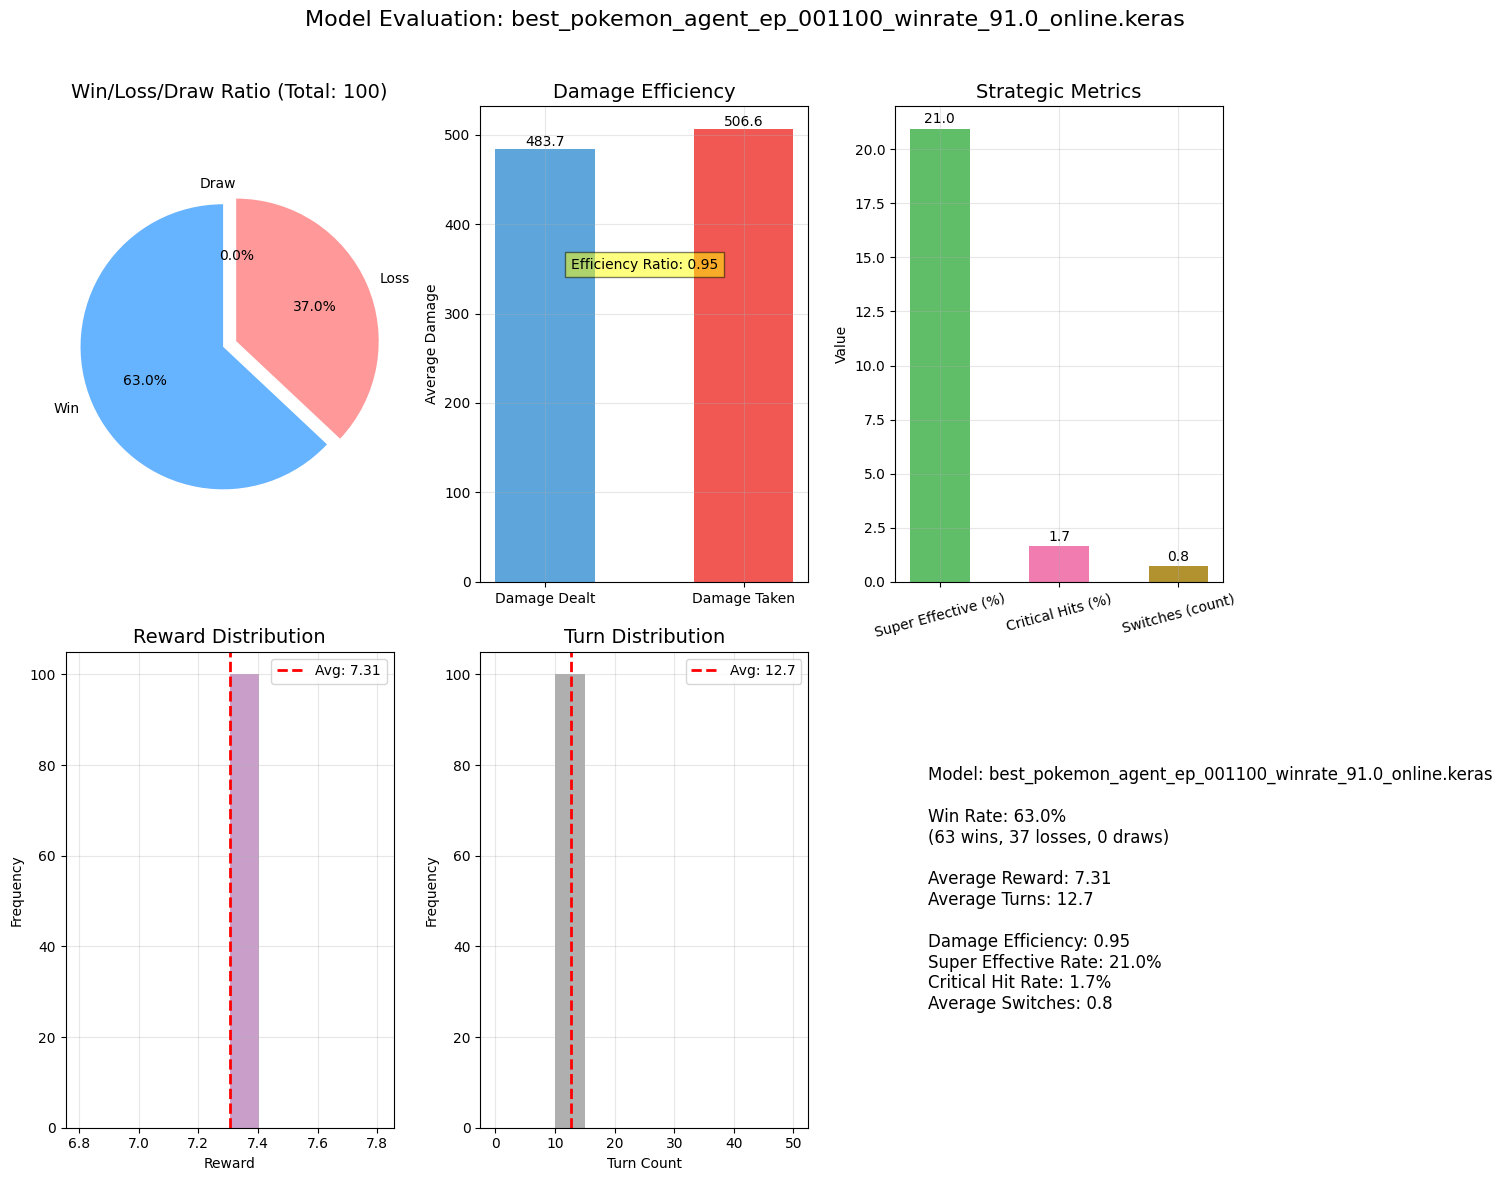

Evaluation results saved: ./pokemon_model_evaluation/best_pokemon_agent_ep_001100_winrate_91.0_online.keras_evaluation_20250409_070138.json
배틀 #71 리플레이 저장 완료: ./pokemon_model_evaluation/best_pokemon_agent_ep_001100_winrate_91.0_online.keras_best_battle_1_71.txt
배틀 #49 리플레이 저장 완료: ./pokemon_model_evaluation/best_pokemon_agent_ep_001100_winrate_91.0_online.keras_best_battle_2_49.txt
배틀 #90 리플레이 저장 완료: ./pokemon_model_evaluation/best_pokemon_agent_ep_001100_winrate_91.0_online.keras_best_battle_3_90.txt

Evaluation Summary
Win Rate: 63.0% (63 wins, 37 losses, 0 draws)
Average Reward: 7.31
Average Turns: 12.7
Damage Efficiency: 0.95 (damage dealt/damage taken)
Super Effective Rate: 21.0%
Average Switches: 0.8

Result File: ./pokemon_model_evaluation/best_pokemon_agent_ep_001100_winrate_91.0_online.keras_evaluation_20250409_070138.json

Top Performing Battles:
  #1: Reward 31.95, Result: WIN, 12 turns
  #2: Reward 27.28, Result: WIN, 6 turns
  #3: Reward 26.91, Result: WIN, 12 turns

Evalua

In [ ]:

import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import json
from datetime import datetime

# NumPy 타입을 JSON으로 변환하는 인코더 추가
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NumpyEncoder, self).default(obj)

# 일관된 결과를 위한 시드 고정
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# 수정된 load_model 함수
def load_model(self, model_path, model_dir='./'):
    """모델 로드 - 온라인 네트워크만 로드하도록 수정"""
    try:
        # 모델 경로가 전체 경로인지 확인
        if os.path.isfile(model_path):
            # 전체 경로인 경우
            online_path = model_path
        else:
            # 파일 경로 확인
            online_path = os.path.join(model_dir, f"{model_path}_online.keras")
            if not os.path.exists(online_path):
                # .keras 확장자 없이 시도
                online_path = os.path.join(model_dir, f"{model_path}_online")
                if not os.path.exists(online_path):
                    # 다른 가능한 확장자 시도
                    for ext in ['.h5', '']:
                        test_path = os.path.join(model_dir, f"{model_path}_online{ext}")
                        if os.path.exists(test_path):
                            online_path = test_path
                            break

                    # 접미사 없이 시도
                    if not os.path.exists(online_path):
                        for ext in ['.keras', '.h5', '']:
                            test_path = os.path.join(model_dir, f"{model_path}{ext}")
                            if os.path.exists(test_path):
                                online_path = test_path
                                break

        # 온라인 네트워크 로드
        print(f"Attempting to load online network: {online_path}")
        if os.path.exists(online_path):
            self.online_network = tf.keras.models.load_model(online_path)

            # 타겟 네트워크에도 같은 가중치 복사 (평가에서는 타겟 네트워크가 필요 없지만 코드의 일관성을 위해)
            self.target_network.set_weights(self.online_network.get_weights())

            print(f"Model loaded successfully: {online_path}")
            print("Target network set to online network weights (for evaluation)")
            return True
        else:
            print(f"Model file not found: {online_path}")
            return False

    except Exception as e:
        print(f"Failed to load model: {model_path}, Error: {str(e)}")

        # 디렉토리 내용 출력
        try:
            print("\nDirectory contents:")
            files = os.listdir(model_dir if model_dir else '.')
            for file in files:
                if os.path.basename(model_path) in file:
                    print(f"  - {file}")
        except Exception as dir_err:
            print(f"Failed to check directory: {str(dir_err)}")

        return False

# BattleLogger 클래스의 save_results 메서드 패치
def save_results(self, model_name, save_dir=None):
    """결과 저장 - NumPy 타입 처리"""
    if save_dir is None:
        save_dir = EVAL_DIR

    os.makedirs(save_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{model_name}_evaluation_{timestamp}.json"
    filepath = os.path.join(save_dir, filename)

    # 통계 계산
    stats = self.get_statistics()

    # 저장할 데이터
    data = {
        'model_name': model_name,
        'timestamp': timestamp,
        'statistics': stats,
        'best_battles': self.best_battles,
        'battle_logs': self.battle_logs
    }

    with open(filepath, 'w') as f:
        json.dump(data, f, indent=2, cls=NumpyEncoder)  # NumpyEncoder 사용

    print(f"Evaluation results saved: {filepath}")
    return filepath

# 수정된 시각화 함수
def visualize_evaluation_results(stats, additional_stats, model_name):
    """Visualization of evaluation results - English only"""
    # Extract short name from file path
    short_name = os.path.basename(model_name)

    # Plot settings
    plt.figure(figsize=(15, 12))

    # 최신 matplotlib/seaborn 버전에 맞는 스타일 사용
    # 이전 버전의 'seaborn-whitegrid' 대신 기본 스타일 사용
    plt.style.use('default')

    # 그리드 수동 추가
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.3

    # 1. Win/Loss/Draw ratio (Pie chart)
    plt.subplot(2, 3, 1)
    labels = ['Win', 'Loss', 'Draw']
    sizes = [stats['wins'], stats['losses'], stats['draws']]
    colors = ['#66b3ff', '#ff9999', '#99ff99']
    explode = (0.1, 0, 0)  # Emphasize wins

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.axis('equal')
    plt.title(f'Win/Loss/Draw Ratio (Total: {stats["total_battles"]})', fontsize=14)

    # 2. Damage comparison (Bar graph)
    plt.subplot(2, 3, 2)
    damage_data = [additional_stats['avg_damage_dealt'], additional_stats['avg_damage_taken']]
    damage_labels = ['Damage Dealt', 'Damage Taken']
    x_pos = np.arange(len(damage_labels))

    bars = plt.bar(x_pos, damage_data, width=0.5, color=['#5DA5DA', '#F15854'])
    plt.ylabel('Average Damage')
    plt.title('Damage Efficiency', fontsize=14)
    plt.xticks(x_pos, damage_labels)

    # Display values
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{damage_data[i]:.1f}', ha='center', va='bottom')

    # Calculate damage efficiency ratio
    if additional_stats['avg_damage_taken'] > 0:
        efficiency = additional_stats['avg_damage_dealt'] / additional_stats['avg_damage_taken']
        plt.text(0.5, max(damage_data) * 0.7, f'Efficiency Ratio: {efficiency:.2f}',
                ha='center', va='center', bbox=dict(facecolor='yellow', alpha=0.5))

    # 3. Strategic metrics (Bar graph)
    plt.subplot(2, 3, 3)
    strategy_data = [additional_stats['super_effective_rate'],
                    additional_stats['critical_hit_rate'],
                    additional_stats['avg_switches']]
    strategy_labels = ['Super Effective (%)', 'Critical Hits (%)', 'Switches (count)']
    x_pos = np.arange(len(strategy_labels))

    colors = ['#60BD68', '#F17CB0', '#B2912F']
    bars = plt.bar(x_pos, strategy_data, width=0.5, color=colors)
    plt.ylabel('Value')
    plt.title('Strategic Metrics', fontsize=14)
    plt.xticks(x_pos, strategy_labels, rotation=15)

    # Display values
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                f'{strategy_data[i]:.1f}', ha='center', va='bottom')

    # 4. Reward histogram
    plt.subplot(2, 3, 4)
    rewards = stats.get('rewards', [stats['avg_reward']] * stats['total_battles'])
    plt.hist(rewards, bins=10, color='#B276B2', alpha=0.7)
    plt.axvline(stats['avg_reward'], color='r', linestyle='dashed', linewidth=2, label=f'Avg: {stats["avg_reward"]:.2f}')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    plt.title('Reward Distribution', fontsize=14)
    plt.legend()

    # 5. Turn count histogram
    plt.subplot(2, 3, 5)
    turns = stats.get('turns', [stats['avg_turns']] * stats['total_battles'])
    plt.hist(turns, bins=range(0, 55, 5), color='#8E8E8E', alpha=0.7)
    plt.axvline(stats['avg_turns'], color='r', linestyle='dashed', linewidth=2, label=f'Avg: {stats["avg_turns"]:.1f}')
    plt.xlabel('Turn Count')
    plt.ylabel('Frequency')
    plt.title('Turn Distribution', fontsize=14)
    plt.legend()

    # 6. Summary text
    plt.subplot(2, 3, 6)
    plt.axis('off')
    summary_text = f"Model: {short_name}\n\n"
    summary_text += f"Win Rate: {stats['win_rate']:.1f}%\n"
    summary_text += f"({stats['wins']} wins, {stats['losses']} losses, {stats['draws']} draws)\n\n"
    summary_text += f"Average Reward: {stats['avg_reward']:.2f}\n"
    summary_text += f"Average Turns: {stats['avg_turns']:.1f}\n\n"

    if additional_stats['avg_damage_taken'] > 0:
        efficiency = additional_stats['avg_damage_dealt'] / additional_stats['avg_damage_taken']
        summary_text += f"Damage Efficiency: {efficiency:.2f}\n"

    summary_text += f"Super Effective Rate: {additional_stats['super_effective_rate']:.1f}%\n"
    summary_text += f"Critical Hit Rate: {additional_stats['critical_hit_rate']:.1f}%\n"
    summary_text += f"Average Switches: {additional_stats['avg_switches']:.1f}"

    plt.text(0.1, 0.5, summary_text, fontsize=12, va='center')

    # Title
    plt.suptitle(f'Model Evaluation: {short_name}', fontsize=16, y=0.98)

    # Layout adjustment
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)

    # Save
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_path = os.path.join(EVAL_DIR, f"{short_name}_evaluation_plot_{timestamp}.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Visualization saved: {save_path}")

    # Display
    plt.show()

def main():
    # 시드 고정
    set_seed(42)

    # 코랩 환경의 모델 경로 설정 (전체 경로 사용)
    model_path = "/content/pokemon_best_models/best_pokemon_agent_ep_001100_winrate_91.0_online.keras"

    # 모델 파일 존재 확인
    if not os.path.exists(model_path):
        print(f"Error: Model file not found: {model_path}")
        print("Checking directory...")
        if os.path.exists("/content/pokemon_best_models"):
            print("Directory contents:")
            print(os.listdir("/content/pokemon_best_models"))
        else:
            print("Directory /content/pokemon_best_models does not exist.")
        return

    print("="*50)
    print(f"Starting Pokemon Battle AI Evaluation")
    print(f"Model: {model_path}")
    print("="*50)

    # 함수 패치
    import sys

    # DQNAgent 클래스의 load_model 메서드를 패치
    DQNAgent.load_model = load_model

    # BattleLogger 클래스의 save_results 메서드를 패치
    BattleLogger.save_results = save_results

    # 시각화 함수 패치
    sys.modules[__name__].visualize_evaluation_results = visualize_evaluation_results

    # 배틀 수 설정
    num_battles = 100

    # 모델 평가 함수 호출
    results = evaluate_model_against_baseline(
        model_path=model_path,
        model_dir="",  # 전체 경로를 model_path에 넣었으므로 model_dir은 비워둠
        num_battles=num_battles
    )

    if results:
        # 평가 결과 요약
        stats = results['statistics']
        add_stats = results['additional_stats']

        print("\n"+"="*50)
        print("Evaluation Summary")
        print("="*50)
        print(f"Win Rate: {stats['win_rate']:.1f}% ({stats['wins']} wins, {stats['losses']} losses, {stats['draws']} draws)")
        print(f"Average Reward: {stats['avg_reward']:.2f}")
        print(f"Average Turns: {stats['avg_turns']:.1f}")

        # 데미지 효율성
        if add_stats['avg_damage_taken'] > 0:
            efficiency = add_stats['avg_damage_dealt'] / add_stats['avg_damage_taken']
            print(f"Damage Efficiency: {efficiency:.2f} (damage dealt/damage taken)")

        print(f"Super Effective Rate: {add_stats['super_effective_rate']:.1f}%")
        print(f"Average Switches: {add_stats['avg_switches']:.1f}")

        # 파일 출력 결과
        print(f"\nResult File: {results['result_file']}")

        # 최고 배틀 간략 요약
        print("\nTop Performing Battles:")
        for i, battle in enumerate(results['best_battles'][:3]):
            print(f"  #{i+1}: Reward {battle['reward']:.2f}, Result: {battle['result'].upper()}, {battle['turn_count']} turns")
    else:
        print("\nModel evaluation failed")

    print("\n"+"="*50)
    print("Evaluation complete")
    print("="*50)

if __name__ == "__main__":
    main()